# Key Idea

Import state selection into the exploration part.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import scriptinit
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
from matplotlib.pyplot import *
from pyrl.algorithms.uvfa import *
from pyrl.algorithms.valueiter import *
from pyrl.tasks.gridworld import *
from pyrl.algorithms.nn import *
from pyrl.agents.agent import *
from pyrl.agents.multitask import *
from pyrl.algorithms.multitask import *
import pyrl.agents.arch as arch
from pyrl.prob import *
from pyrl.utils import *
from pyrl.evaluate import *

Couldn't import dot_parser, loading of dot files will not be possible.


In [178]:
def showV(v):
    imshow(v.reshape(H, W), interpolation='none')
    plt.axis('off')
#     print v
    
def showVdict(Idict, task):
    Q = np.zeros((H, W))
    for state in Idict:
        val = Idict[state]
        Q[task.env.state_pos[state]] = val
    imshow(Q, interpolation='none')
    axis('off')
        
def showExperience(agent):
    task_types = set(agent.experience_task)
    task_percent = dict()
    for task in task_types:
        task_percent[task] = sum([e == task for e in agent.experience_task])
#     total = sum(task_percent.values())
    total = 1.
    return {key: val / float(total) for (key, val) in task_percent.items()}

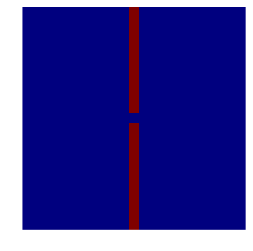

In [173]:
# world 1
H = W = 21
world = np.zeros((H, W))
world[:10, 10] = 1
world[11:, 10] = 1
showV(world)

In [308]:
two_layer_arch = lambda states: arch.two_layer(states, H * W * 2, 32, 4)
grid = Grid(world, action_stoch=0.2)
tol = 1e-6
goal = {(20, 20): 1.}
task = GridWorldUltimateFixedStart(grid.state_id[(0,0)], grid_env=grid, goal=goal, demons={}, rewards=goal, wall_penalty=0., gamma=0.98)


In [309]:
def dist(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

In [310]:
class TeleportDeepQlearn(object):
    '''
    DeepQlearn based on the teleportation idea.
    '''
    def __init__(self, task, dqn_mt, l2_reg=0.0, lr=1e-3, minibatch_size=64, memory_size=256, epsilon=0.05):
        '''
        (TODO): task should be task info.
        we don't use all of task properties/methods here.
        only gamma and state dimension.
        and we allow task switching.
        '''
        self.dqn = dqn_mt
        self.l2_reg = l2_reg
        self.lr = lr
        self.epsilon = epsilon
        self.minibatch_size = minibatch_size
        self.state_dim = task.get_state_dimension()
        self.gamma = task.gamma
        self.task = task
        self.memory_size = memory_size

        # for now, keep experience as a list of tuples
        self.experience = []
        self.exp_idx = 0

        # initialially Improvement function I is zero.
        # so will select uniformly at random.
        self.I = {state: 0. for state in task.get_valid_states()}
        self.task_pool = task.get_valid_states()
        
        # select task based on meta-reasoning.
        # log_p is the meta model for anticipated improvement (i.e. the selection probability).
        self.pred = np.zeros(len(self.task_pool))

        # some diagnostic statistics.
        self.teleport_count = {state: 0 for state in task.get_valid_states()}
        self.teleport_prob = {state: 0. for state in task.get_valid_states()}
        self.Q = {state: 0. for state in task.get_valid_states()} # q values after each iteration.
        self.Qnext = {state: {} for state in task.get_valid_states()} # memory for Q values of next states.

        # used for streaming updates
        self.last_state = None
        self.last_action = None

        # compile back-propagtion network
        self._compile_bp()

    def _compile_bp(self):
        states = self.dqn.states
        action_values = self.dqn.action_values
        params = self.dqn.params
        targets = T.vector('target')
        last_actions = T.lvector('action')

        # loss function.
        mse = layers.MSE(action_values[T.arange(action_values.shape[0]),
                            last_actions], targets)
        # l2 penalty.
        l2_penalty = 0.
        for param in params:
            l2_penalty += (param ** 2).sum()

        cost = mse + self.l2_reg * l2_penalty

        # back propagation.
        updates = optimizers.Adam(cost, params, alpha=self.lr)

        td_errors = T.sqrt(mse)
        self.bprop = theano.function(inputs=[states, last_actions, targets],
                                     outputs=td_errors, updates=updates)

    def _add_to_experience(self, s, a, ns, r):
        # TODO: improve experience replay mechanism by making it harder to
        # evict experiences with high td_error, for example
        # s, ns are state_vectors.
        if len(self.experience) < self.memory_size:
            self.experience.append((s, a, ns, r))
        else:
            self.experience[self.exp_idx] = (s, a, ns, r)
            self.exp_idx += 1
            if self.exp_idx >= self.memory_size:
                self.exp_idx = 0
    
    def _compute_values(self, state_list):
        states = np.zeros((len(state_list), self.state_dim,))
        
        for si, state in enumerate(state_list):
            state_vector = self.task.wrap_stateid(state)
            states[si, :] = state_vector.reshape(-1)

        q = np.max(self.dqn.fprop(states), axis=1)
        return q
    
    def _update_net(self):
        '''
            sample from the memory dataset and perform gradient descent on
            (target - Q(s, a))^2
        '''
        states = np.zeros((self.minibatch_size, self.state_dim,))
        next_states = np.zeros((self.minibatch_size, self.state_dim))
        actions = np.zeros(self.minibatch_size, dtype=int)
        rewards = np.zeros(self.minibatch_size)

        # sample and process minibatch
        samples = prob.choice(self.experience, self.minibatch_size, replace=True)
        terminals = []
        for idx, sample in enumerate(samples):
            state, action, next_state, reward = sample
            state_vector = self.task.wrap_stateid(state)

            states[idx, :] = state_vector.reshape(-1)
            actions[idx] = action
            rewards[idx] = reward

            if next_state is not None:
                next_state_vector = self.task.wrap_stateid(next_state)
                next_states[idx, :] = next_state_vector.reshape(-1)
            else:
                terminals.append(idx)

        # compute target reward + \gamma max_{a'} Q(ns, a')
        next_qvals = np.max(self.dqn.fprop(next_states), axis=1)

        # Ensure target = reward when NEXT_STATE is terminal
        next_qvals[terminals] = 0.

        targets = rewards + self.task.gamma * next_qvals

        self.bprop(states, actions, targets.flatten())

    def _learn(self, next_state, reward):
        self._add_to_experience(self.last_state, self.last_action,
                                next_state, reward)

    def _end_episode(self, reward):
        if self.last_state is not None:
            self._add_to_experience(self.last_state, self.last_action, None,
                                    reward)
        self.last_state = None
        self.last_action = None

    def run(self, num_epochs = 5, budget=10, batchsize=1, tol=1e-4, diagnostic_function = None):
        task = self.task

        total_steps = 0.
        self.experience = []
        task_pool = self.task_pool
        
        # task_pool = [task.env.state_id[(H-1, W-2)]]
        curriculum = []
        for i in range(1, 21, 2):
            for j in range(1, 21, 2):
                    curriculum.append((i, j))
        curriculum = sorted(curriculum, key = lambda x: dist(x, (20, 20)))
        print curriculum
        
        for ei in range(num_epochs):
            if ei < len(curriculum):
                chosen_states = [task.env.state_id[curriculum[ei]]]
            else:
                p = [self.teleport_prob[state] for state in task_pool]
                chosen_states = prob.choice(task_pool, batchsize, replace=True, p=p)
                    
            old_q = self._compute_values(task_pool)
            old_q_dict = {state: old_q[si] for si, state in enumerate(task_pool)}
            
            for chosen_state in chosen_states:
                
                num_episodes = 100
                
                # for now, just use sufficient amount of episodes
                # wait until Q[state] converges.
                # not dealing with convergence criterions yet...
                for ni in range(num_episodes): 
                    task.env.curr_state = task.env.state_pos[chosen_state]
                    curr_state = task.get_current_state()
                    self.teleport_count[chosen_state] += 1
                    if task.is_terminal():
                        assert(False) # this shouldn't happen.

                    num_steps = 0.
                    while True:
                        if num_steps >= np.log(tol) / np.log(task.gamma) or num_steps >= budget:
                            # print 'Lying and tell the agent the episode is over!'
                            self._end_episode(0)
                            break

                        curr_state_vector = task.wrap_stateid(curr_state)
                        action = self.dqn.get_action(curr_state_vector, method='eps-greedy', epsilon=self.epsilon)
                        self.last_state = curr_state
                        self.last_action = action

                        next_state, reward = task.perform_action(action)

                        if task.is_terminal():
                            self._end_episode(reward)
                            break
                        else:
                            self._learn(next_state, reward)
                            self._update_net()
                            curr_state = next_state

                        num_steps += 1
                        total_steps += 1

                new_q = self._compute_values(task_pool)
                new_q_dict = {state: new_q[si] for si, state in enumerate(task_pool)}
                print 'new Q value', self._compute_values([chosen_state])
            
                for si, state in enumerate(task_pool):
                    self.Q[state] = new_q[si]
                    self.I[state] = new_q[si] - old_q[si]
                
                # estimate improvement.
                # currently reason based on the improvement of neighbors.
                pred = self.pred
                for (si, state) in enumerate(task_pool):
#                     avg_I = 0.
#                     for action in task.get_allowed_actions(state):
#                         for (ns, pi) in task.next_state_distribution(state, action):
#                             if ns in self.I:
#                                 avg_I += self.I[ns]
#                     avg_I /= len(task.get_allowed_actions(state))
                    
#                     for (si2, state2) in enumerate(task_pool):
#                         if dis >= 4 and dis <= 8 and self.I[chosen_state] > 0.:
#                             pred[si] += avg_I 
                    pred[si] -= self.teleport_count[state] * 10
                
                log_p = prob.normalize_log(pred * 1e2)
                p = np.exp(log_p)
                self.teleport_prob = {state: pi for (state, pi) in zip(task_pool, p)}
                
            if diagnostic_function:
                diagnostic_function(ei)


# Teleport Algorithms

In [311]:
dqn = DQN(task, two_layer_arch)
learner = TeleportDeepQlearn(task, dqn, lr=5e-4, l2_reg=0., memory_size=10000)

[(19, 19), (17, 19), (19, 17), (15, 19), (17, 17), (19, 15), (13, 19), (15, 17), (17, 15), (19, 13), (11, 19), (13, 17), (15, 15), (17, 13), (19, 11), (9, 19), (11, 17), (13, 15), (15, 13), (17, 11), (19, 9), (7, 19), (9, 17), (11, 15), (13, 13), (15, 11), (17, 9), (19, 7), (5, 19), (7, 17), (9, 15), (11, 13), (13, 11), (15, 9), (17, 7), (19, 5), (3, 19), (5, 17), (7, 15), (9, 13), (11, 11), (13, 9), (15, 7), (17, 5), (19, 3), (1, 19), (3, 17), (5, 15), (7, 13), (9, 11), (11, 9), (13, 7), (15, 5), (17, 3), (19, 1), (1, 17), (3, 15), (5, 13), (7, 11), (9, 9), (11, 7), (13, 5), (15, 3), (17, 1), (1, 15), (3, 13), (5, 11), (7, 9), (9, 7), (11, 5), (13, 3), (15, 1), (1, 13), (3, 11), (5, 9), (7, 7), (9, 5), (11, 3), (13, 1), (1, 11), (3, 9), (5, 7), (7, 5), (9, 3), (11, 1), (1, 9), (3, 7), (5, 5), (7, 3), (9, 1), (1, 7), (3, 5), (5, 3), (7, 1), (1, 5), (3, 3), (5, 1), (1, 3), (3, 1), (1, 1)]
new Q value [ 0.94780903]
it 0


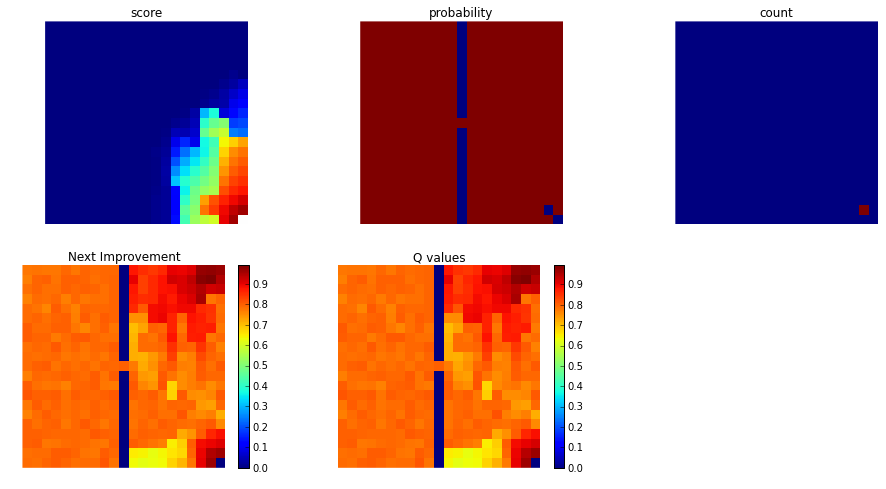

new Q value [ 0.90611946]
it 1


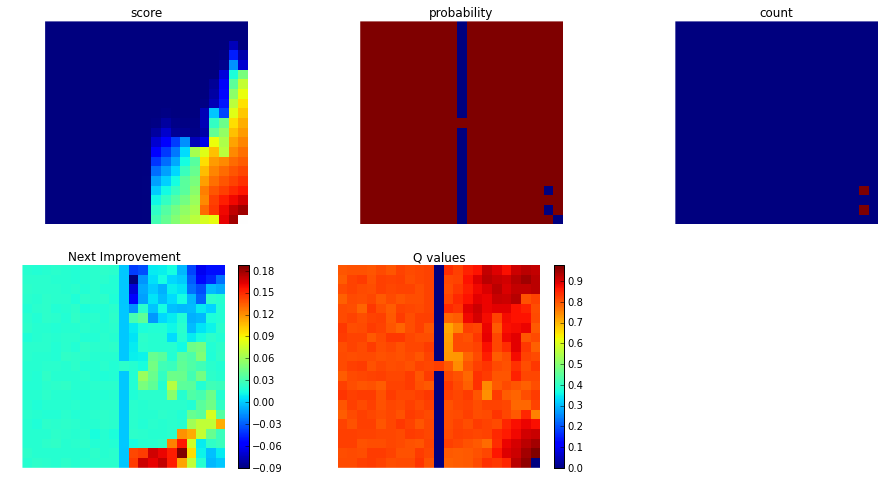

new Q value [ 0.91556393]
it 2


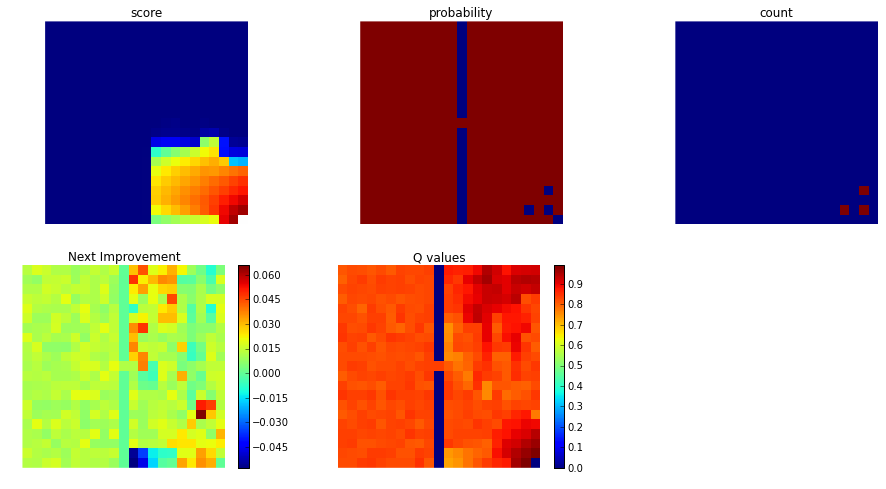

new Q value [ 0.87813252]
it 3


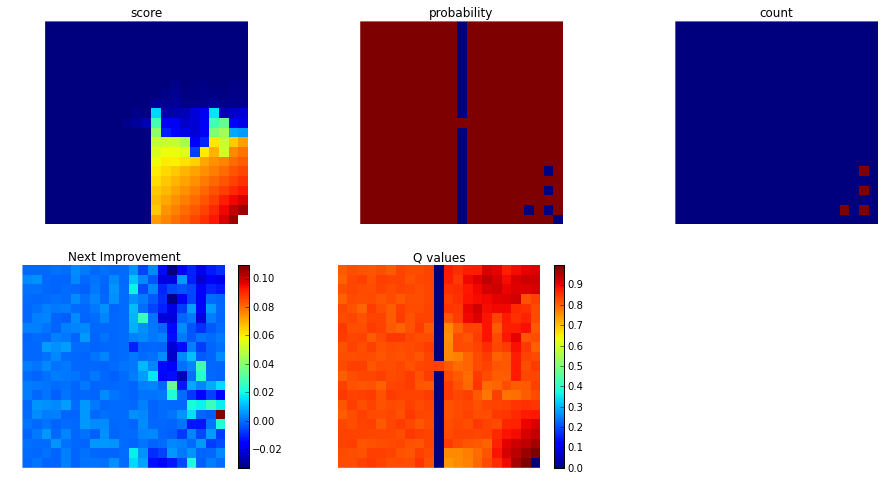

new Q value [ 0.86914935]
it 4


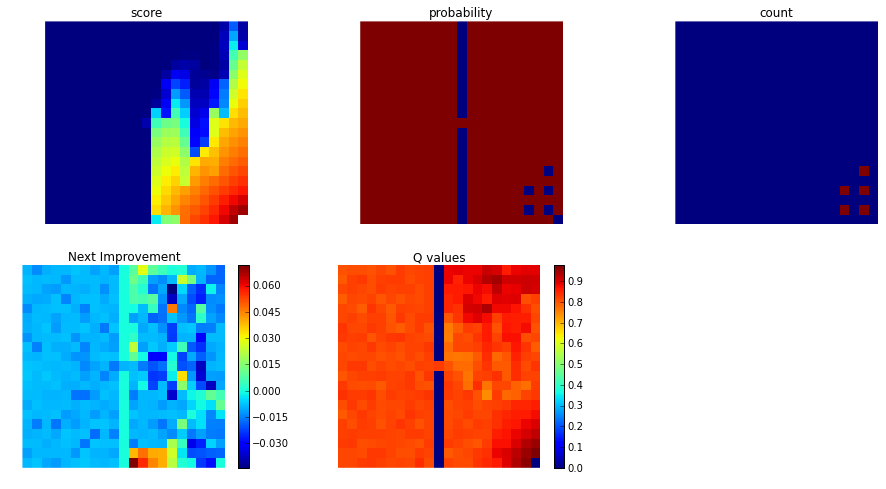

new Q value [ 0.89726557]
it 5


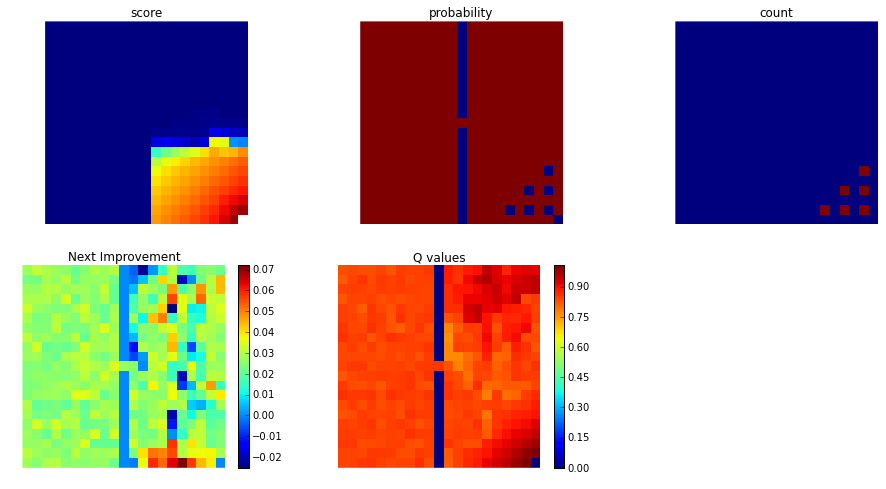

new Q value [ 0.83037866]
it 6


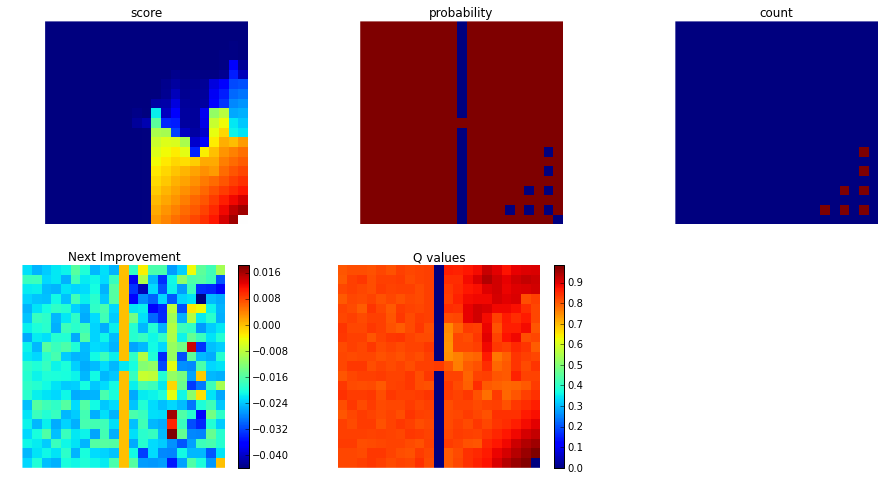

new Q value [ 0.83165515]
it 7


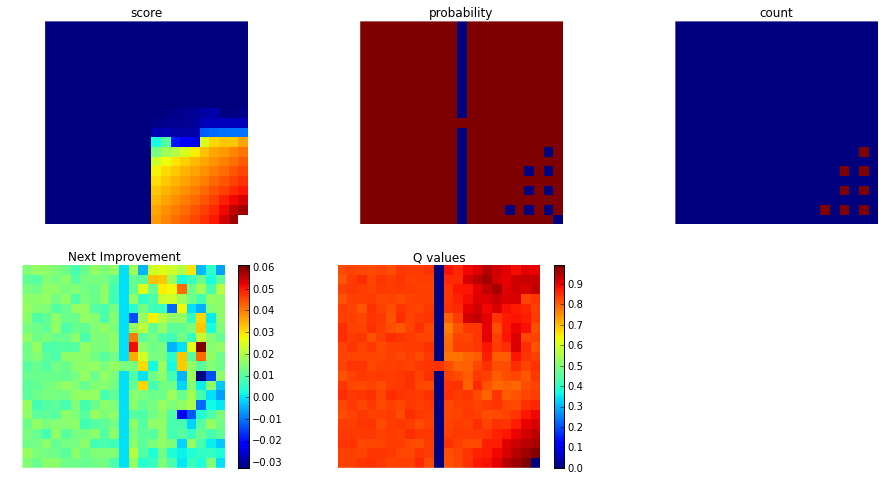

new Q value [ 0.8487759]
it 8


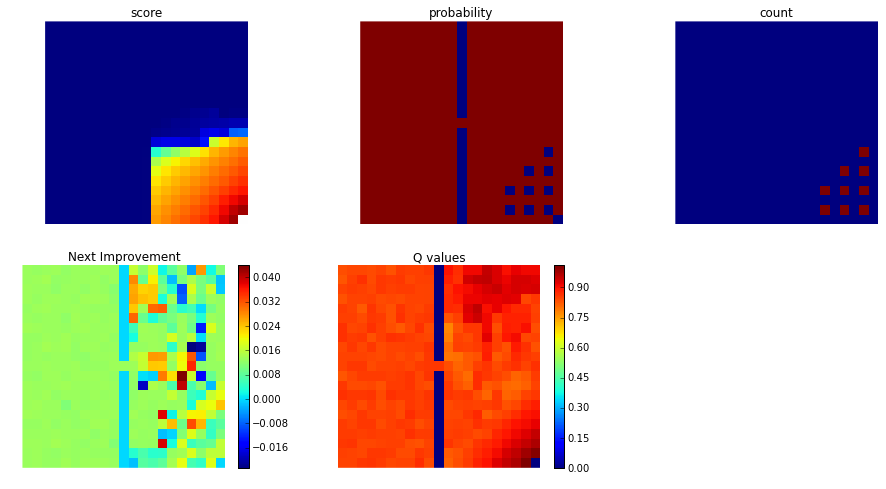

new Q value [ 0.83716568]
it 9


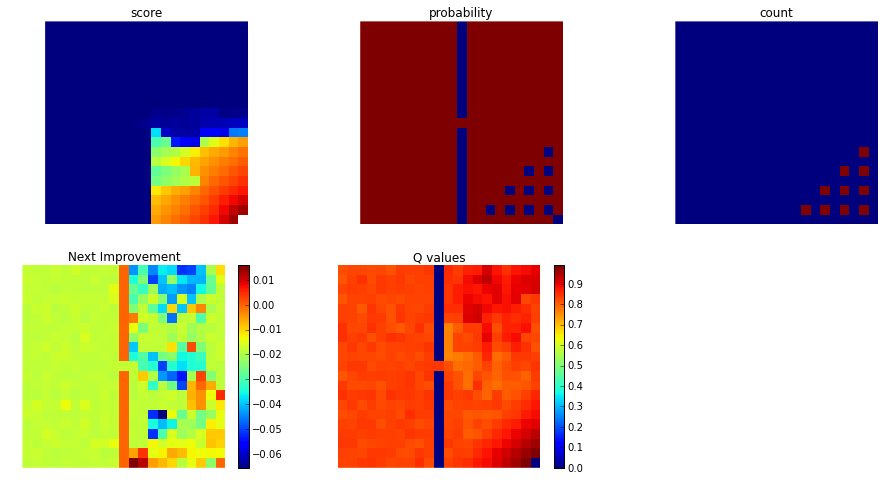

new Q value [ 0.80698477]
it 10


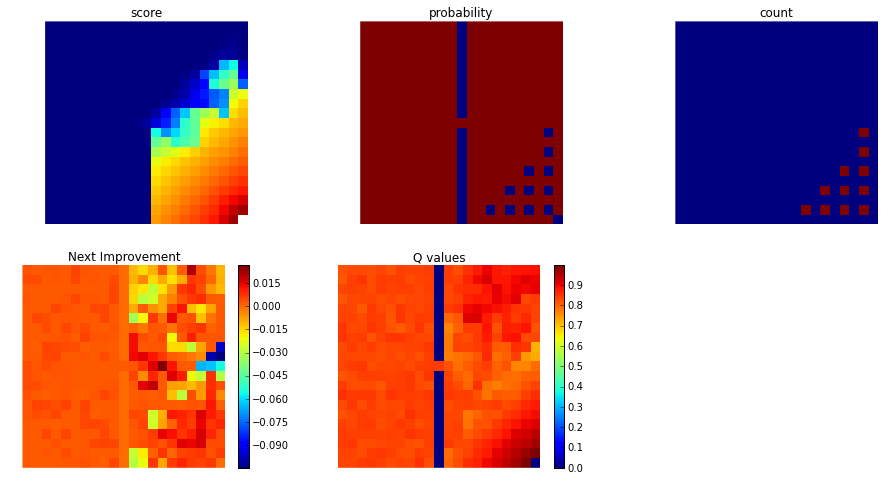

new Q value [ 0.80655737]
it 11


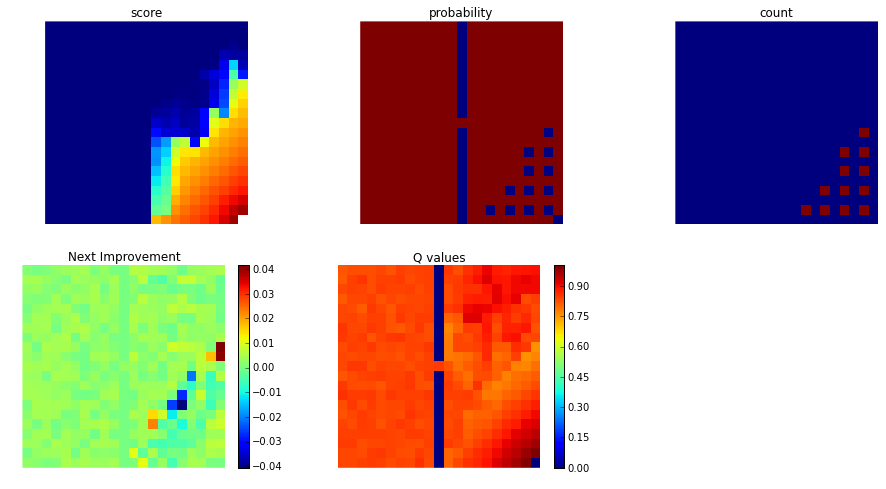

new Q value [ 0.8058521]
it 12


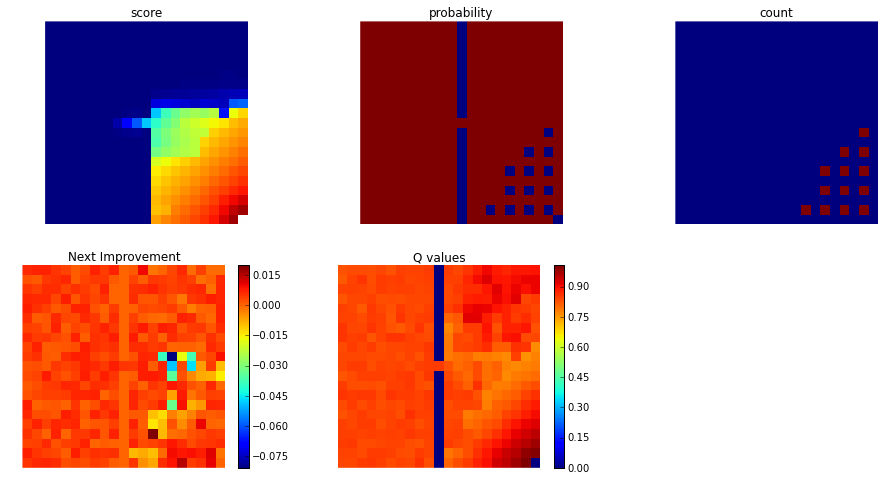

new Q value [ 0.79066674]
it 13


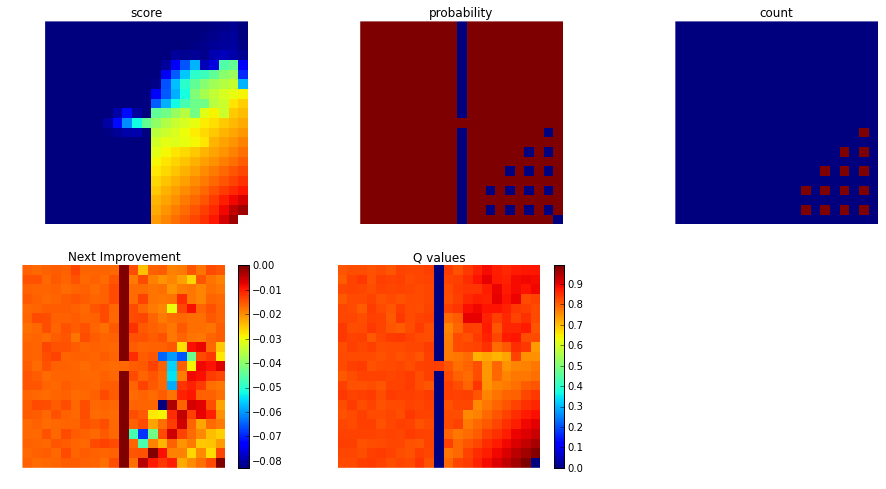

new Q value [ 0.78831186]
it 14


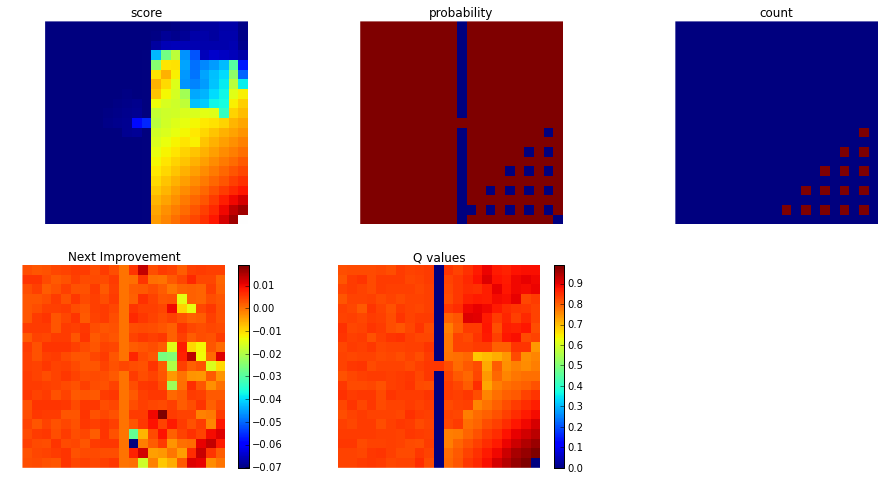

new Q value [ 0.74609399]
it 15


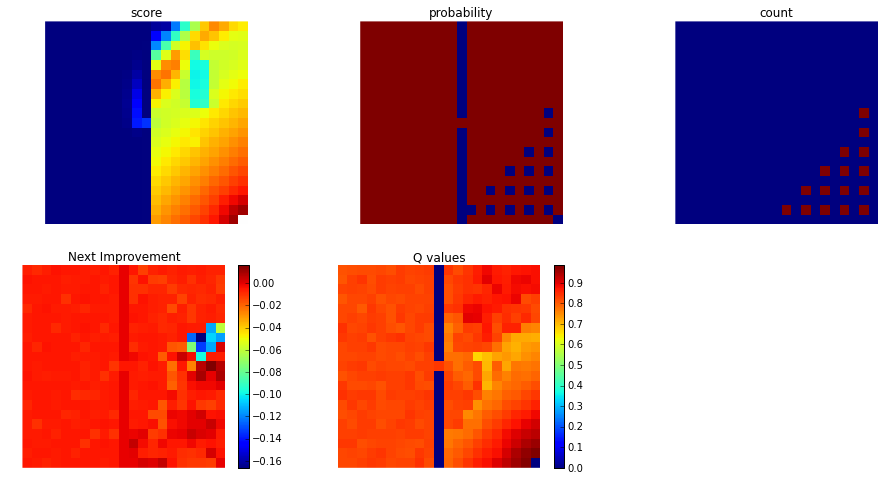

new Q value [ 0.75428345]
it 16


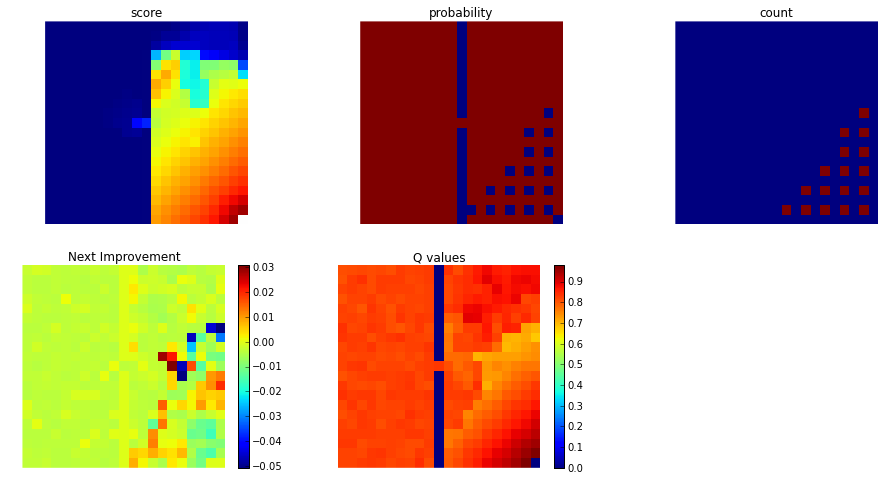

new Q value [ 0.75387093]
it 17


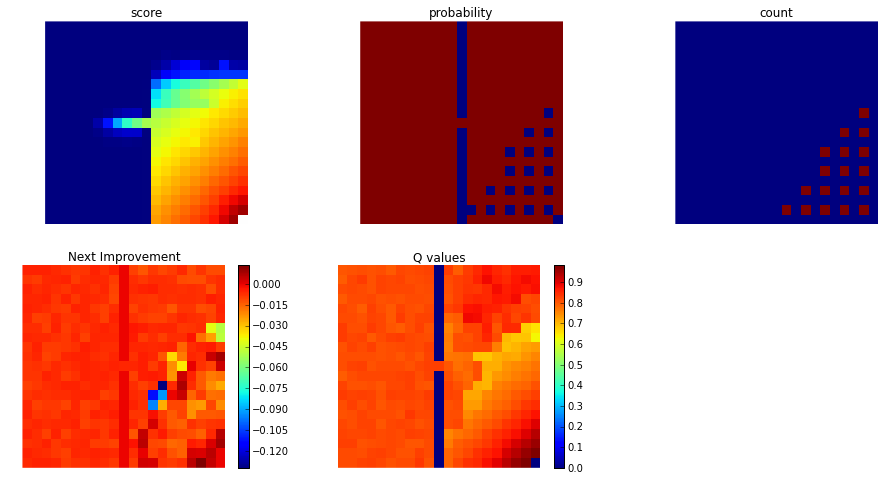

new Q value [ 0.75383885]
it 18


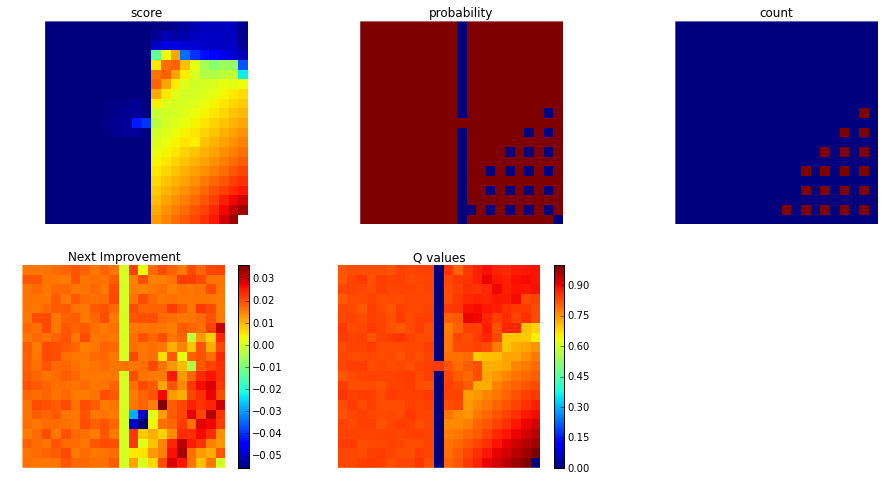

new Q value [ 0.75811248]
it 19


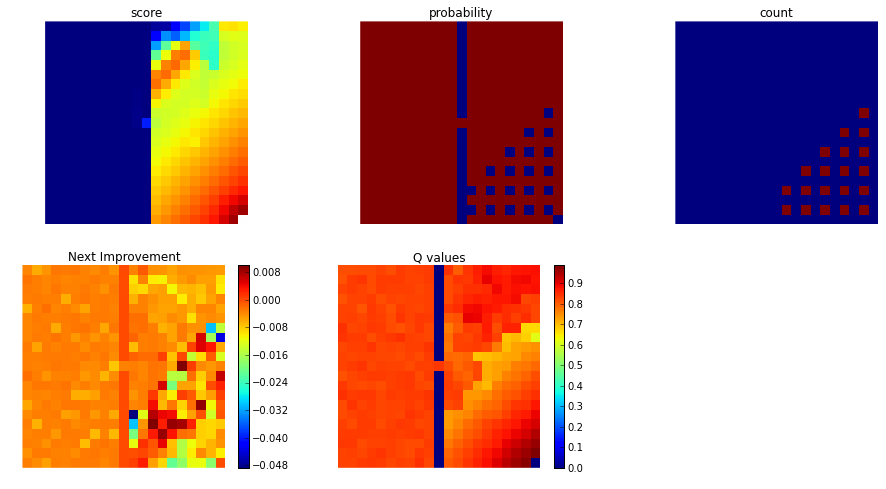

new Q value [ 0.50131749]
it 20


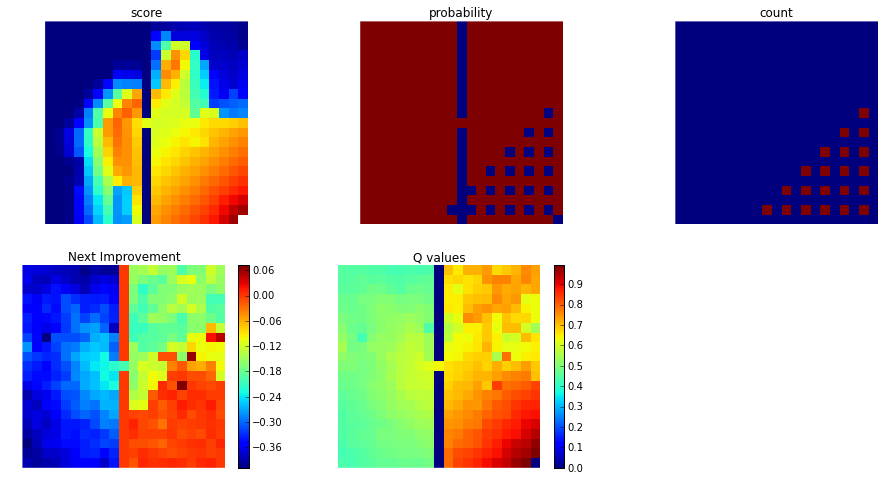

new Q value [ 0.70332165]
it 21


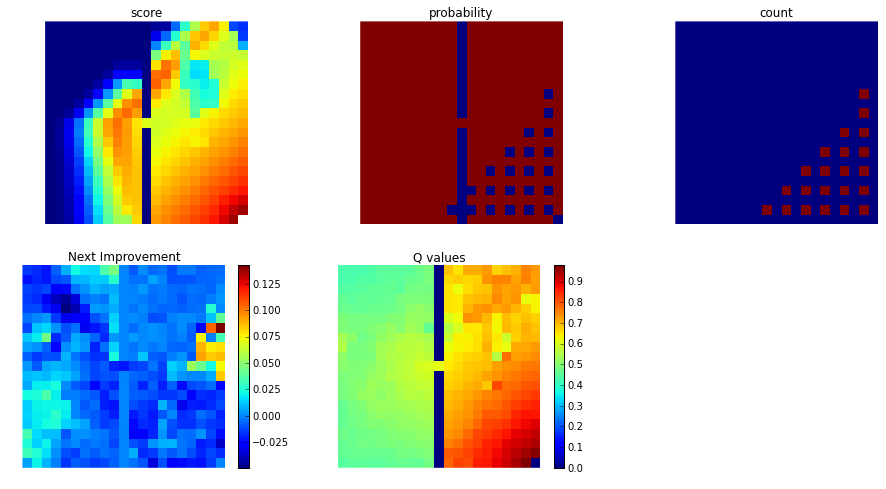

new Q value [ 0.74135226]
it 22


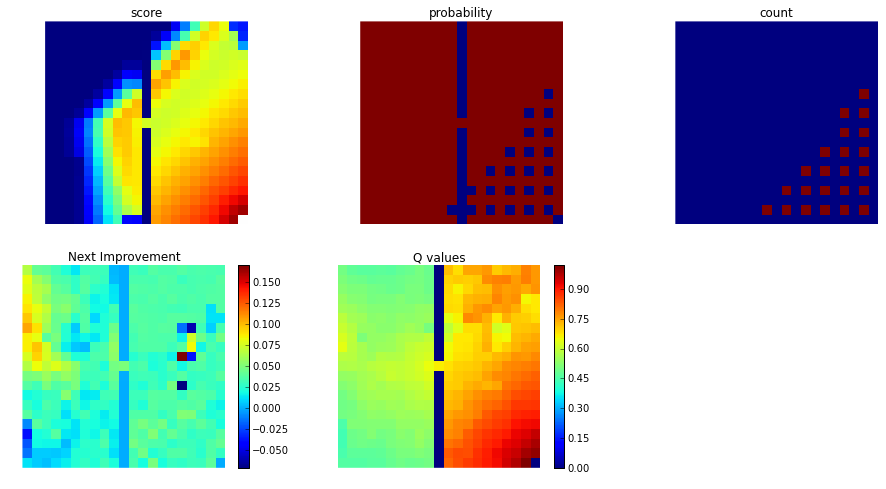

new Q value [ 0.72156875]
it 23


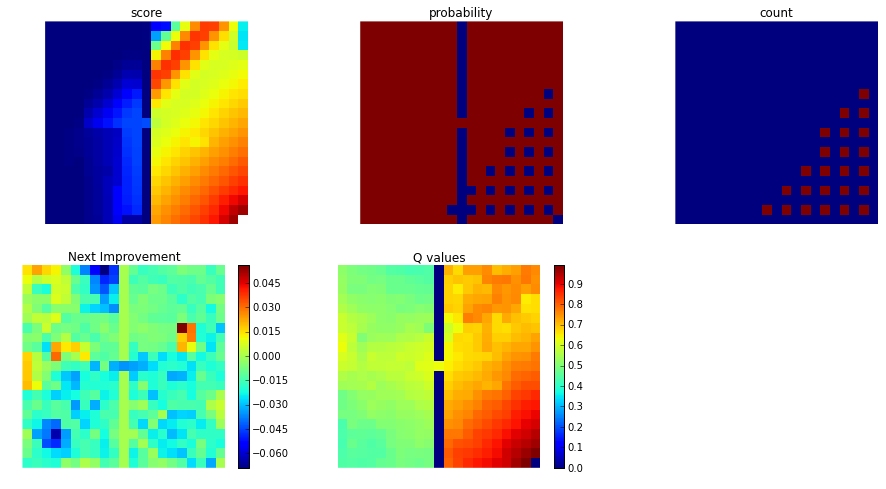

new Q value [ 0.72991386]
it 24


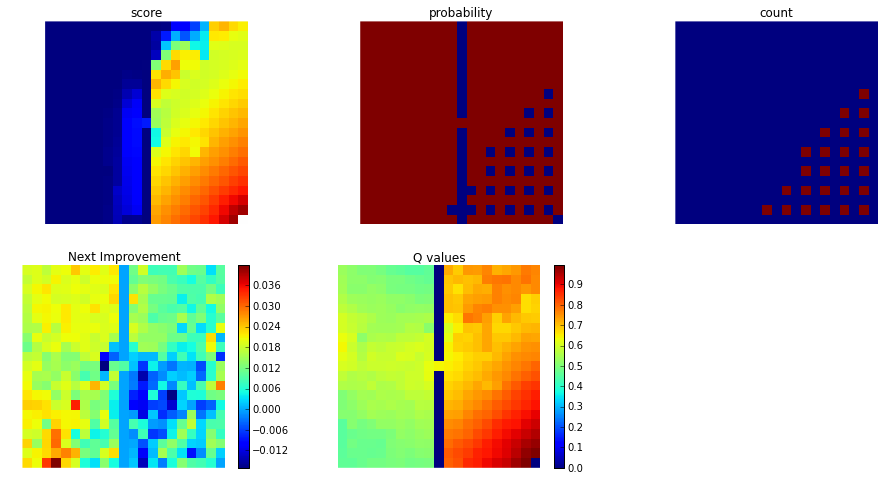

new Q value [ 0.74094822]
it 25


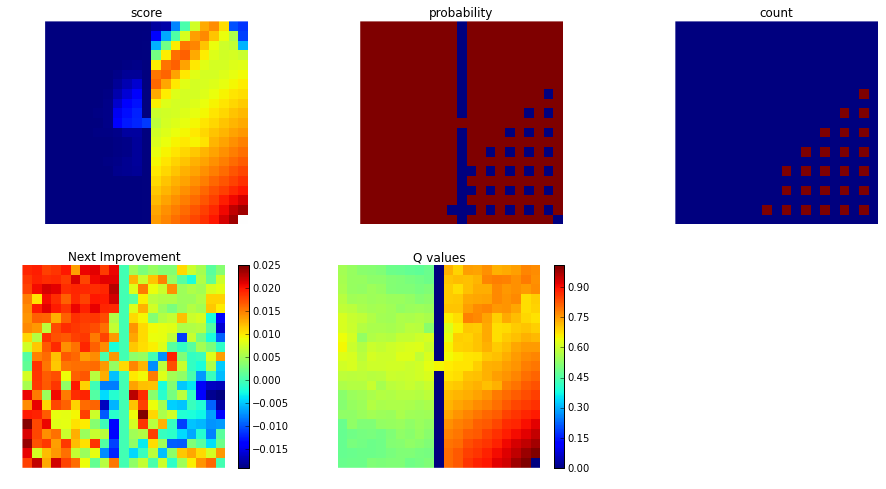

new Q value [ 0.51978222]
it 26


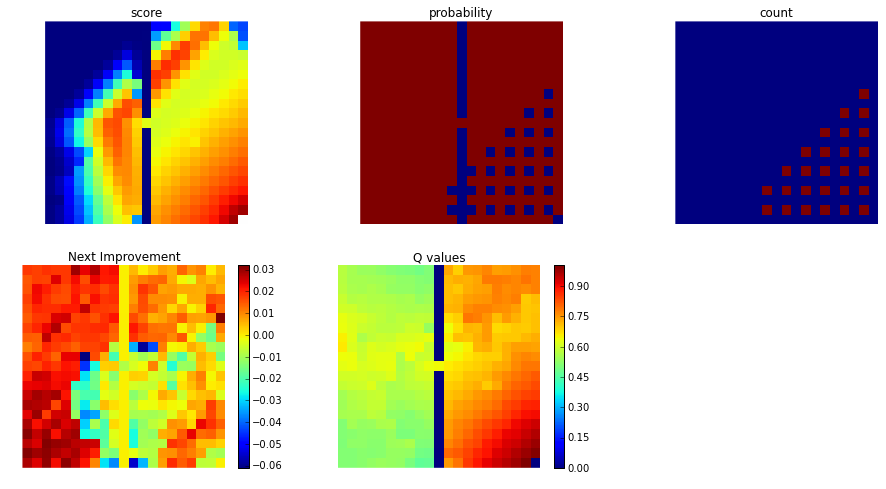

new Q value [ 0.47048233]
it 27


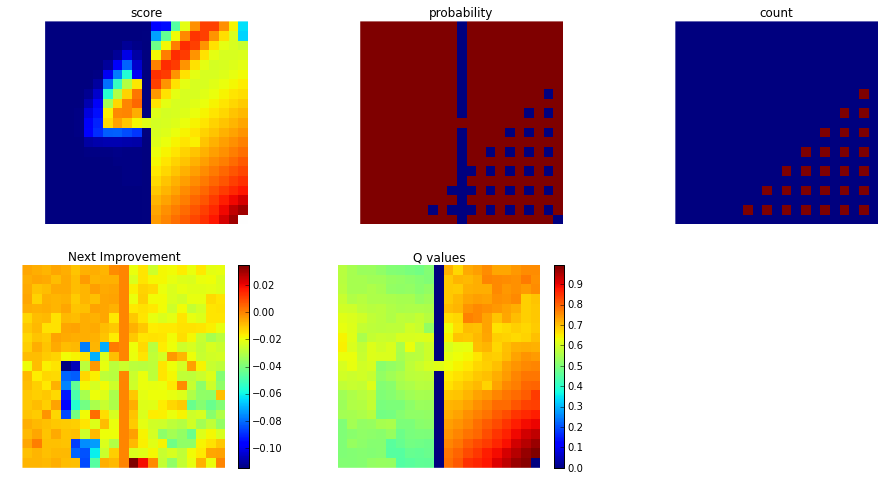

new Q value [ 0.67519208]
it 28


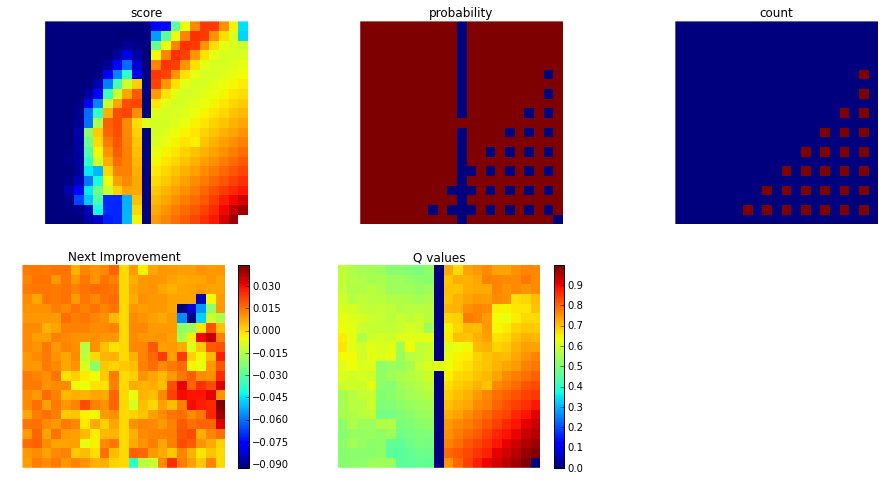

new Q value [ 0.68546627]
it 29


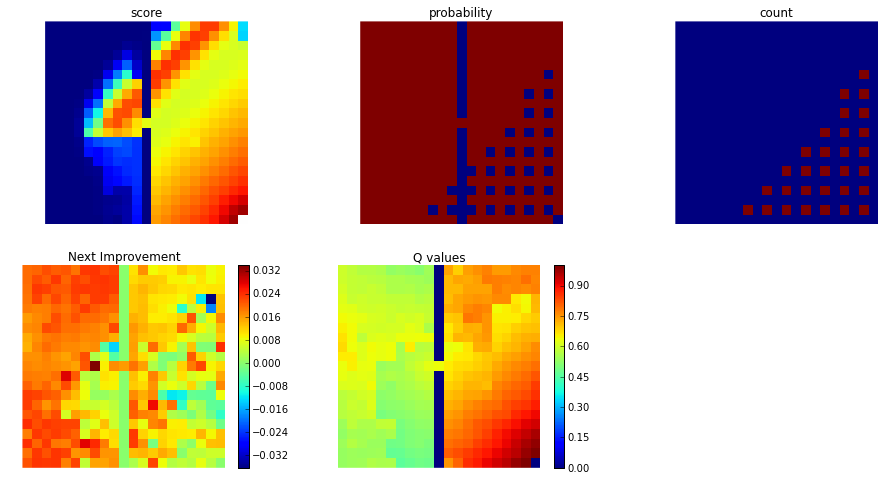

new Q value [ 0.67572522]
it 30


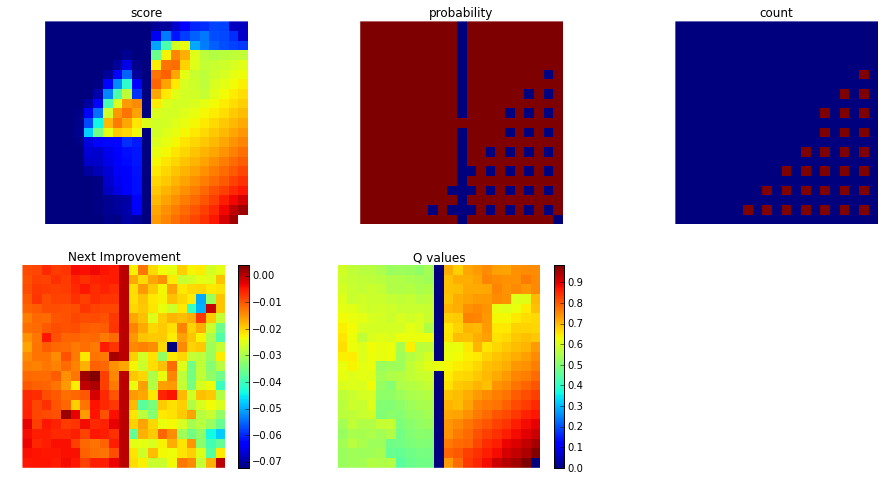

new Q value [ 0.70778532]
it 31


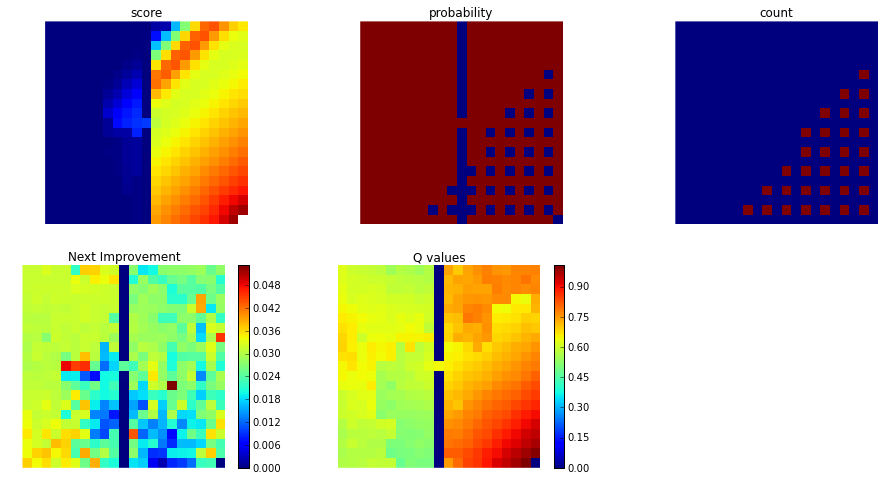

new Q value [ 0.69695627]
it 32


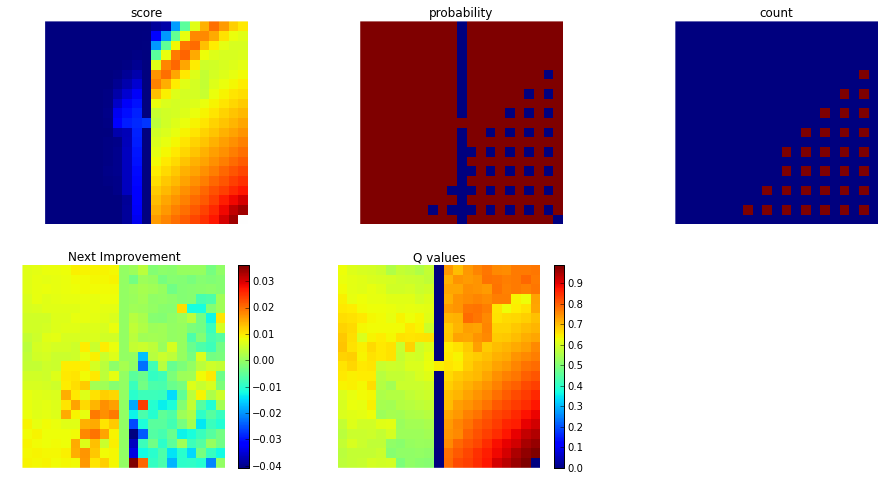

new Q value [ 0.53336008]
it 33


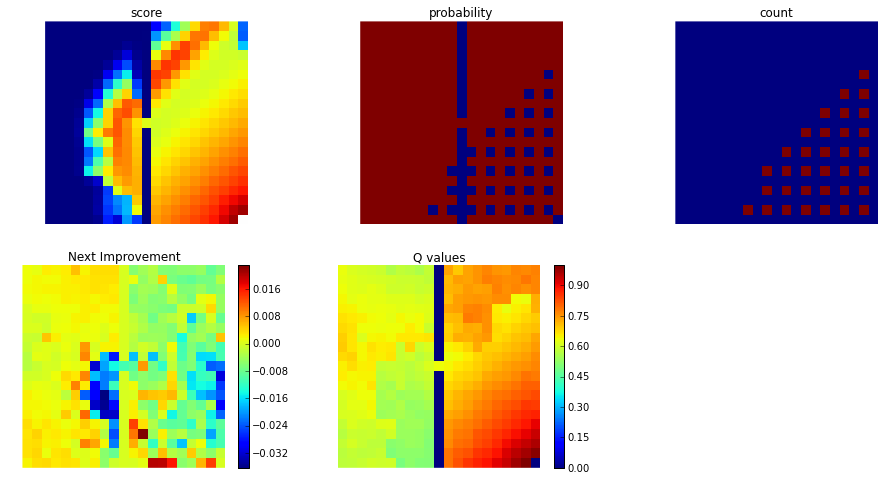

new Q value [ 0.49039967]
it 34


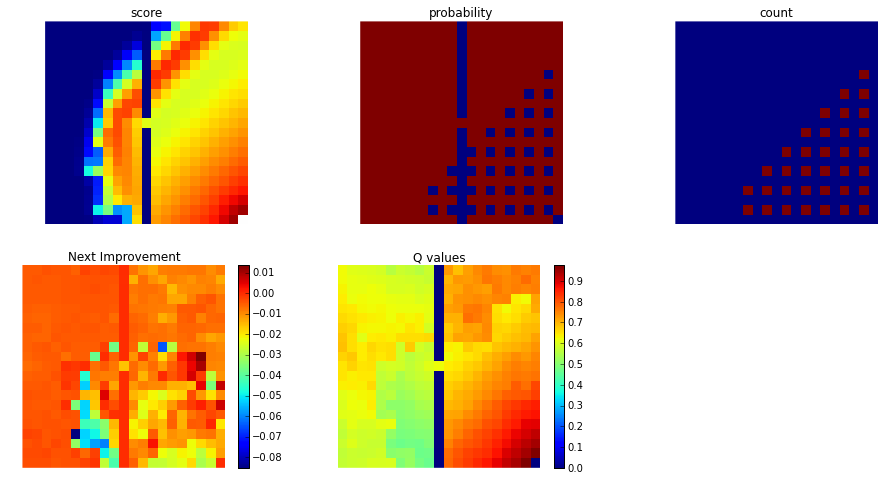

new Q value [ 0.44915015]
it 35


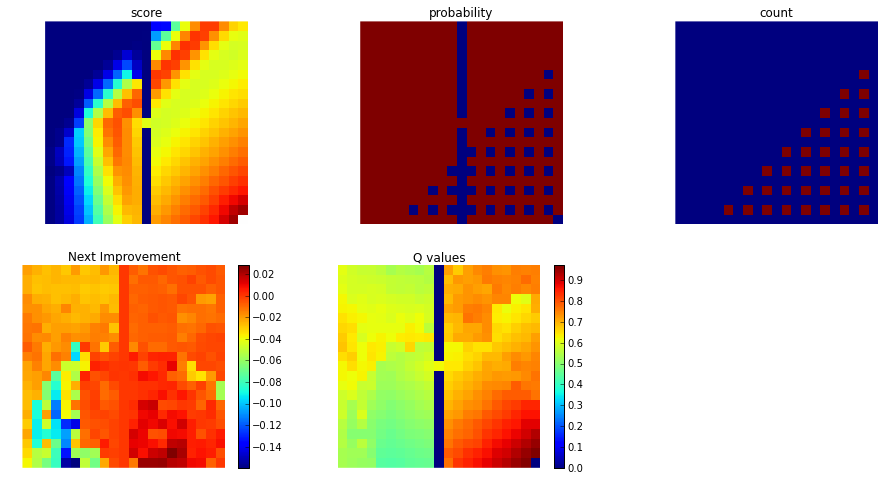

new Q value [ 0.64931819]
it 36


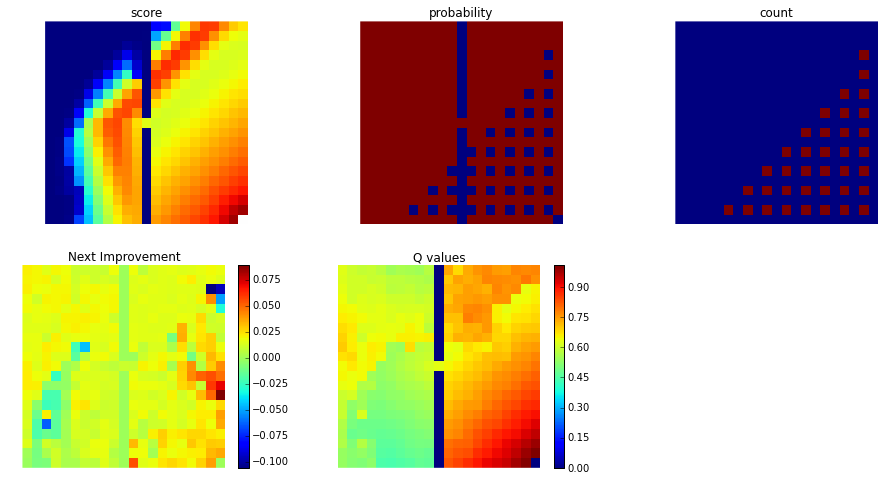

new Q value [ 0.6517281]
it 37


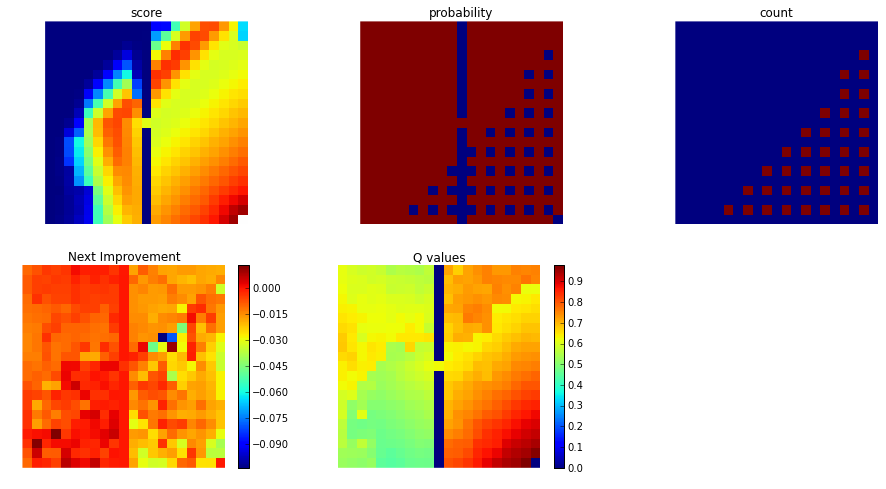

new Q value [ 0.66867666]
it 38


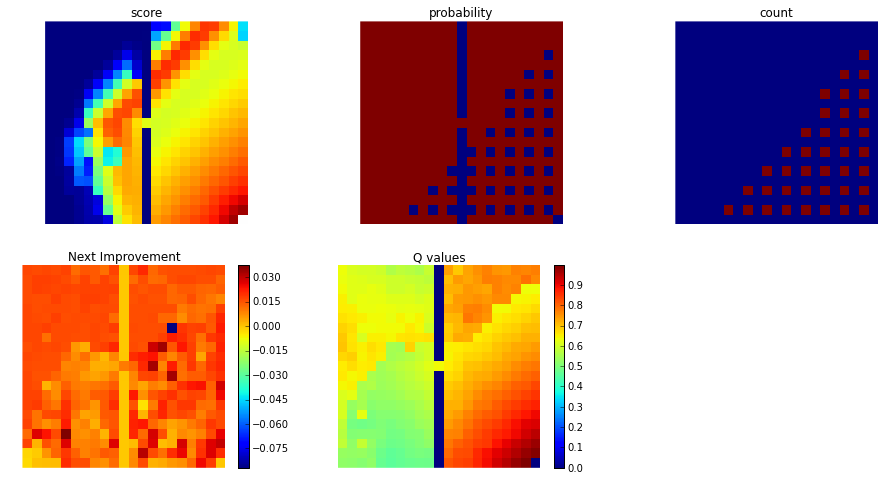

new Q value [ 0.66345065]
it 39


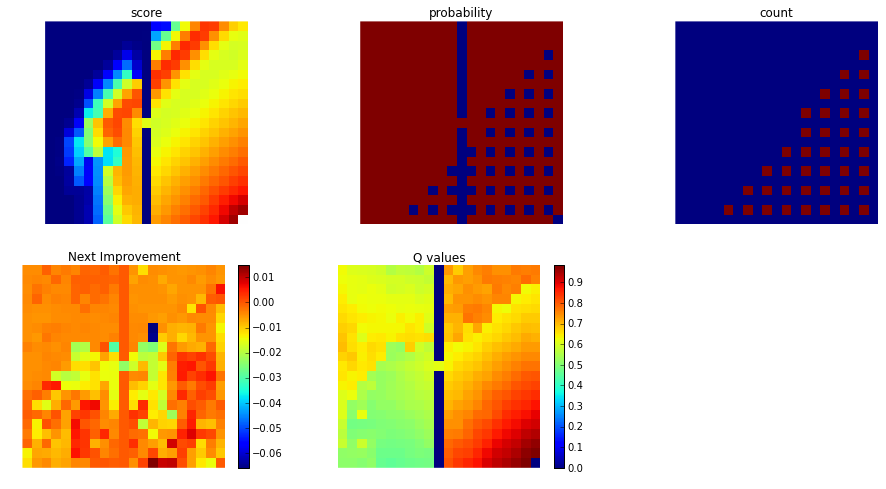

new Q value [ 0.66998818]
it 40


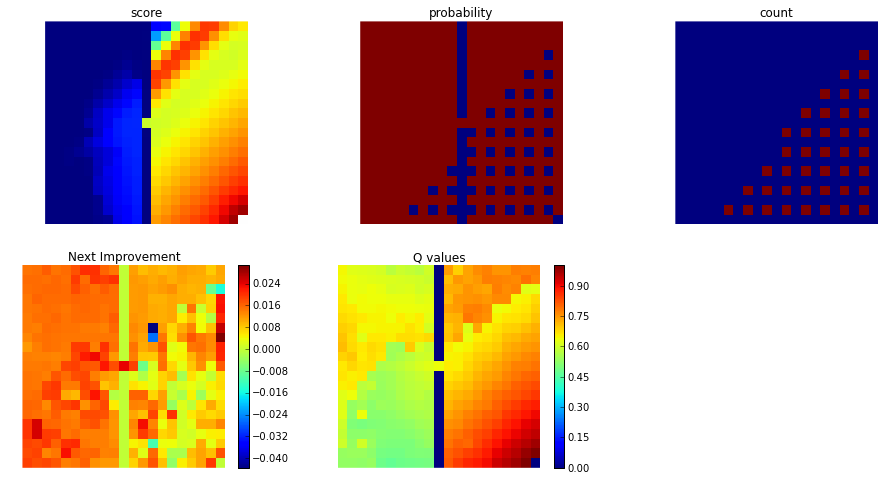

new Q value [ 0.56364219]
it 41


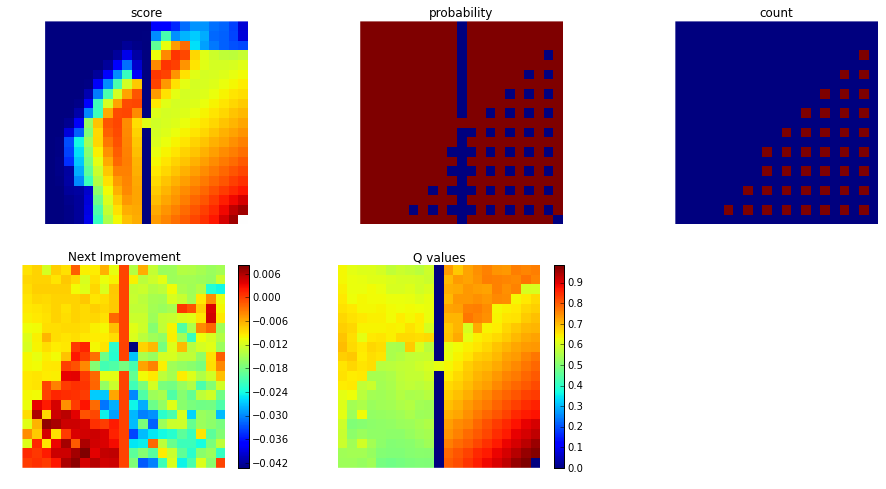

new Q value [ 0.51873405]
it 42


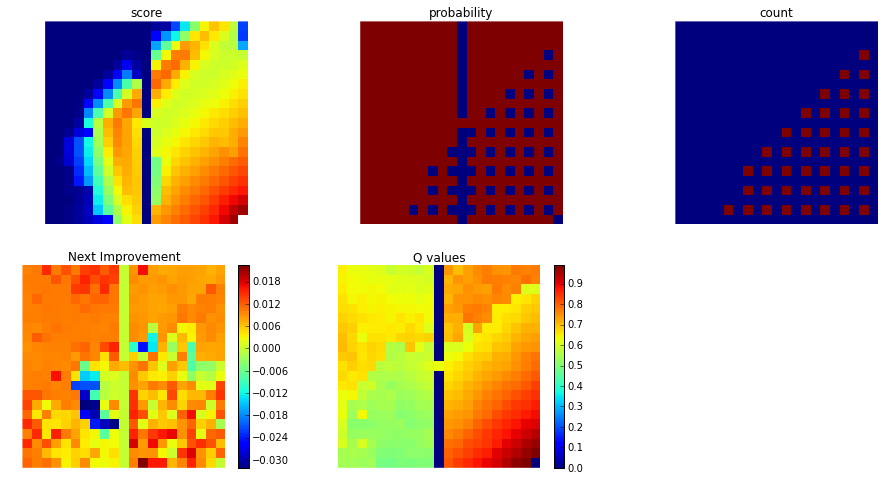

new Q value [ 0.47417831]
it 43


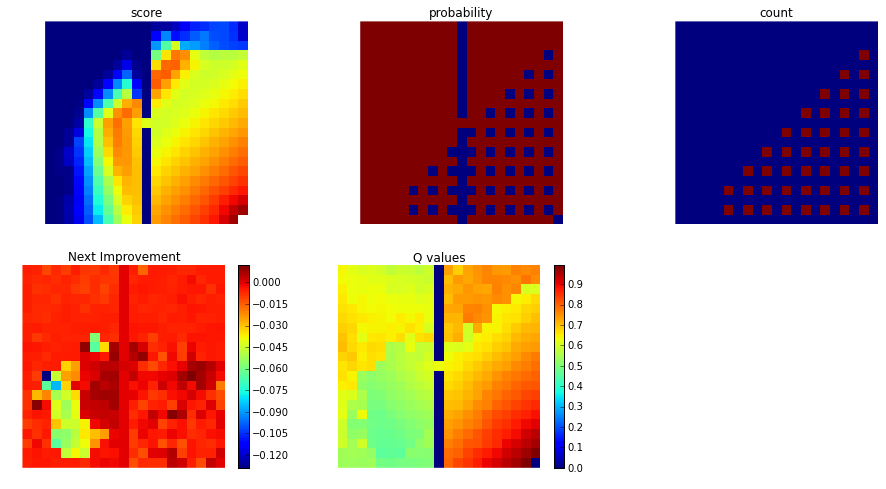

new Q value [ 0.42603835]
it 44


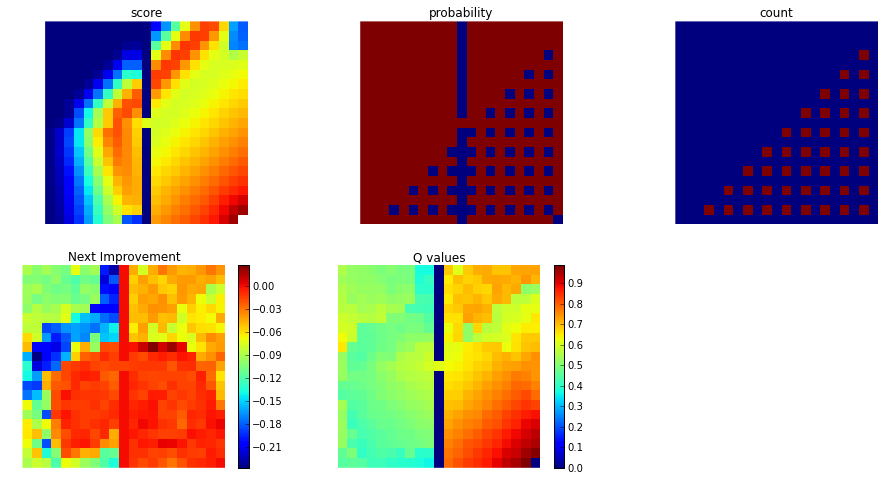

new Q value [ 0.60177053]
it 45


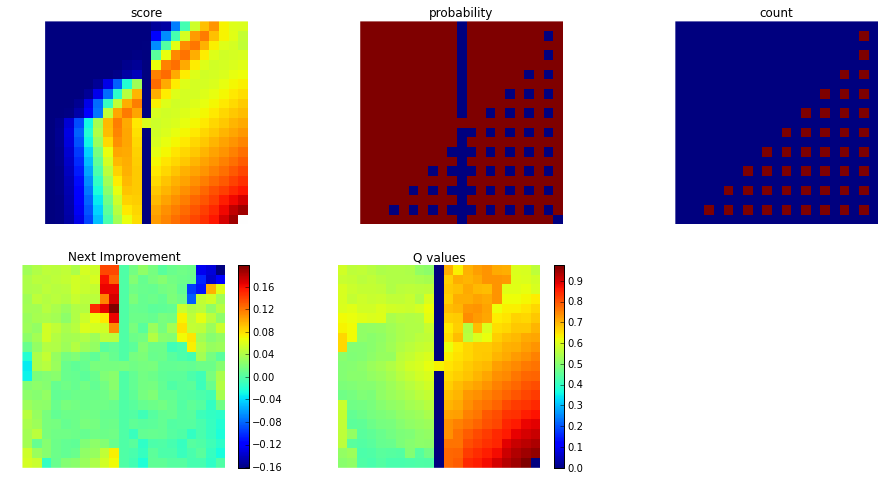

new Q value [ 0.6176475]
it 46


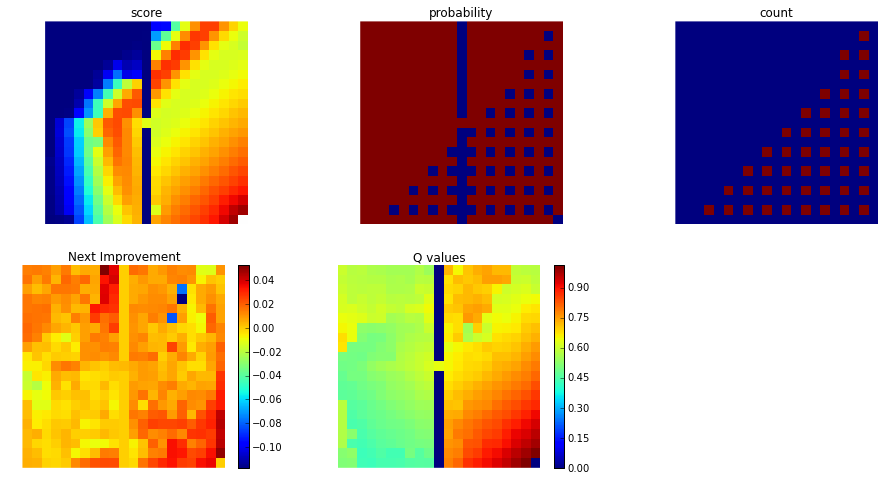

new Q value [ 0.63549054]
it 47


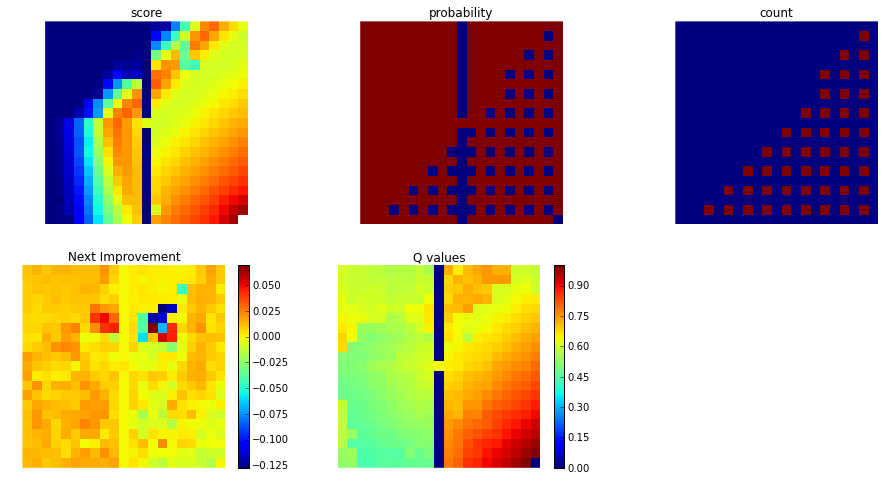

new Q value [ 0.63167477]
it 48


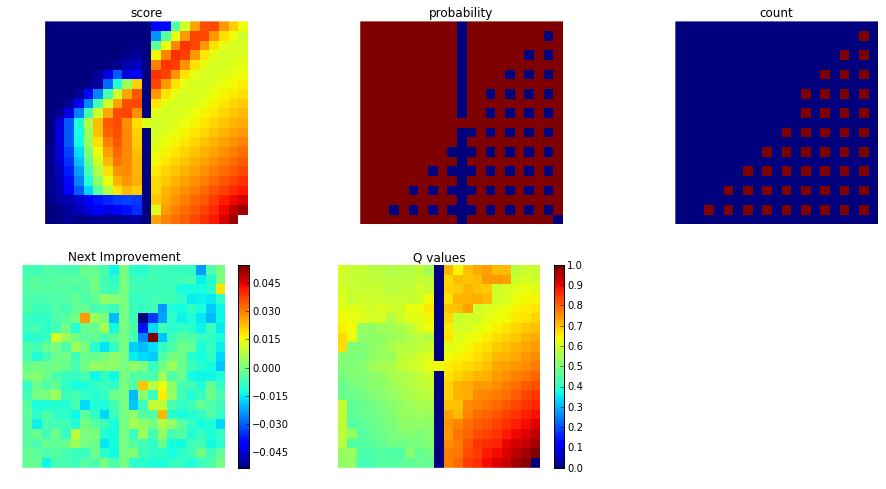

new Q value [ 0.63418165]
it 49


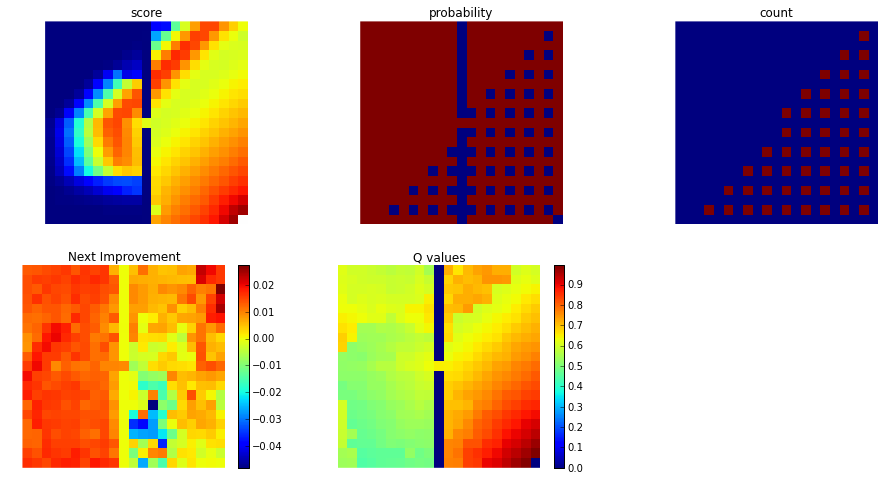

new Q value [ 0.58712717]
it 50


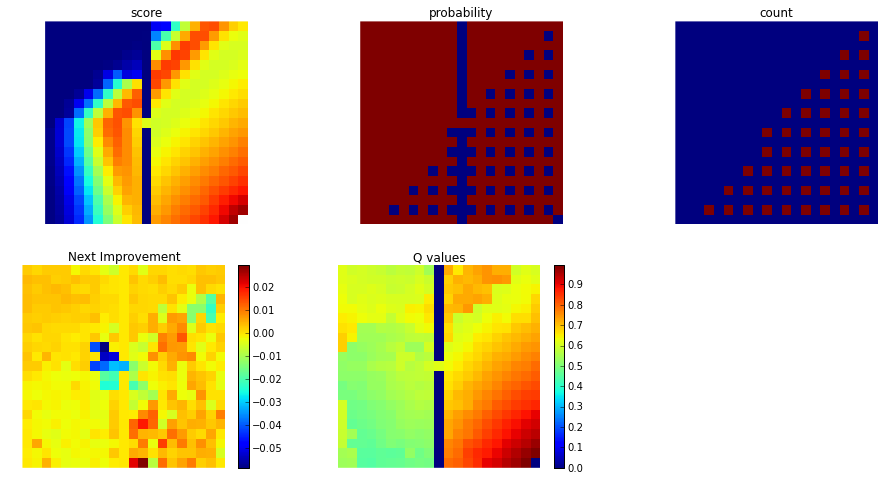

new Q value [ 0.53990388]
it 51


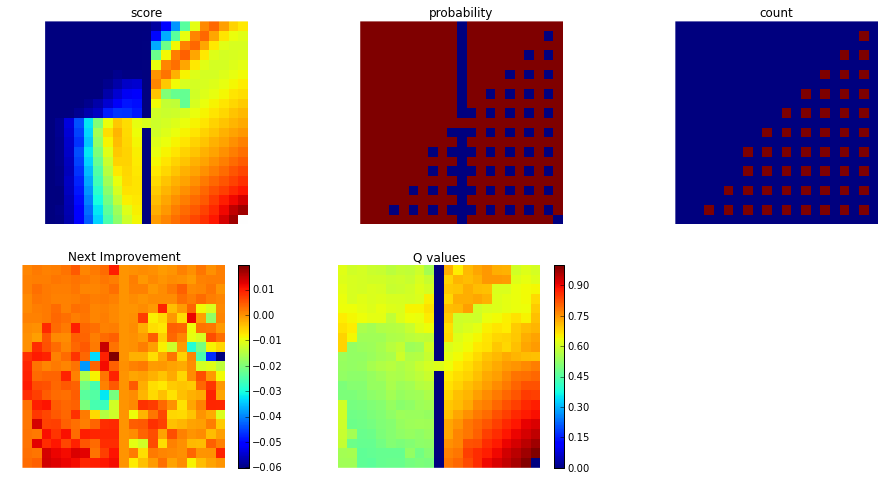

new Q value [ 0.49775895]
it 52


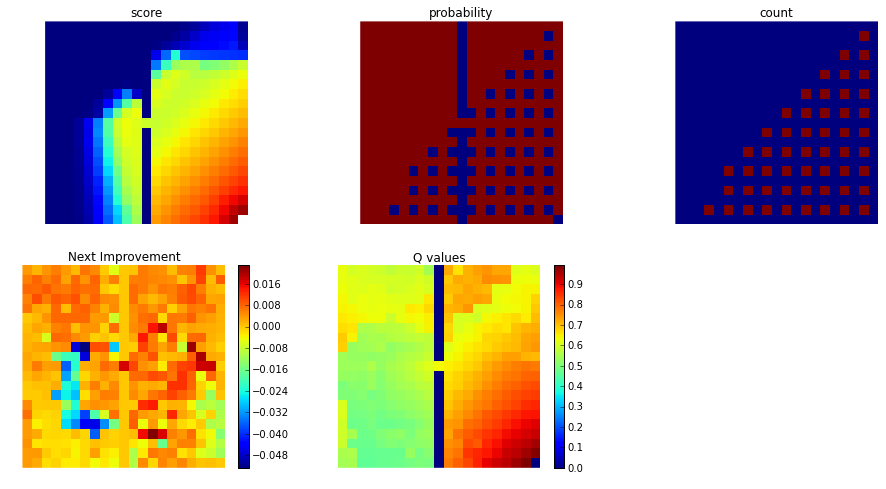

new Q value [ 0.45216809]
it 53


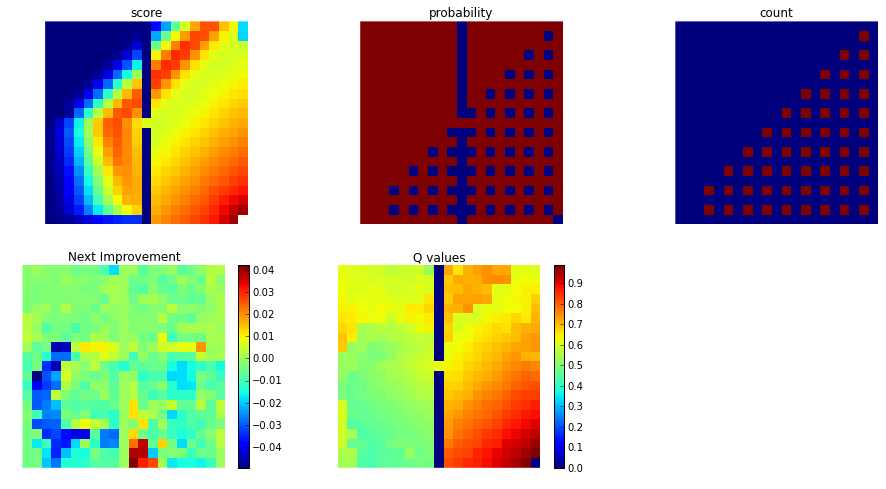

new Q value [ 0.406714]
it 54


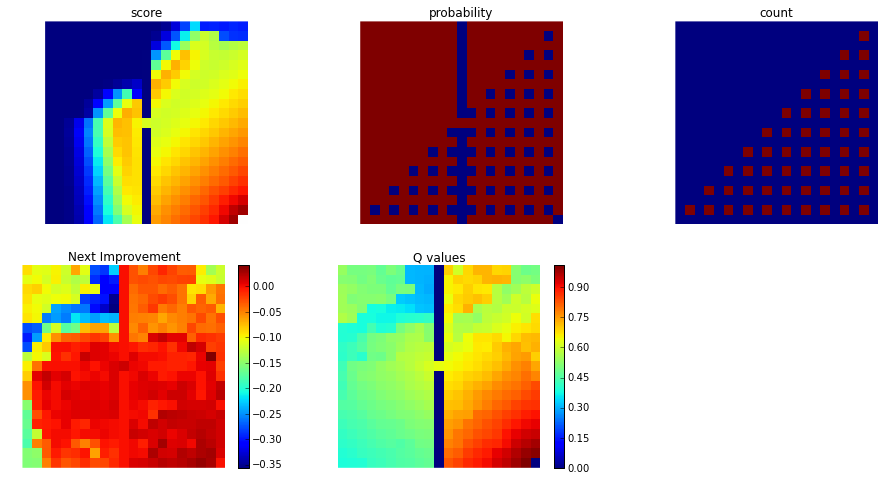

new Q value [ 0.5891239]
it 55


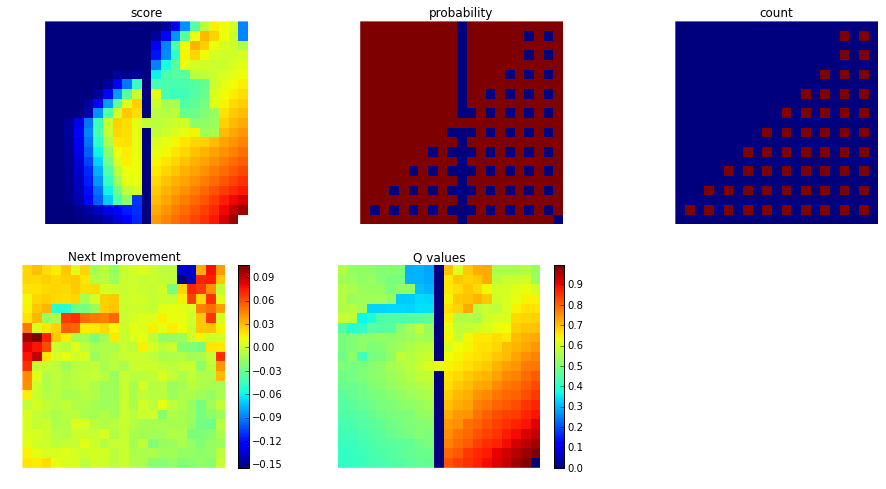

new Q value [ 0.59726643]
it 56


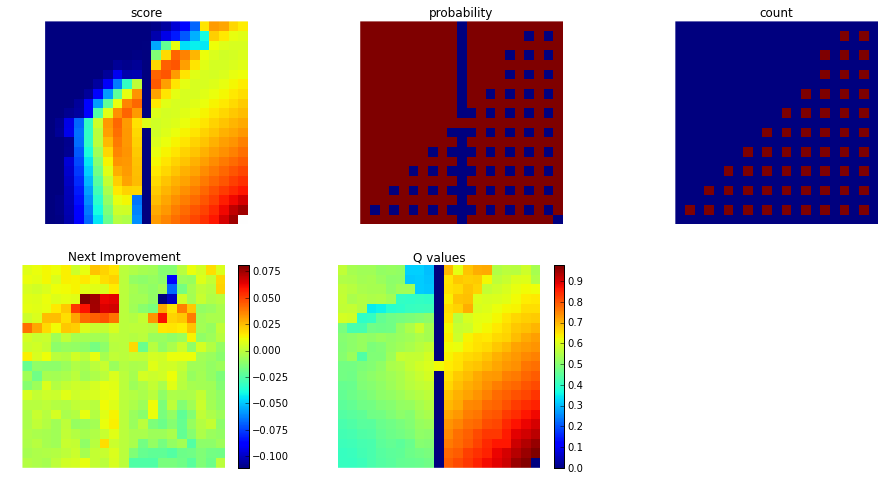

new Q value [ 0.5989794]
it 57


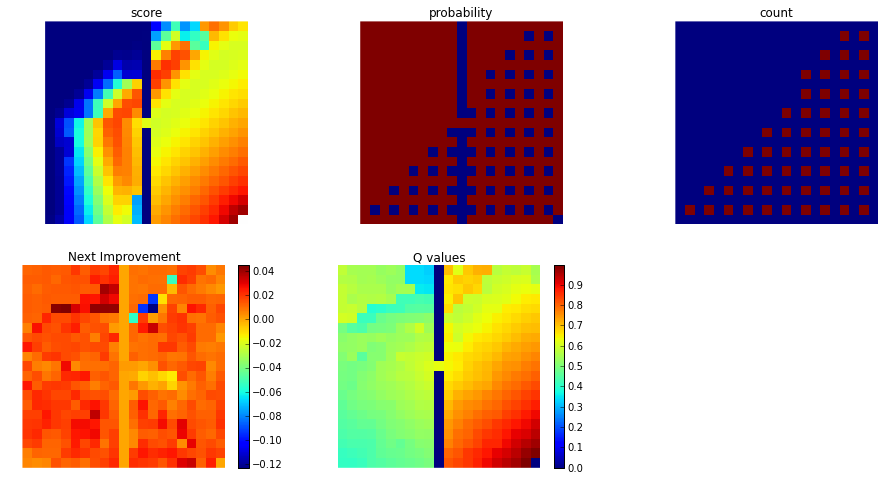

new Q value [ 0.59038704]
it 58


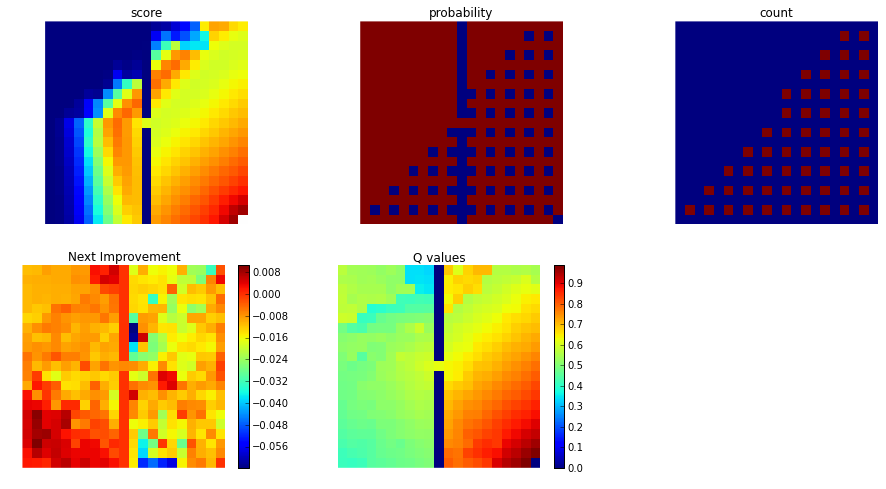

new Q value [ 0.59507085]
it 59


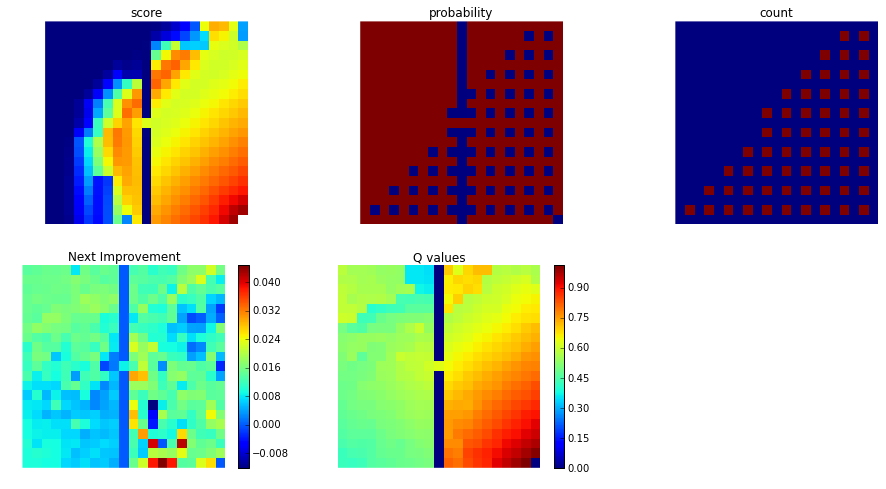

new Q value [ 0.56164486]
it 60


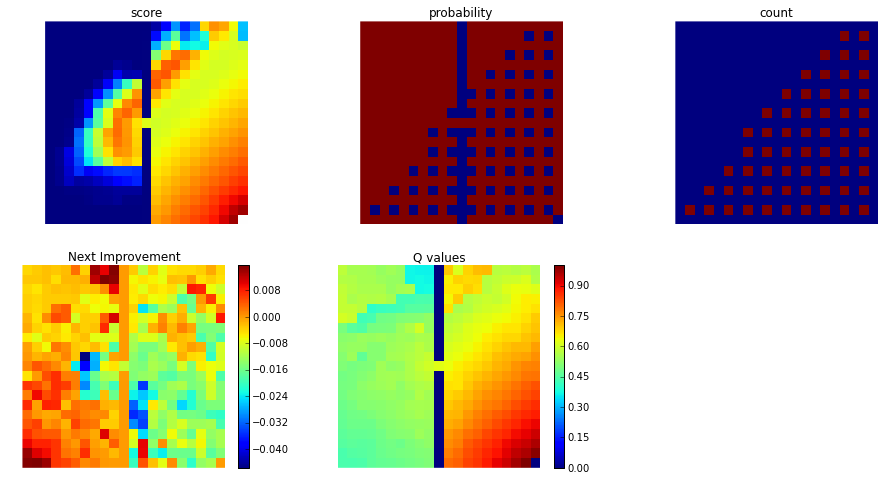

new Q value [ 0.51435095]
it 61


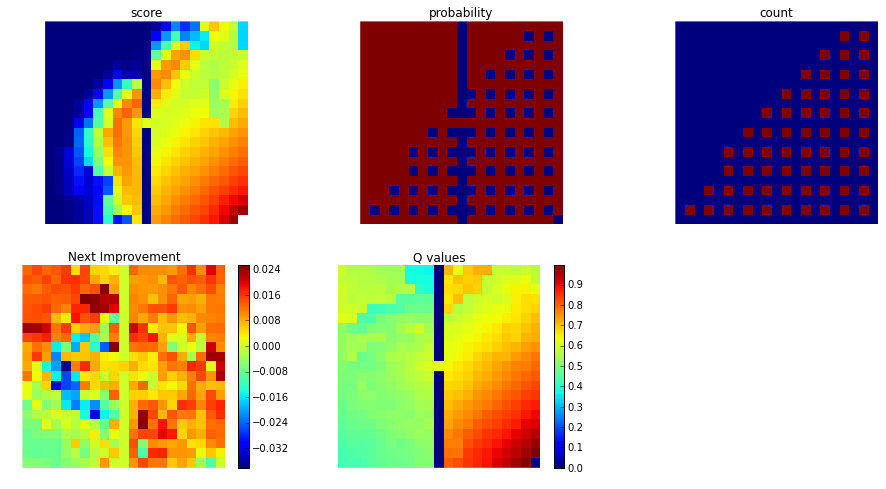

new Q value [ 0.47428673]
it 62


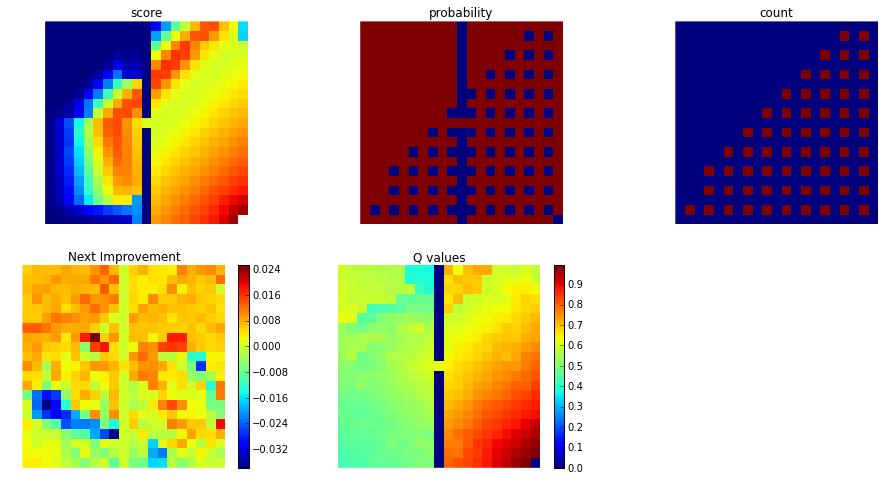

new Q value [ 0.42429857]
it 63


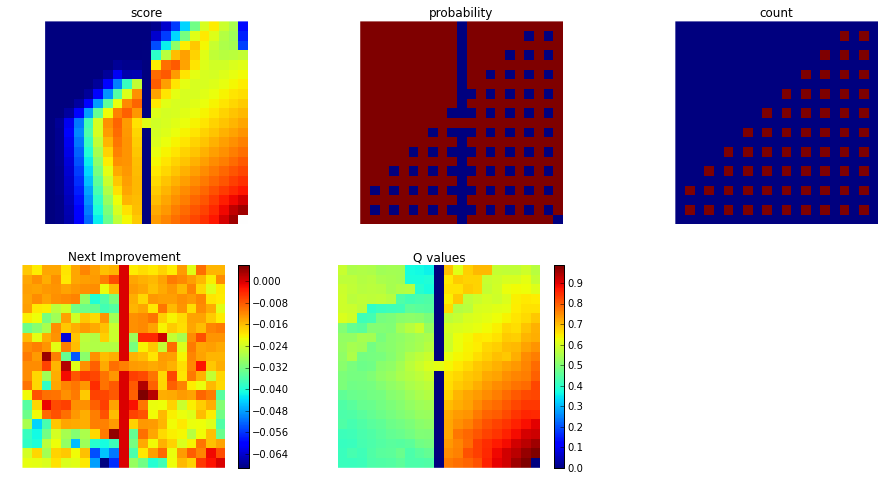

new Q value [ 0.56995285]
it 64


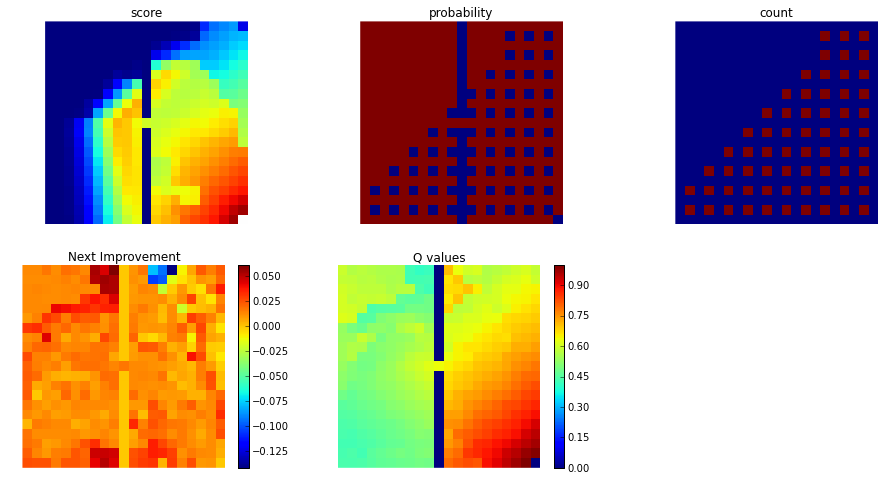

new Q value [ 0.5657727]
it 65


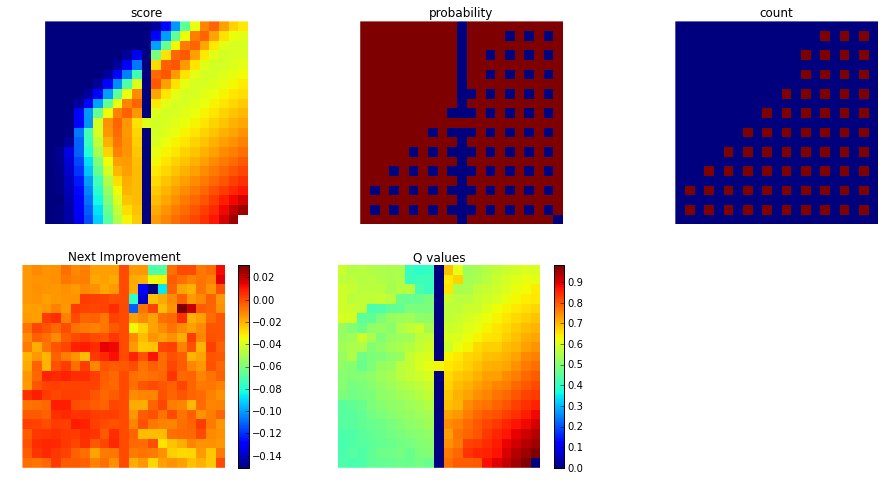

new Q value [ 0.58224509]
it 66


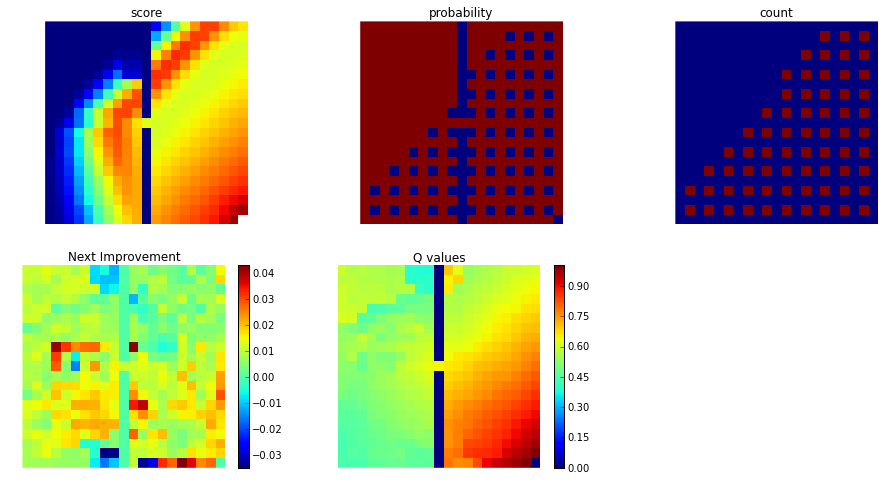

new Q value [ 0.56765707]
it 67


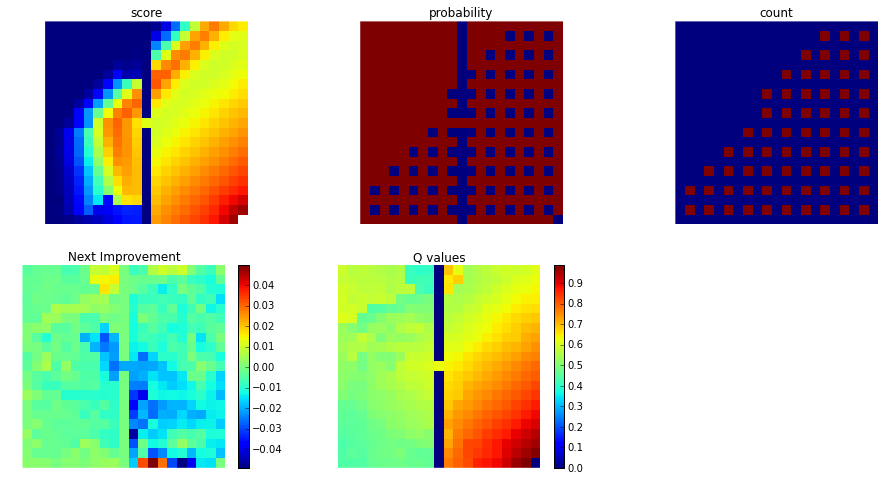

new Q value [ 0.57000997]
it 68


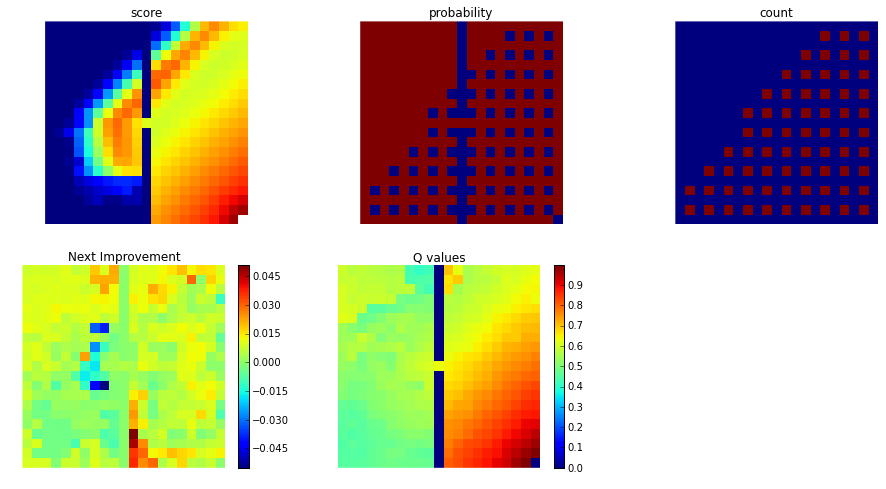

new Q value [ 0.54455809]
it 69


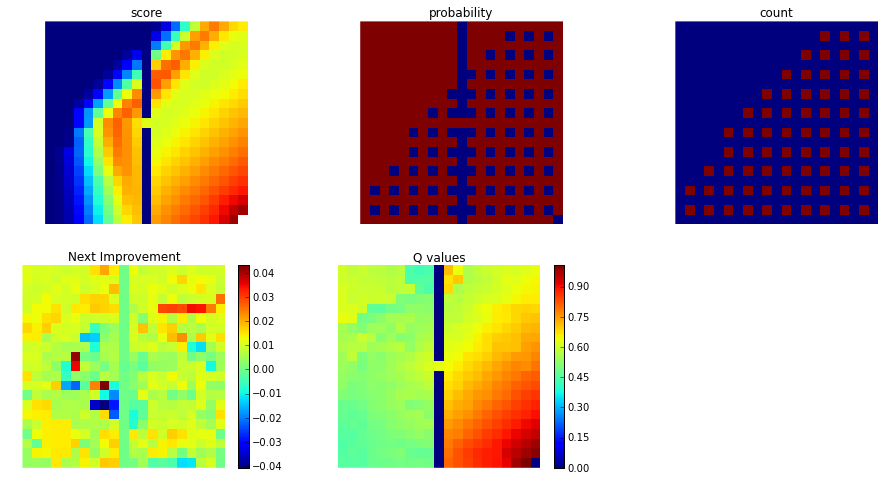

new Q value [ 0.48873988]
it 70


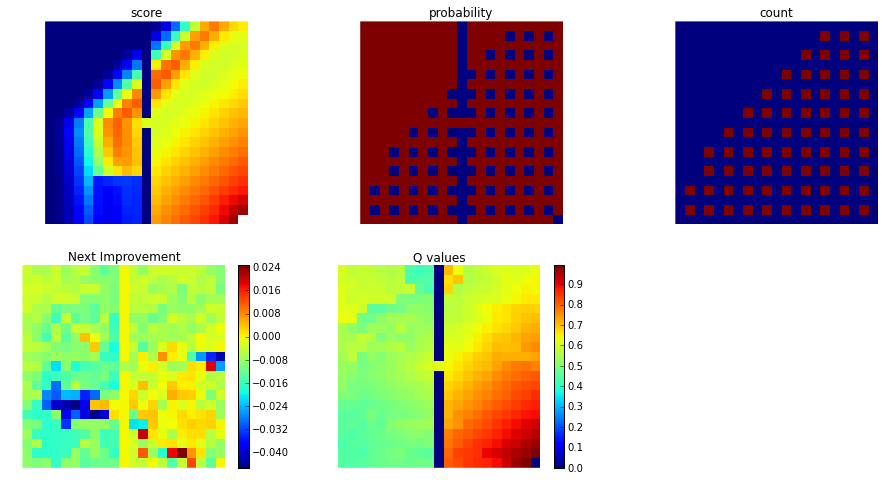

new Q value [ 0.45334192]
it 71


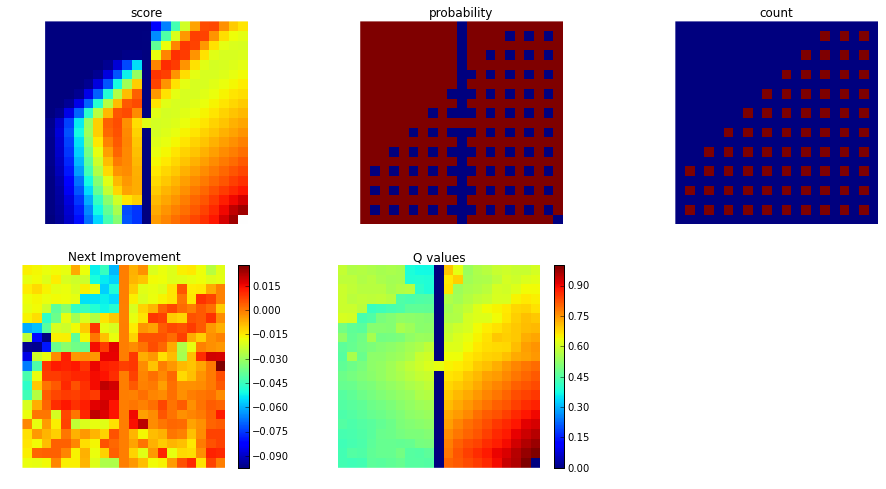

new Q value [ 0.53891924]
it 72


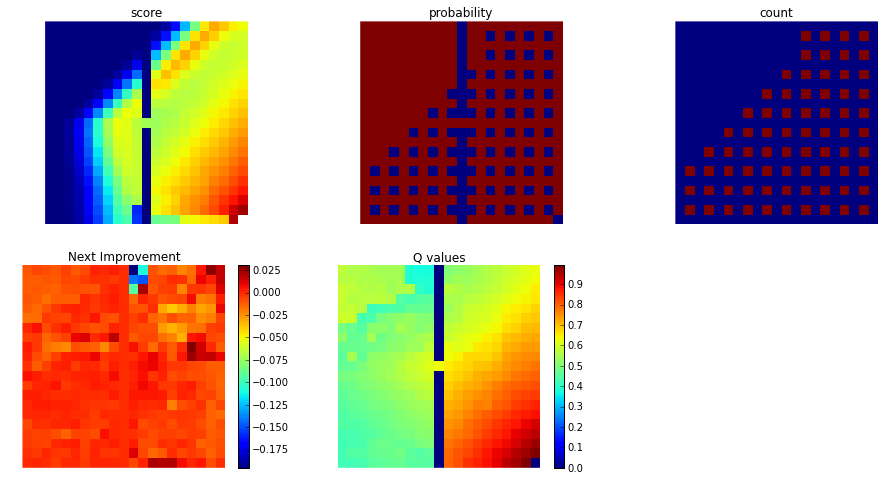

new Q value [ 0.5356141]
it 73


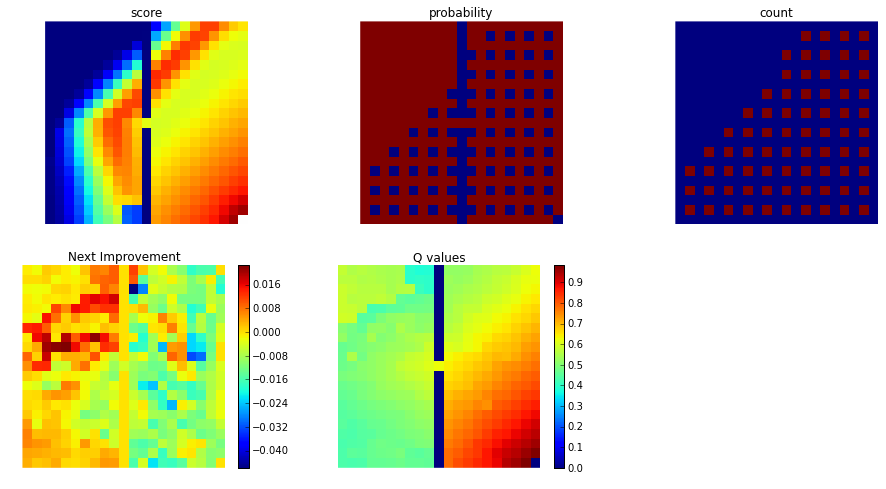

new Q value [ 0.54619666]
it 74


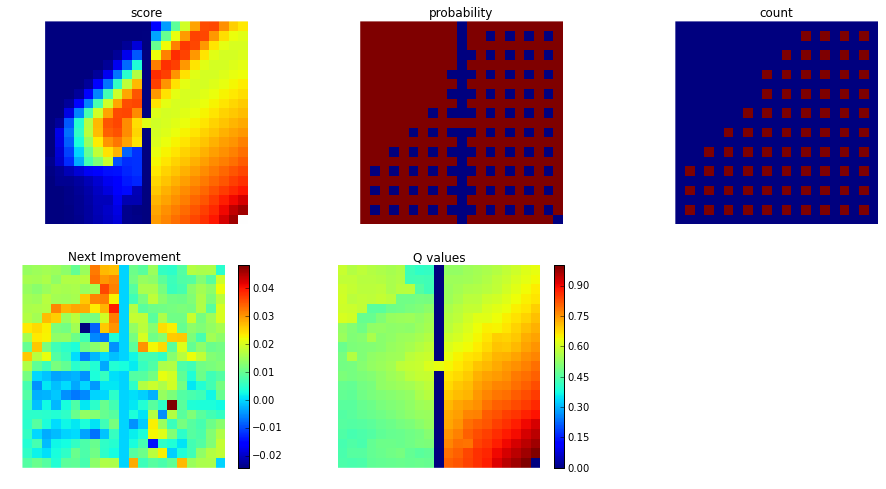

new Q value [ 0.54379887]
it 75


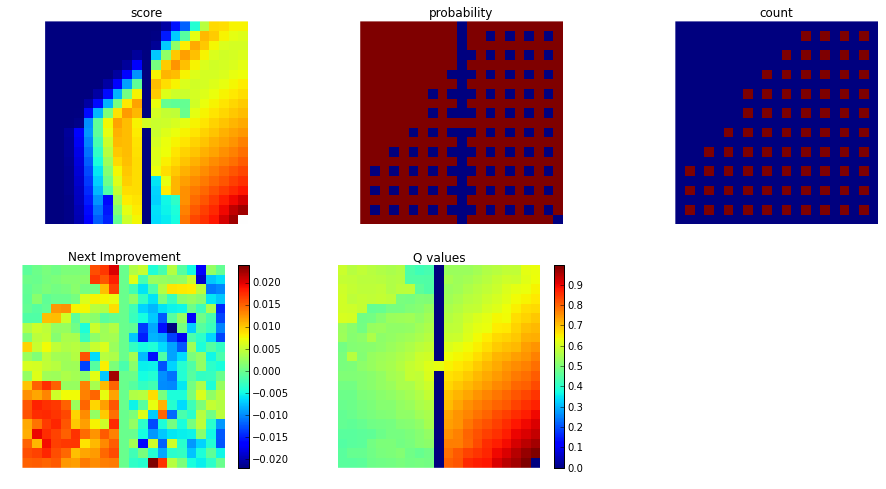

new Q value [ 0.53534178]
it 76


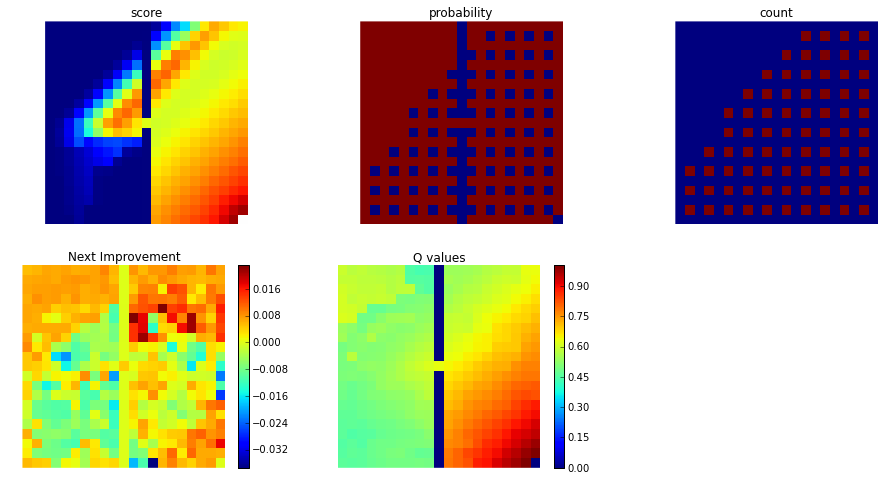

new Q value [ 0.49976971]
it 77


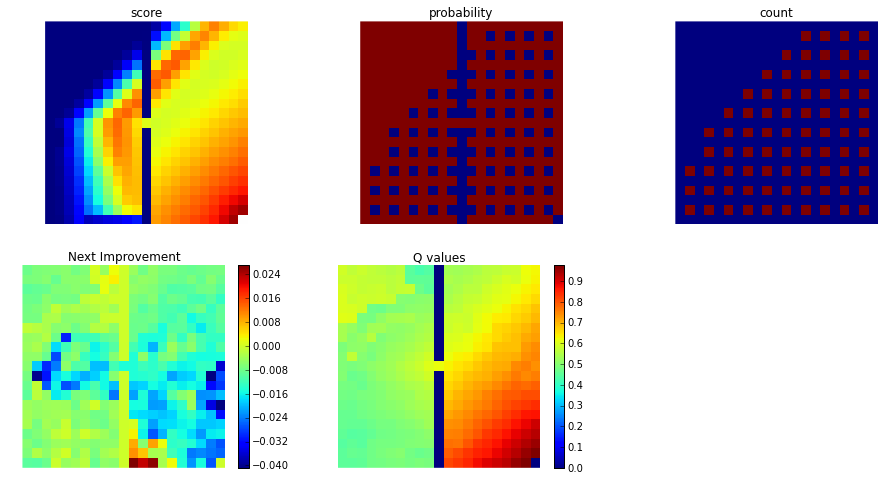

new Q value [ 0.48511856]
it 78


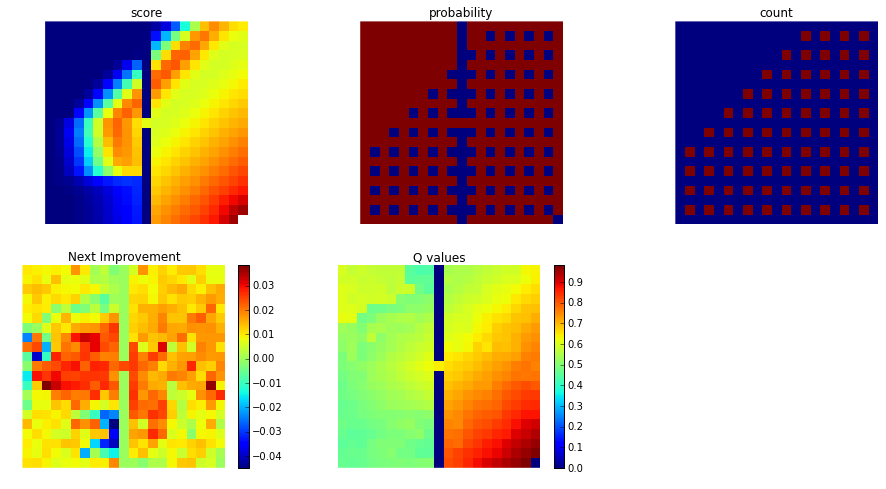

new Q value [ 0.52187741]
it 79


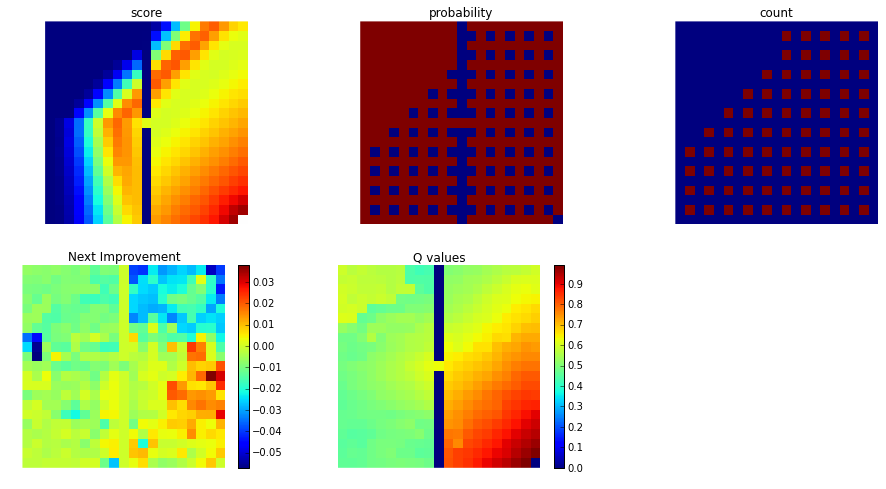

new Q value [ 0.51459571]
it 80


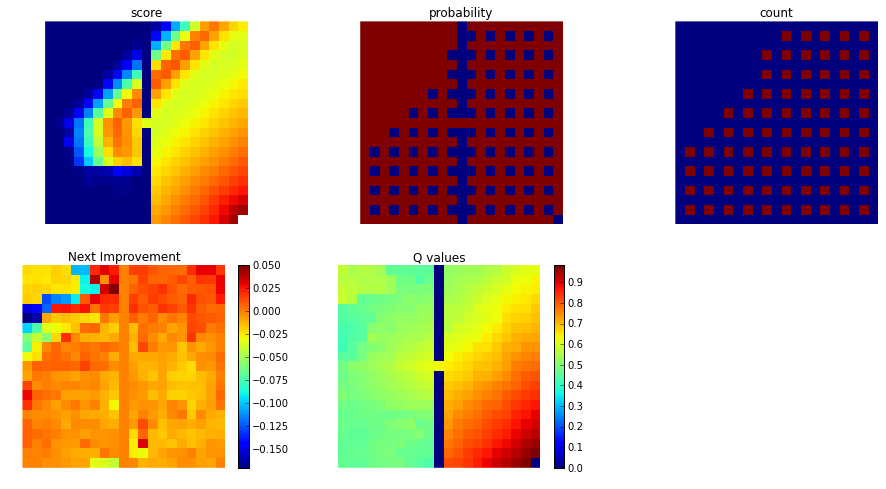

new Q value [ 0.50730496]
it 81


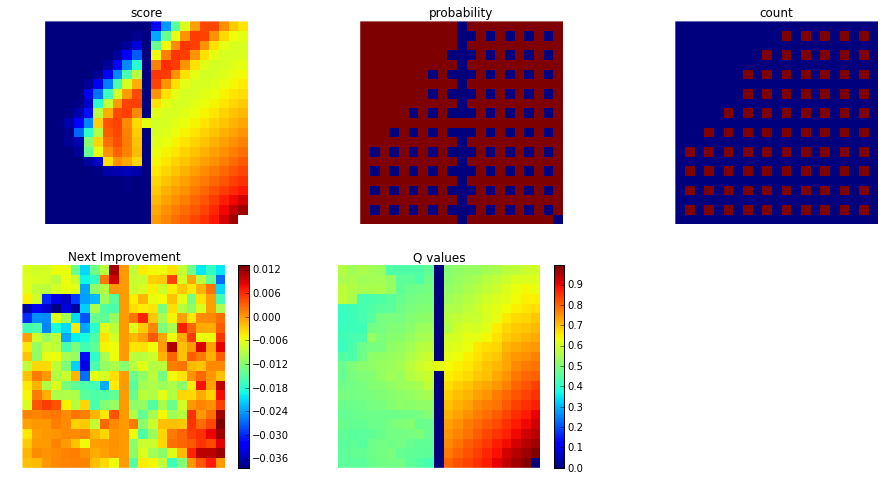

new Q value [ 0.51331125]
it 82


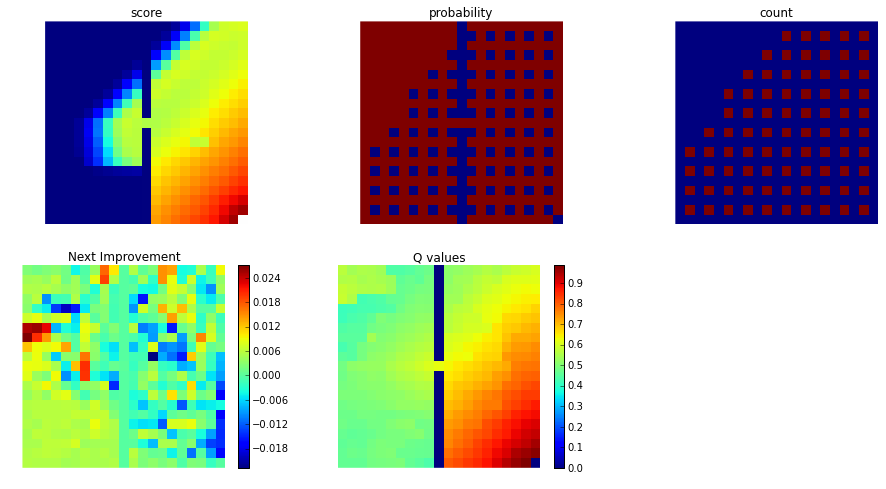

new Q value [ 0.51168139]
it 83


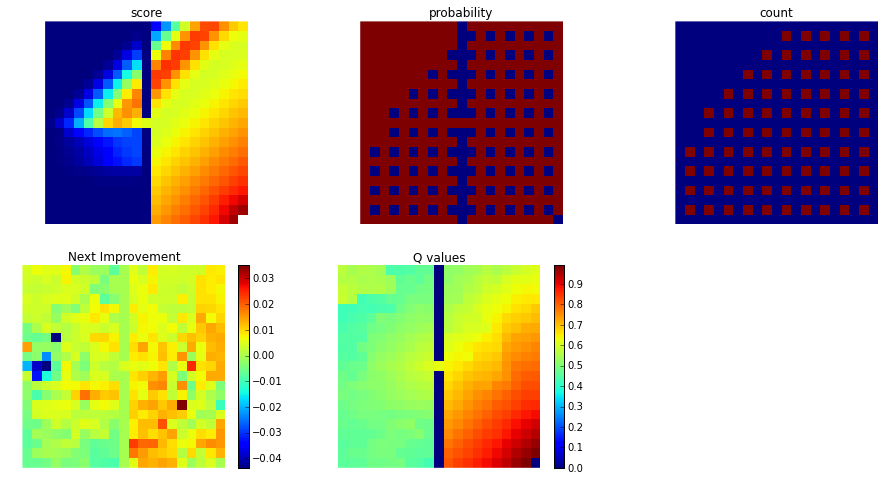

new Q value [ 0.48371831]
it 84


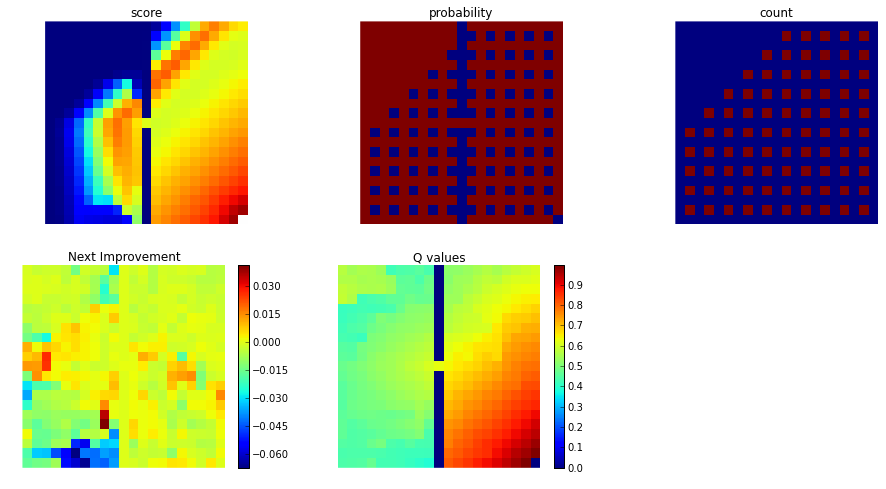

new Q value [ 0.47278333]
it 85


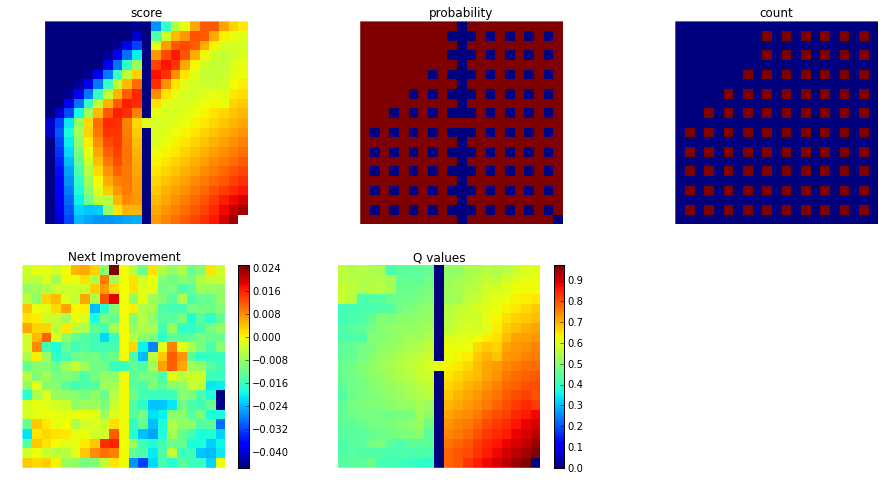

new Q value [ 0.49497196]
it 86


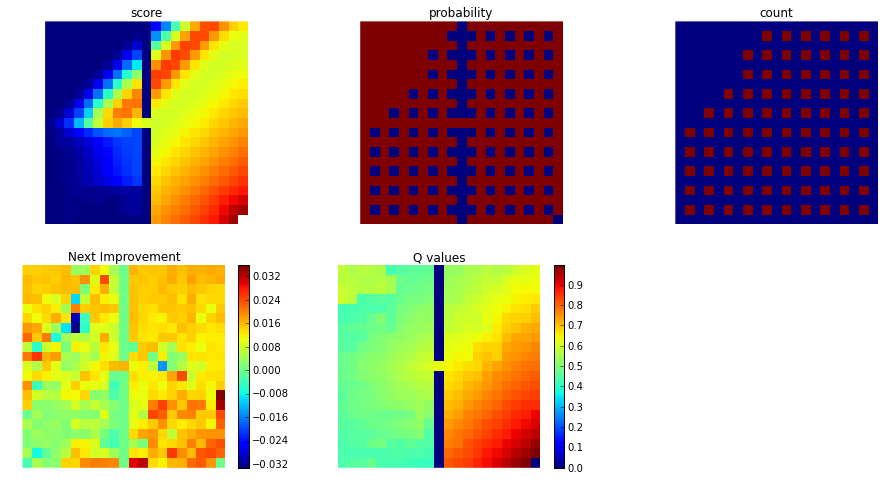

new Q value [ 0.48563782]
it 87


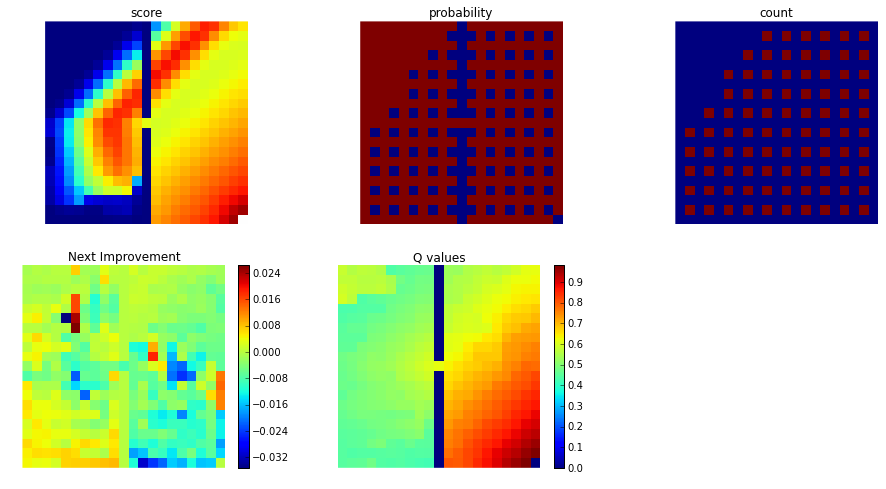

new Q value [ 0.50369541]
it 88


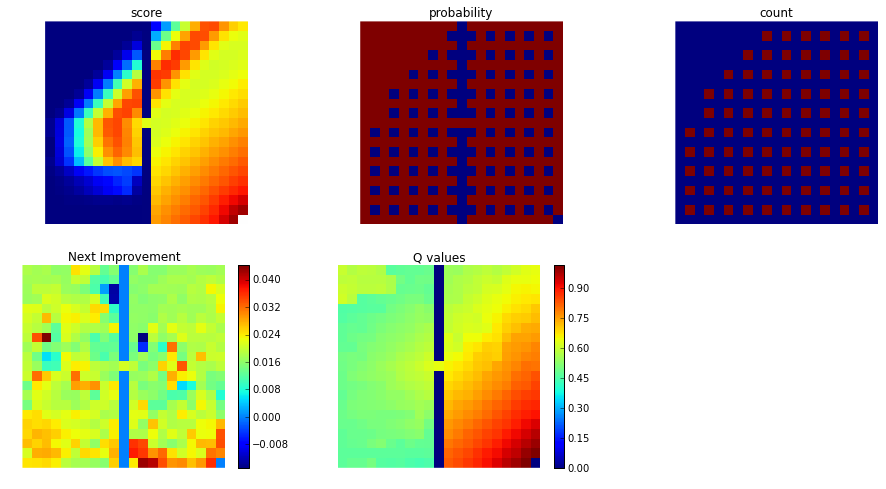

new Q value [ 0.48255247]
it 89


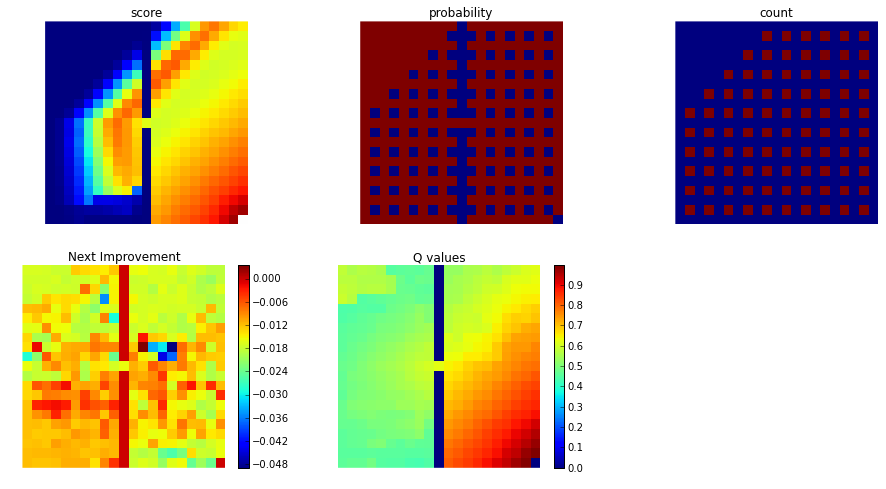

new Q value [ 0.46861686]
it 90


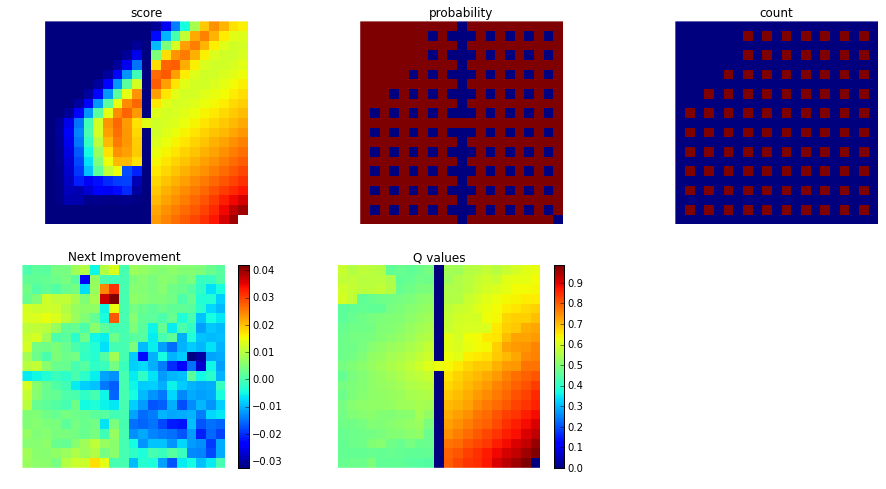

new Q value [ 0.46280284]
it 91


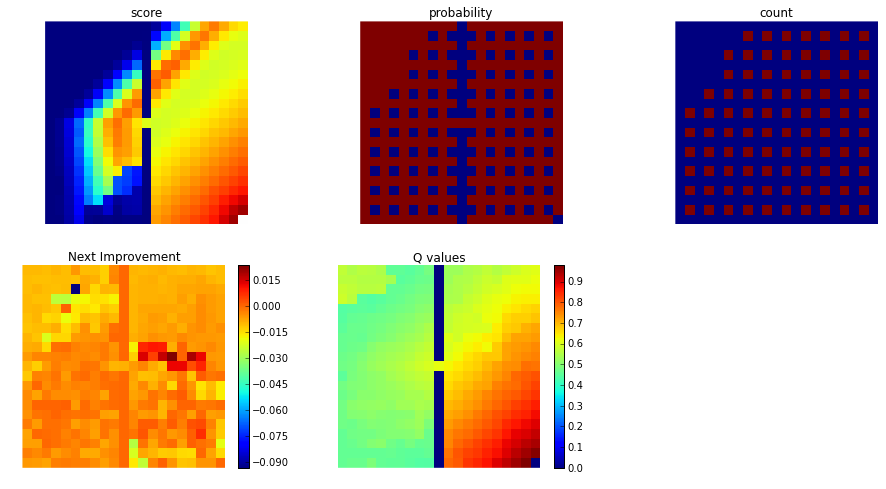

new Q value [ 0.47117713]
it 92


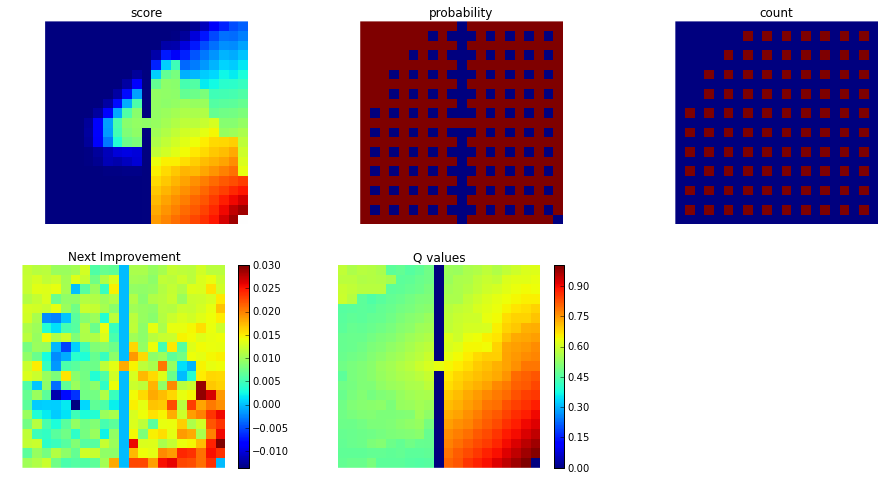

new Q value [ 0.4691968]
it 93


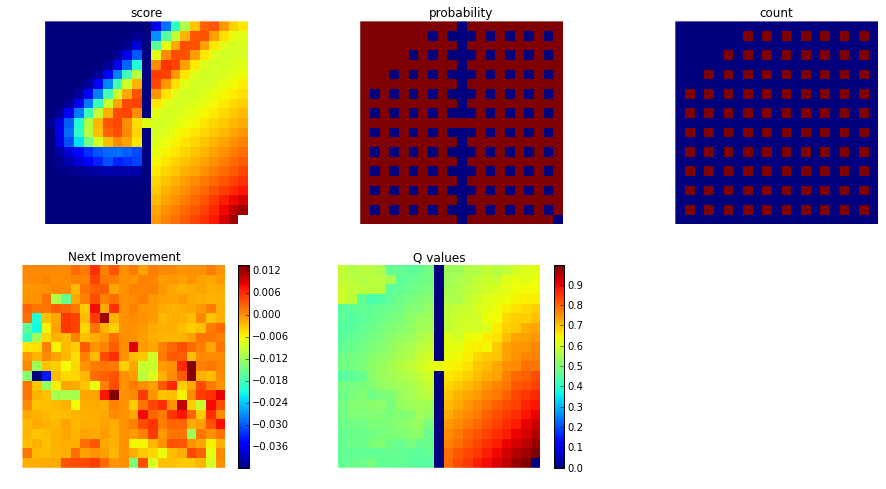

new Q value [ 0.44028991]
it 94


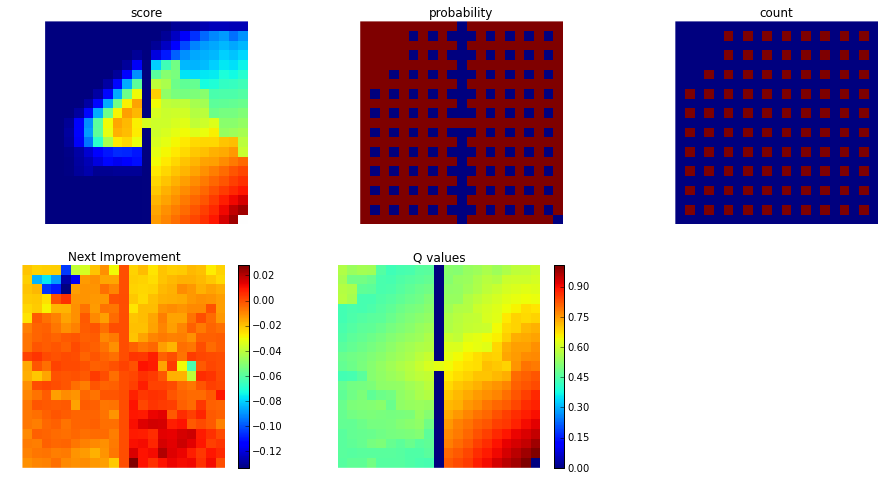

new Q value [ 0.44744391]
it 95


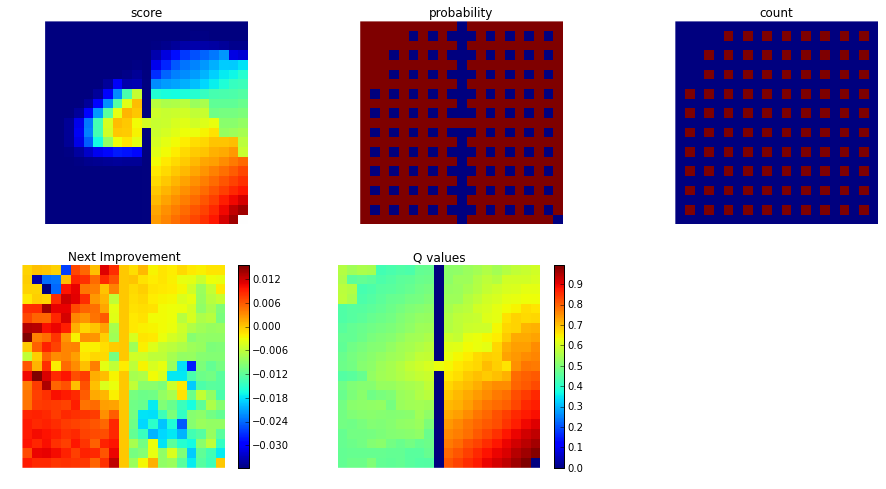

new Q value [ 0.44977044]
it 96


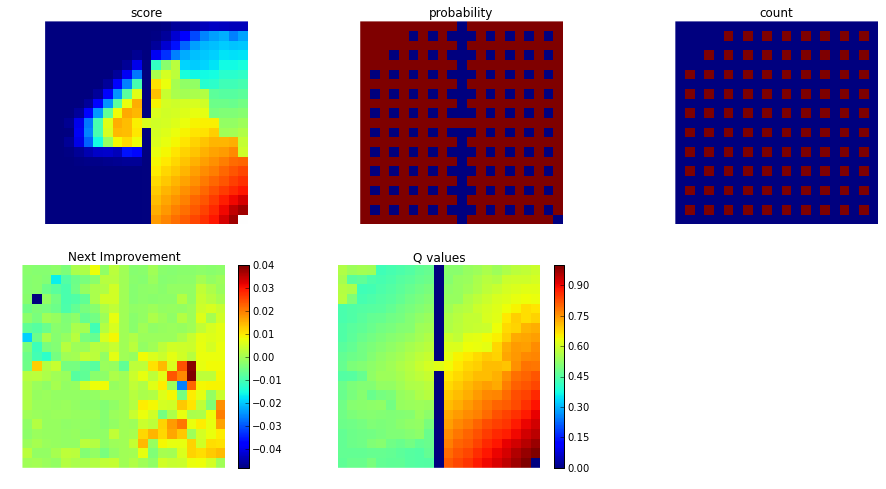

new Q value [ 0.4190749]
it 97


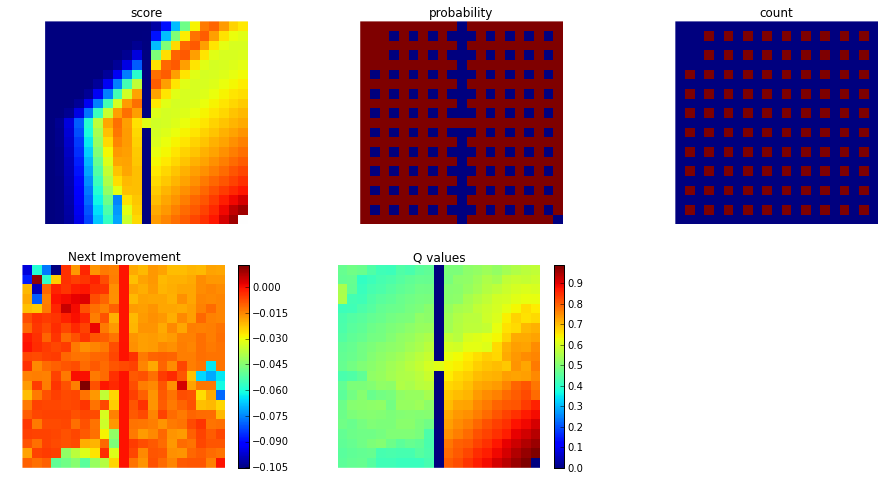

new Q value [ 0.43441952]
it 98


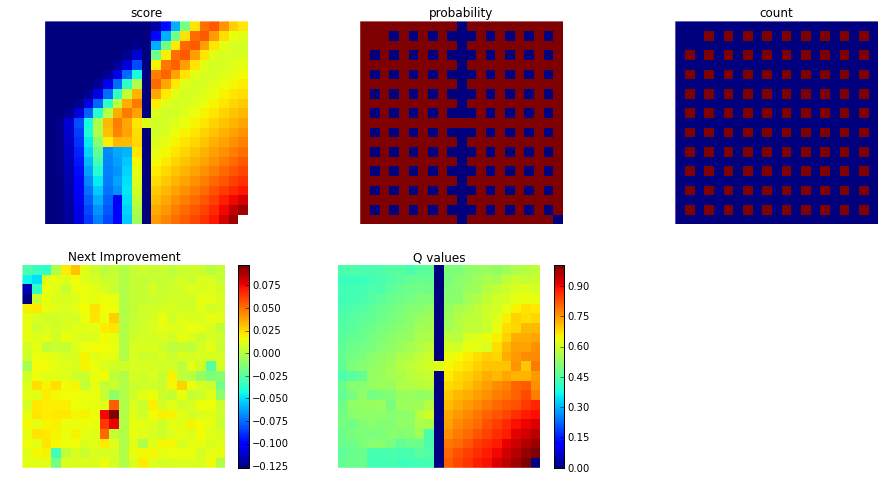

new Q value [ 0.41956622]
it 99


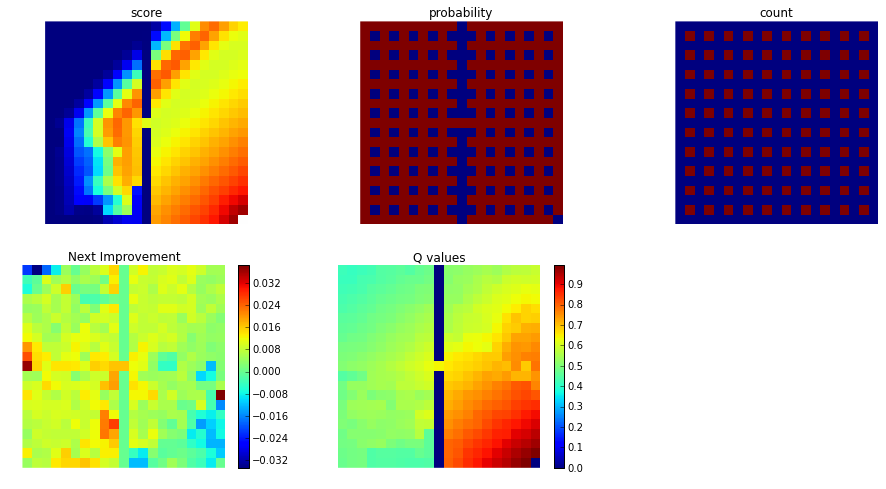

new Q value [ 0.51240968]
it 100


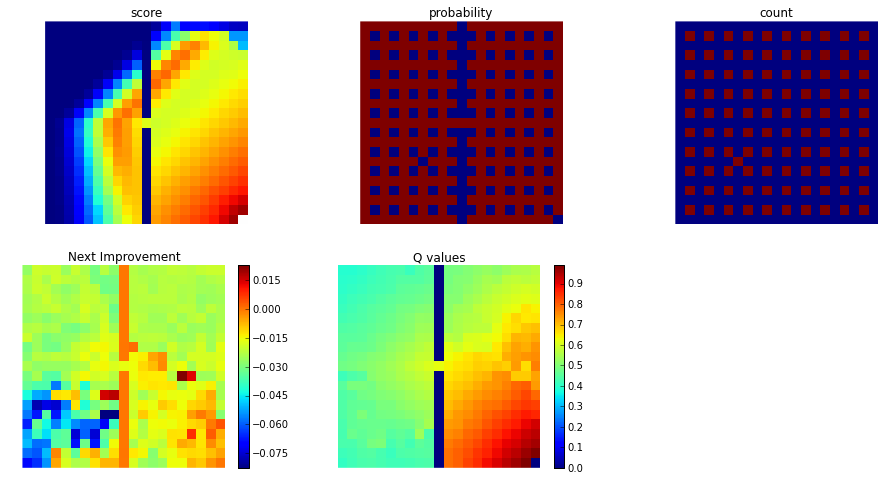

new Q value [ 0.74734674]
it 101


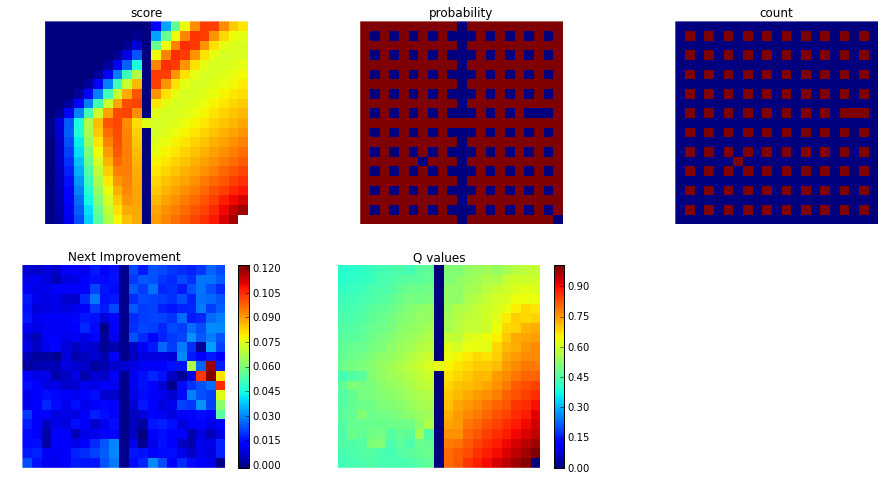

new Q value [ 0.47391264]
it 102


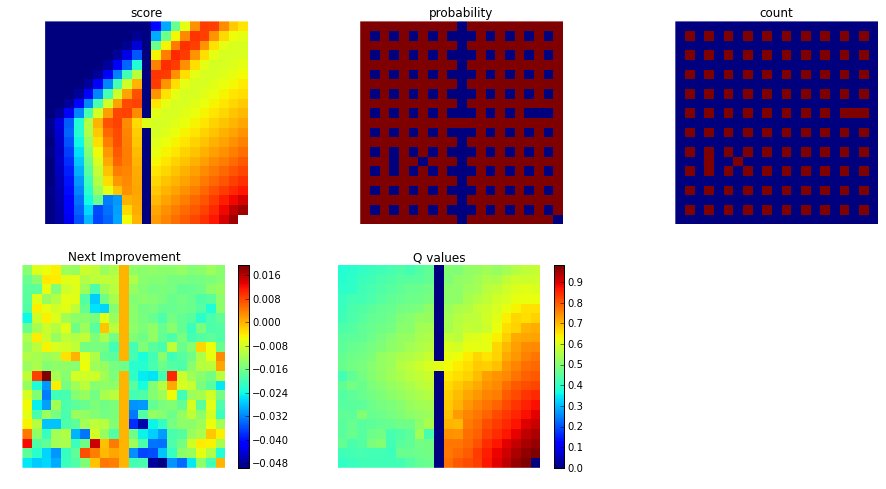

new Q value [ 0.6194894]
it 103


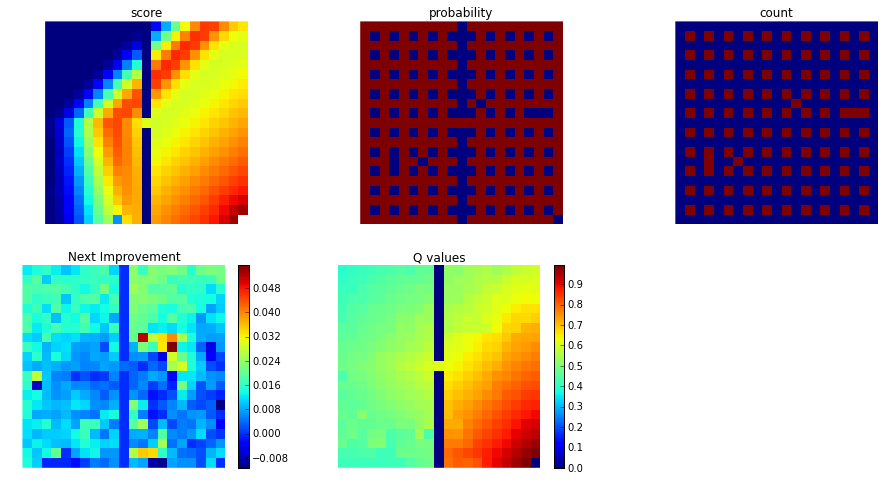

new Q value [ 0.46723021]
it 104


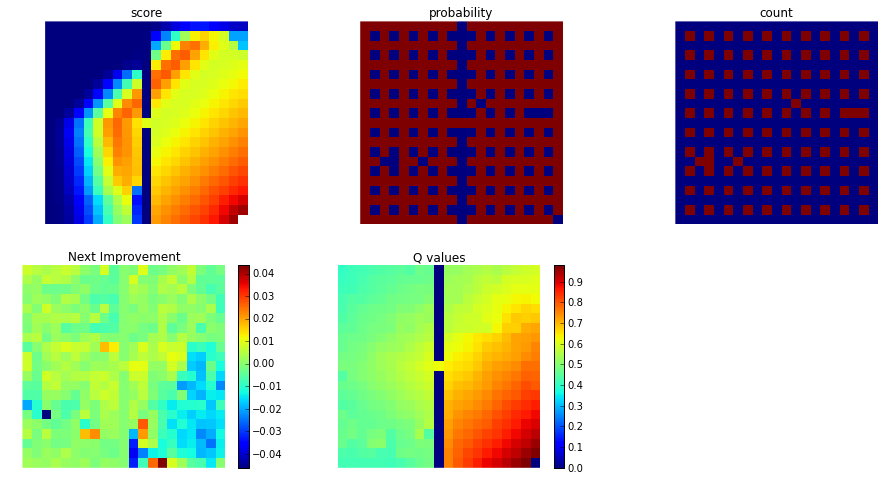

new Q value [ 0.49701505]
it 105


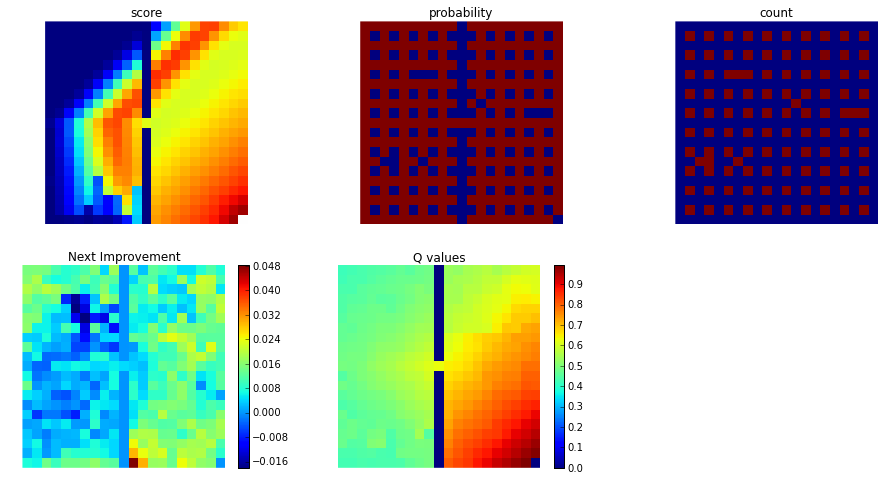

new Q value [ 0.7375461]
it 106


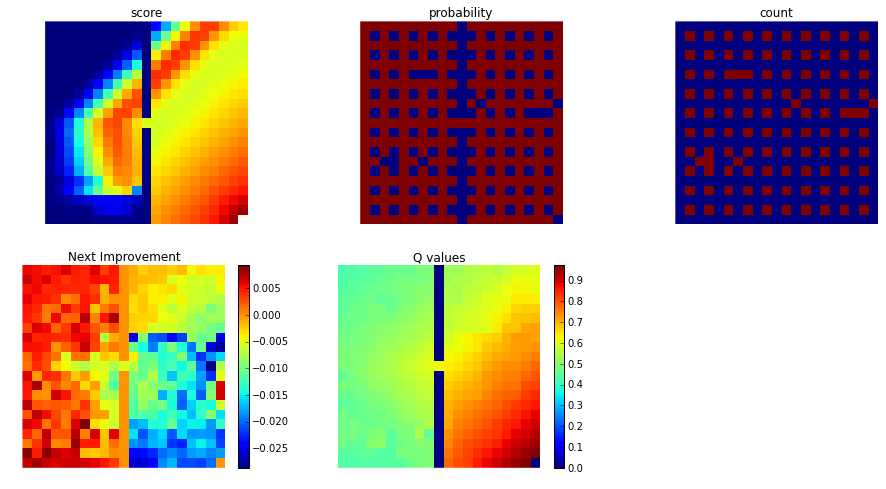

new Q value [ 0.76634362]
it 107


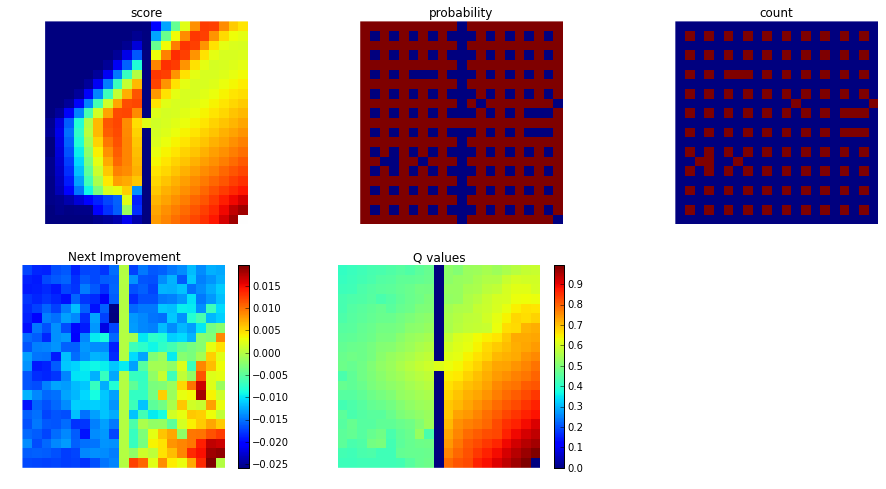

new Q value [ 0.50797606]
it 108


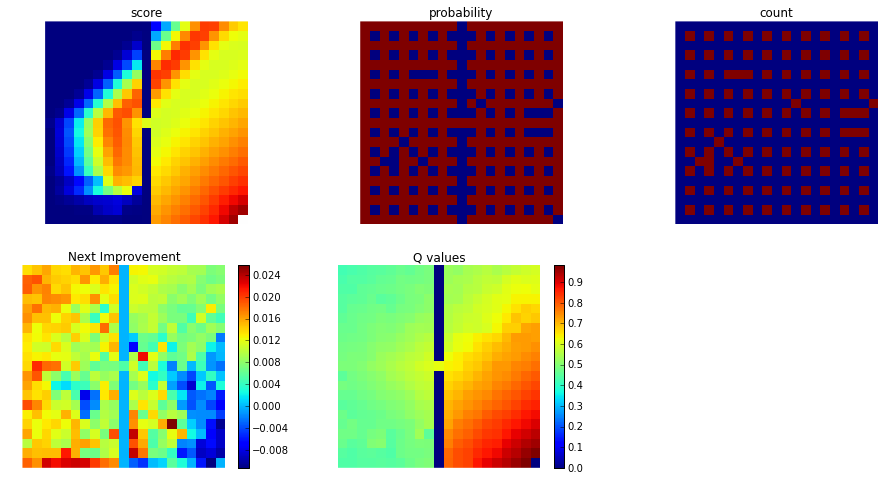

new Q value [ 0.59696956]
it 109


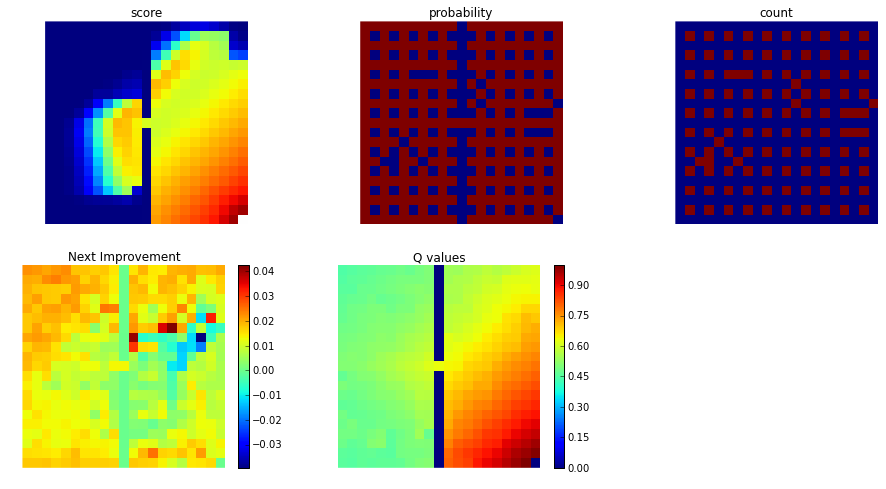

new Q value [ 0.87252981]
it 110


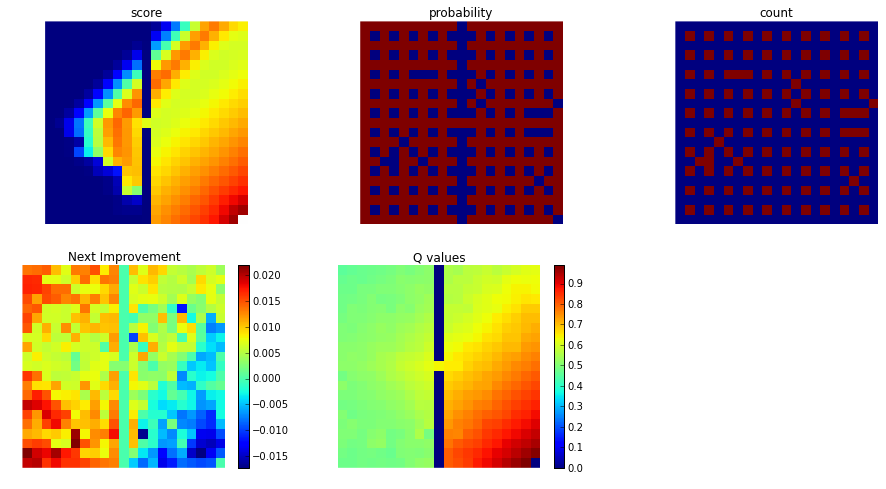

new Q value [ 0.51182324]
it 111


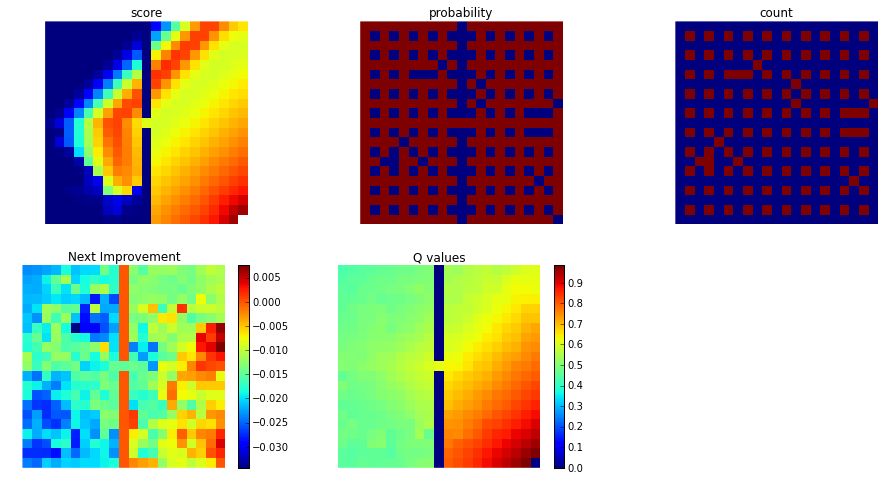

new Q value [ 0.45973139]
it 112


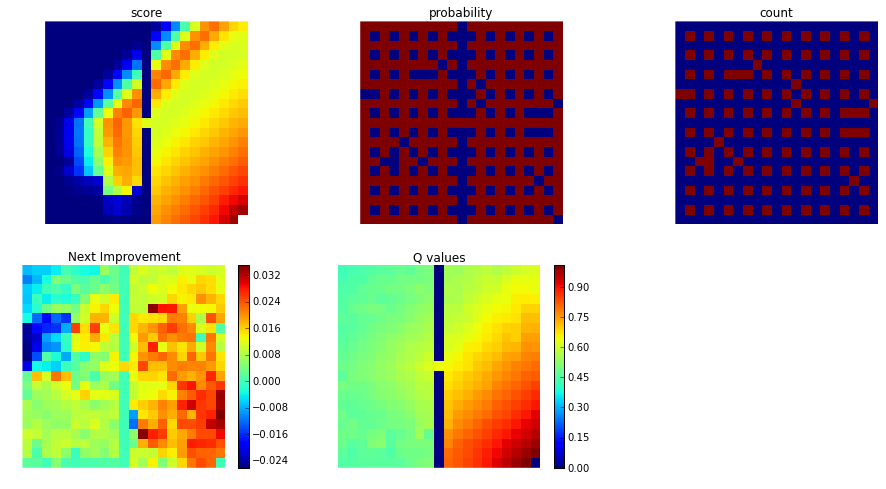

new Q value [ 0.57255496]
it 113


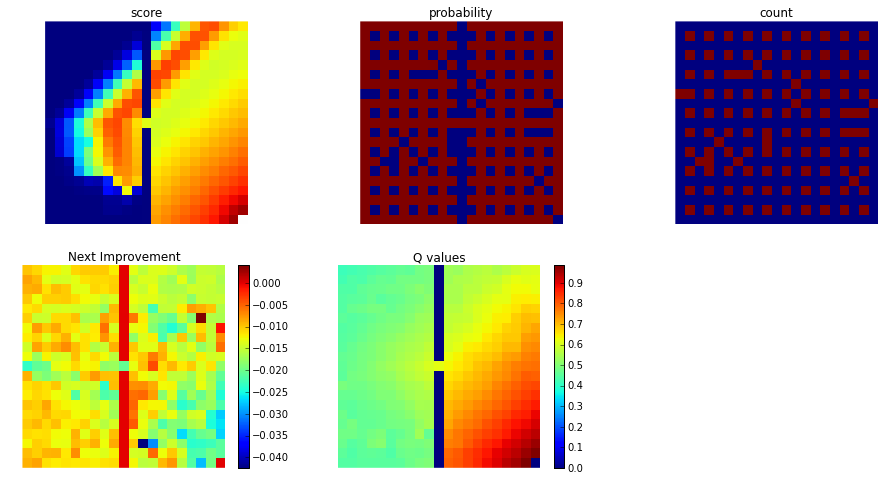

new Q value [ 0.61081881]
it 114


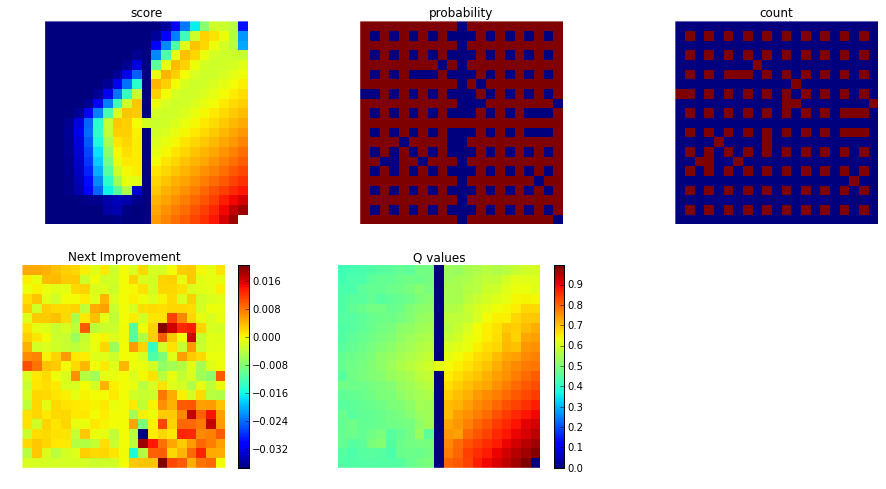

new Q value [ 0.73916913]
it 115


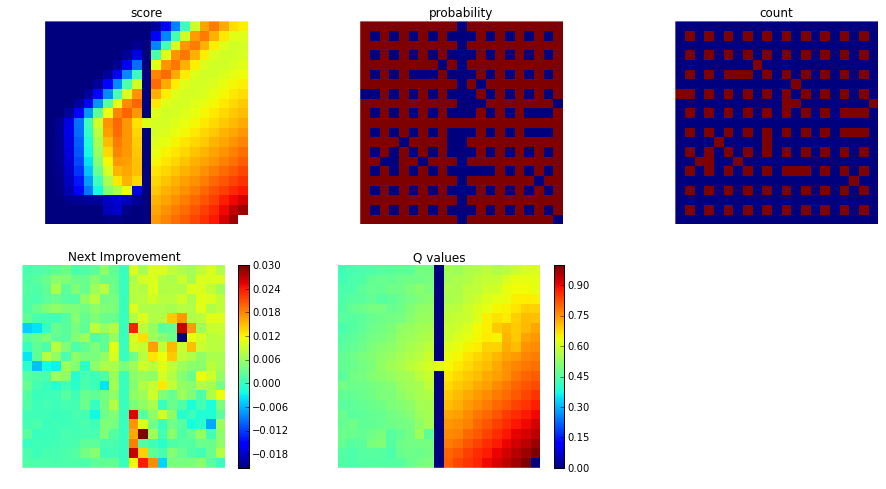

new Q value [ 0.81198538]
it 116


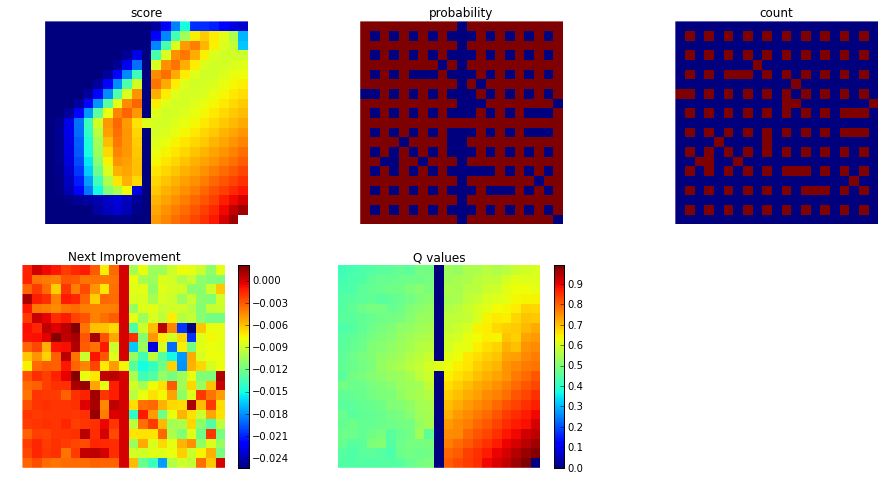

new Q value [ 0.48102834]
it 117


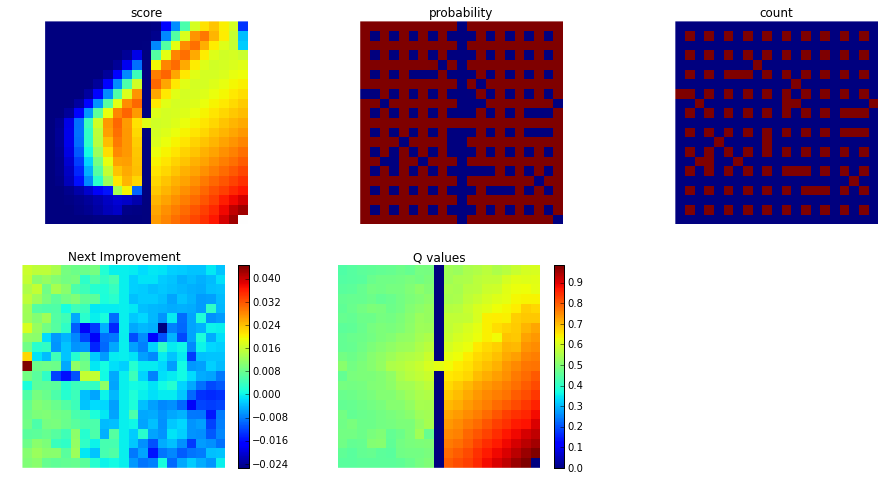

new Q value [ 0.86881338]
it 118


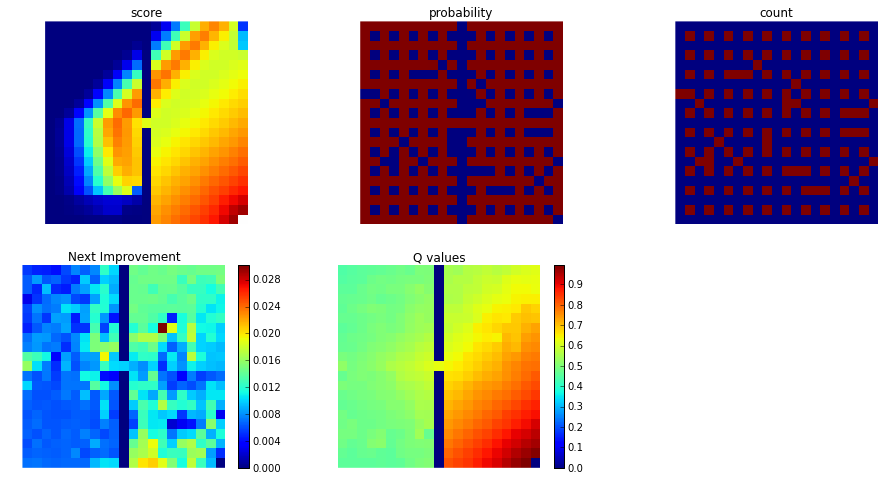

new Q value [ 0.71233308]
it 119


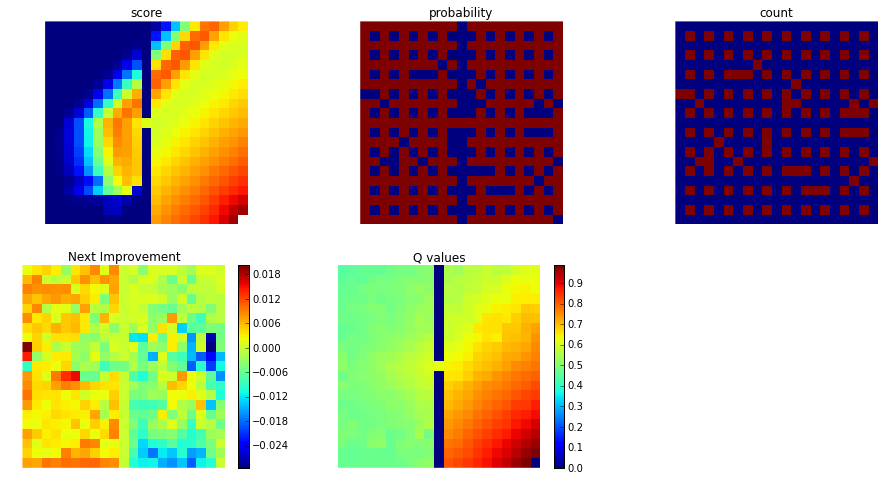

new Q value [ 0.52181241]
it 120


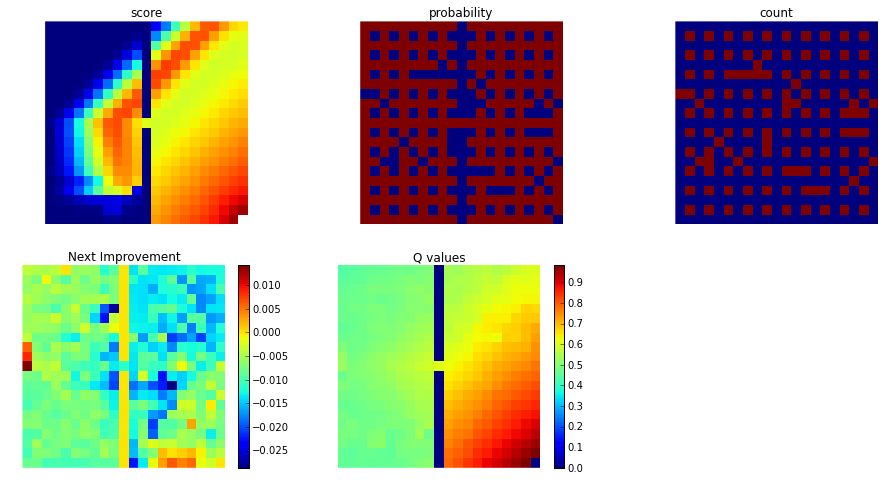

new Q value [ 0.90339227]
it 121


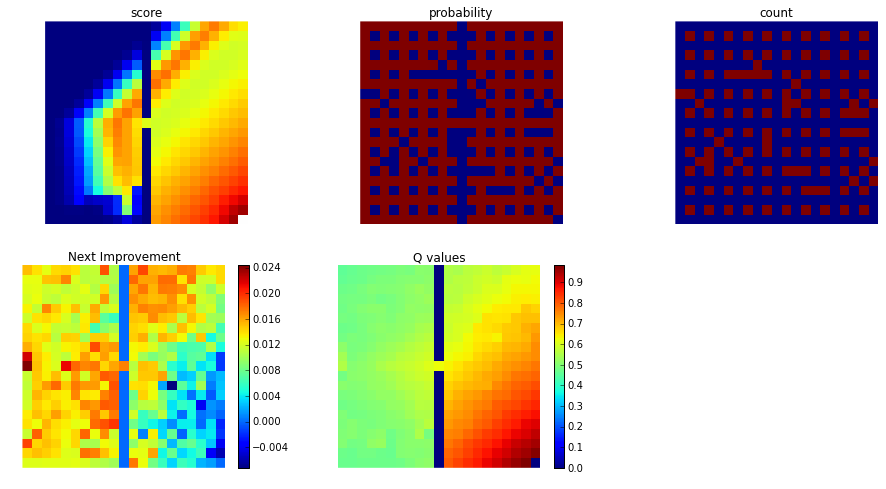

new Q value [ 0.4806751]
it 122


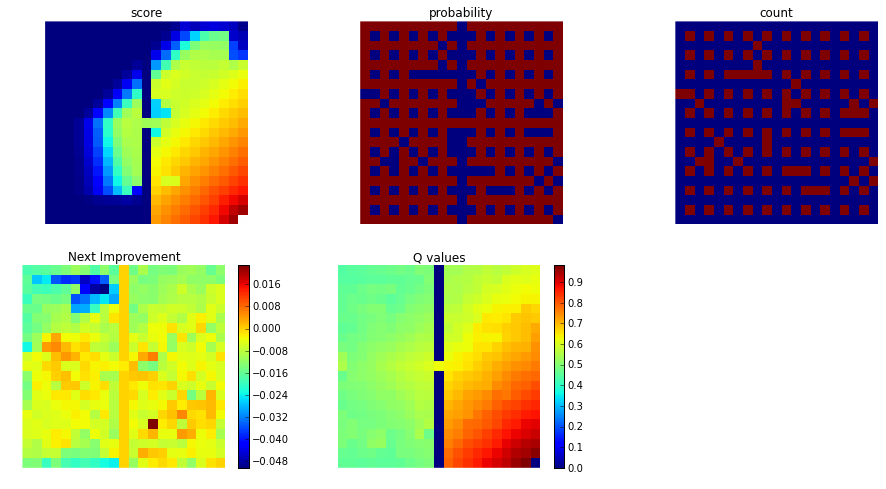

new Q value [ 0.88516755]
it 123


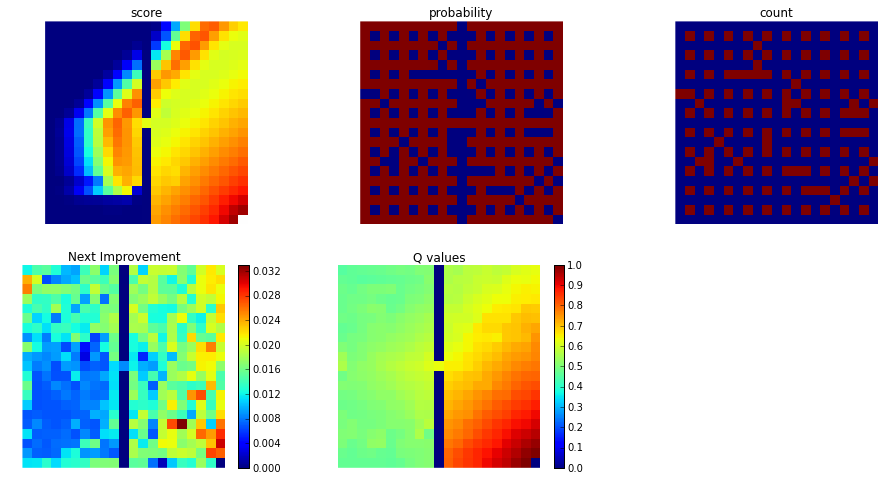

new Q value [ 0.91713449]
it 124


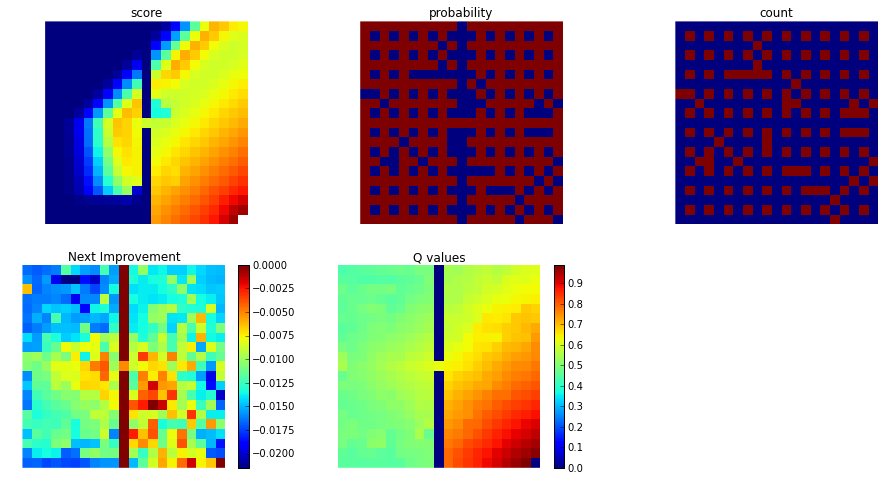

new Q value [ 0.86328856]
it 125


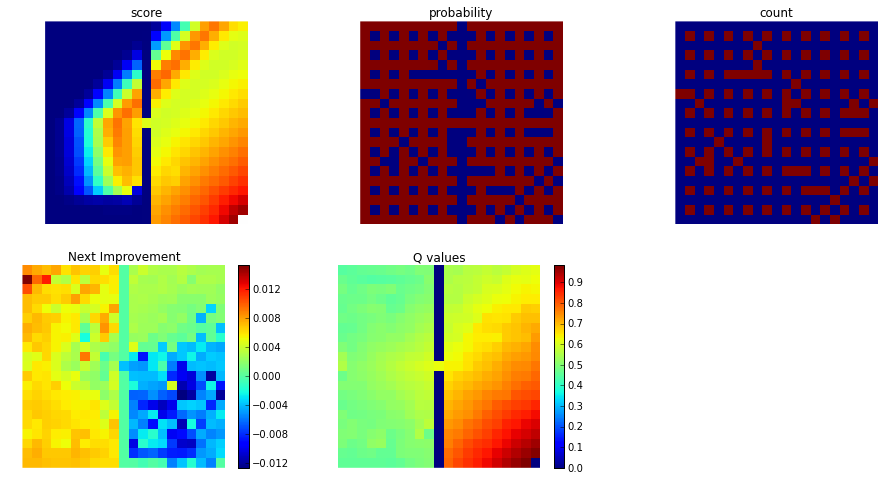

new Q value [ 0.42526633]
it 126


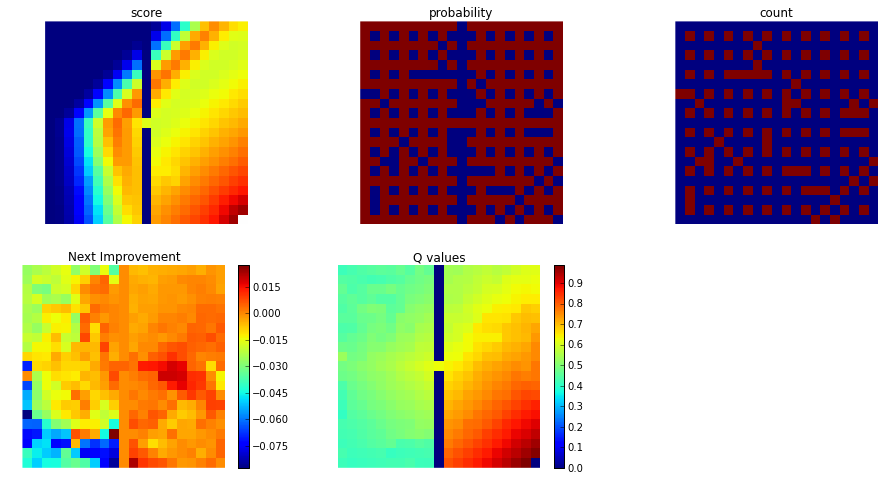

new Q value [ 0.62414296]
it 127


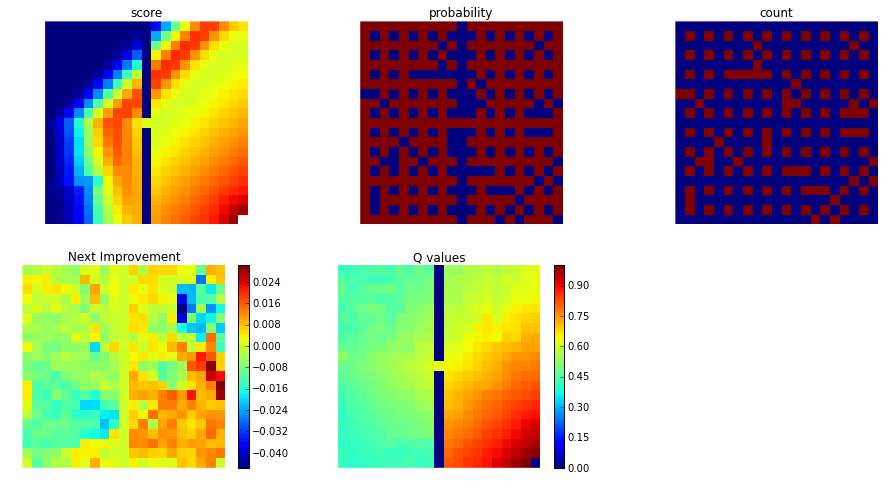

new Q value [ 0.83256067]
it 128


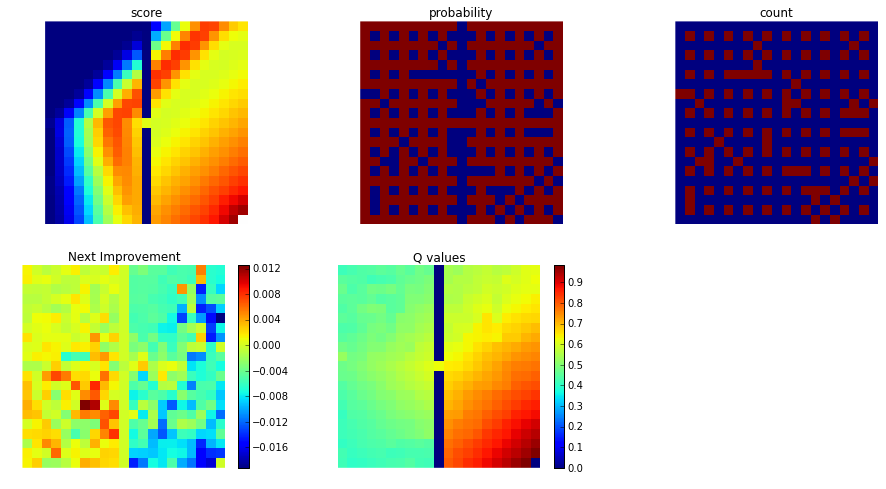

new Q value [ 0.49835898]
it 129


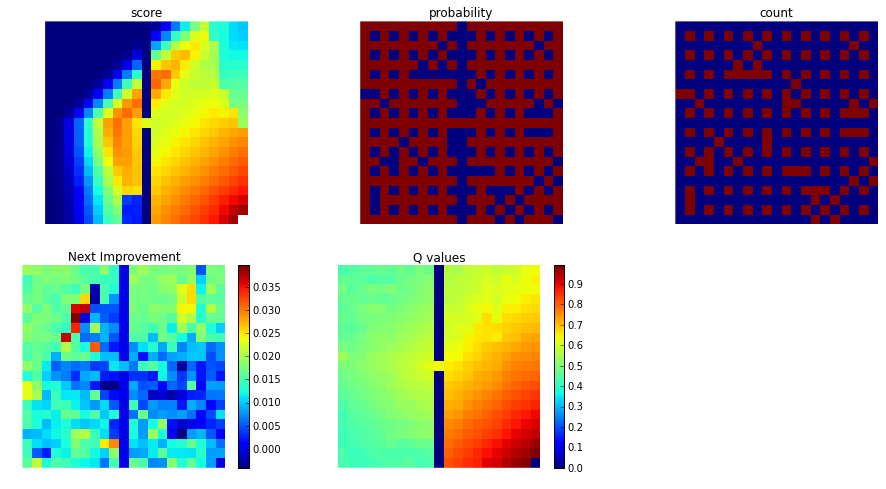

new Q value [ 0.6038285]
it 130


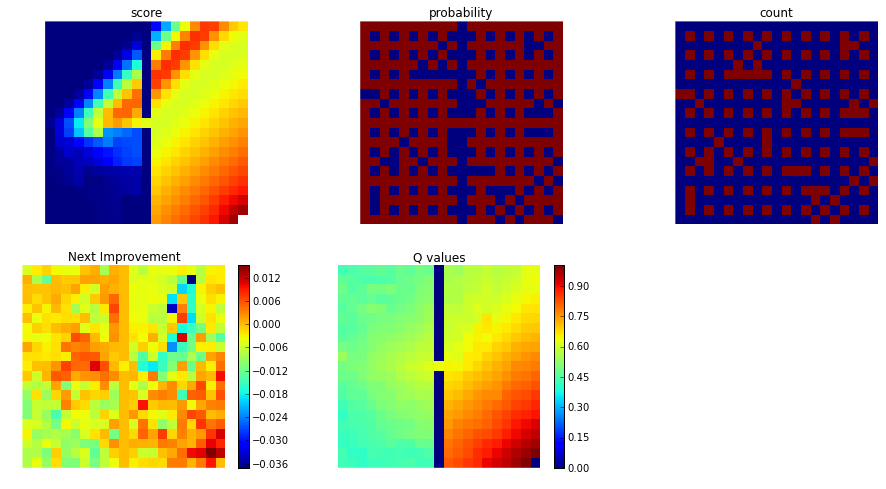

new Q value [ 0.54634124]
it 131


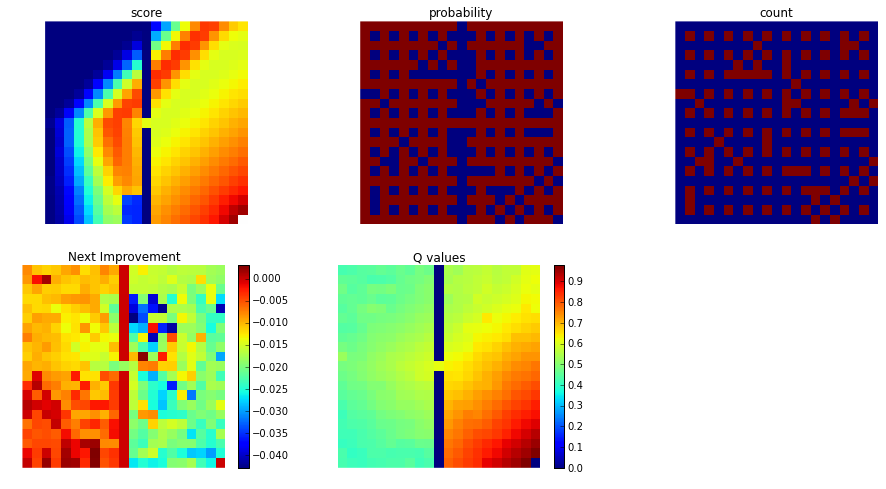

new Q value [ 0.644695]
it 132


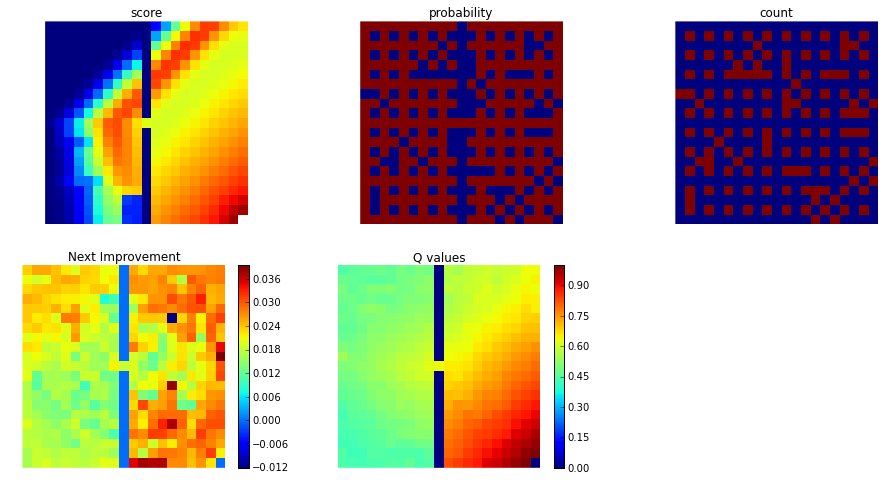

new Q value [ 0.84888857]
it 133


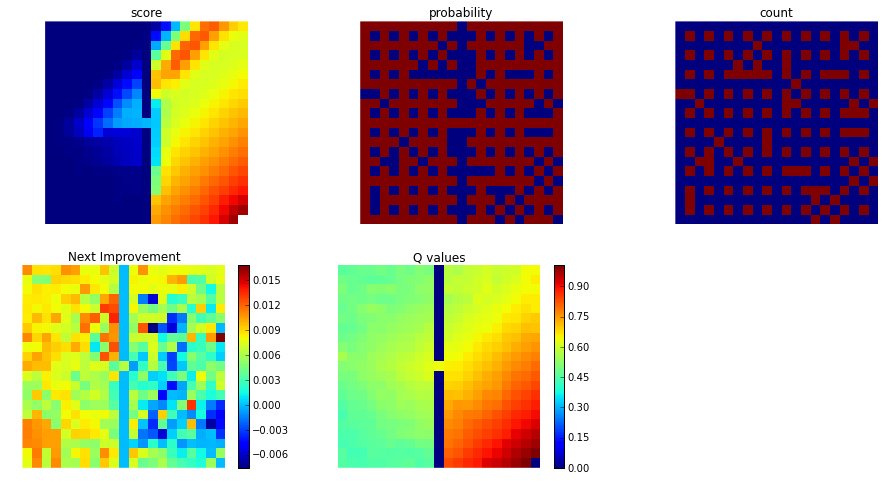

new Q value [ 0.42049615]
it 134


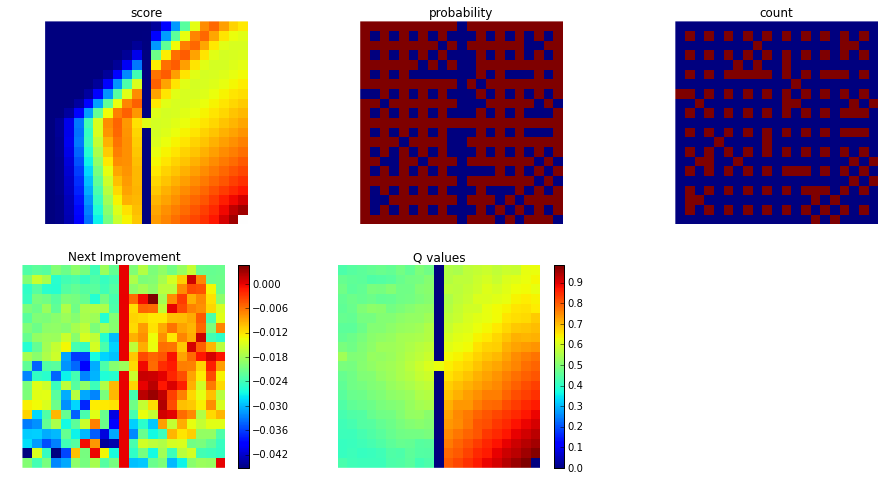

new Q value [ 0.55459929]
it 135


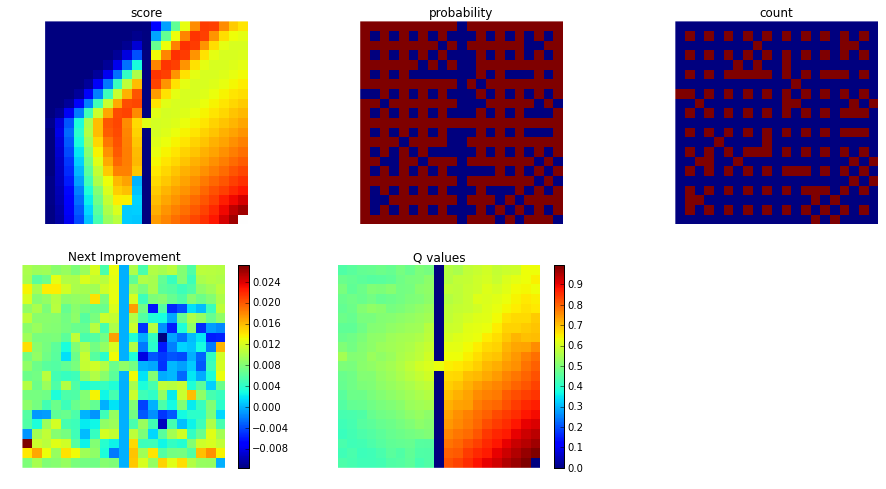

new Q value [ 0.42961494]
it 136


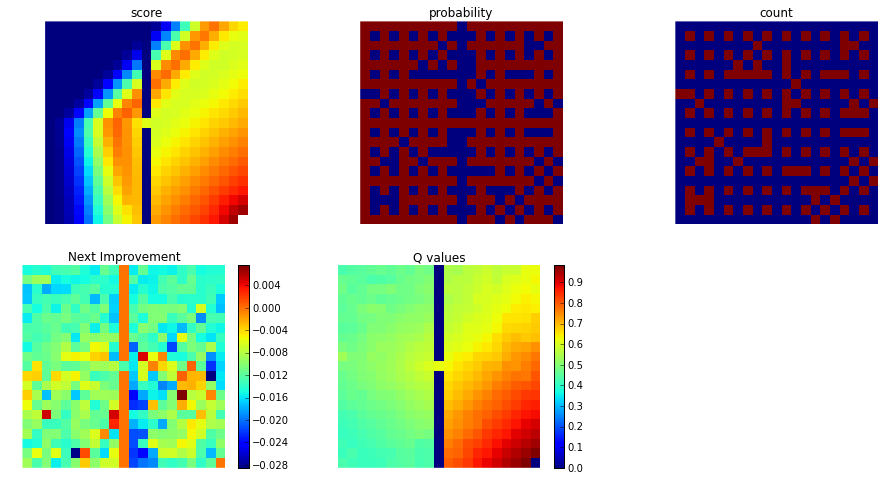

new Q value [ 0.72894663]
it 137


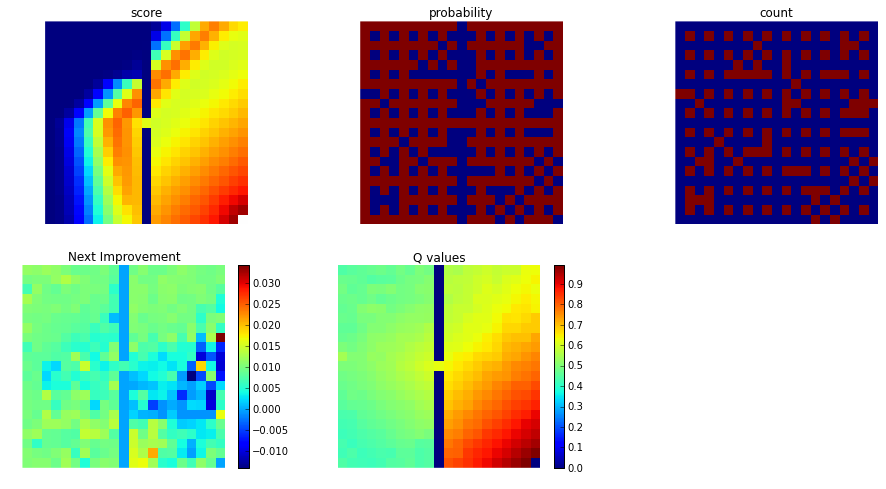

new Q value [ 0.52978103]
it 138


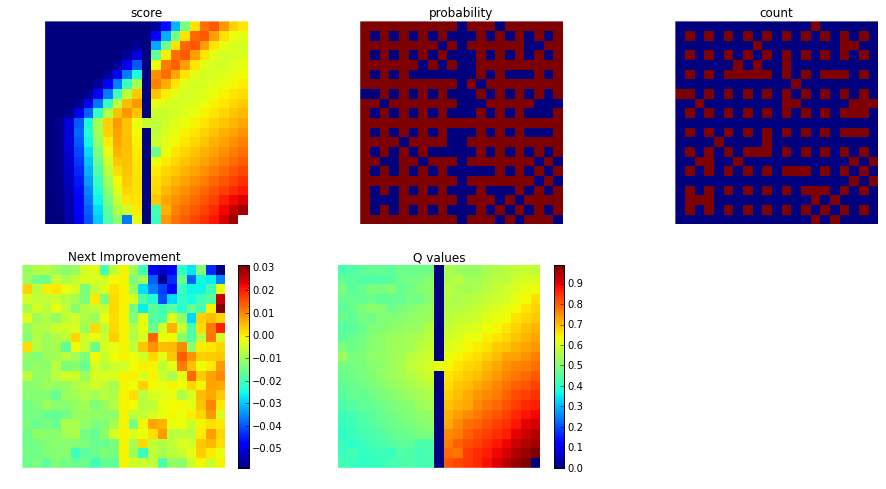

new Q value [ 0.52043386]
it 139


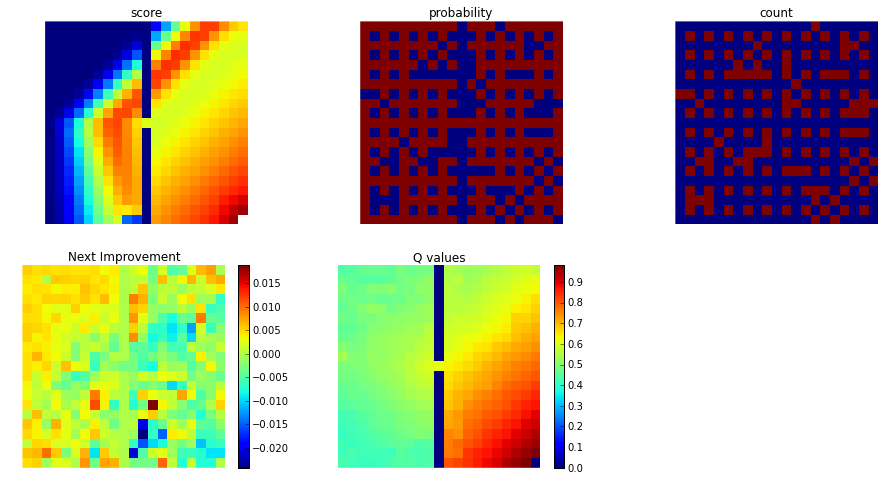

new Q value [ 0.48697311]
it 140


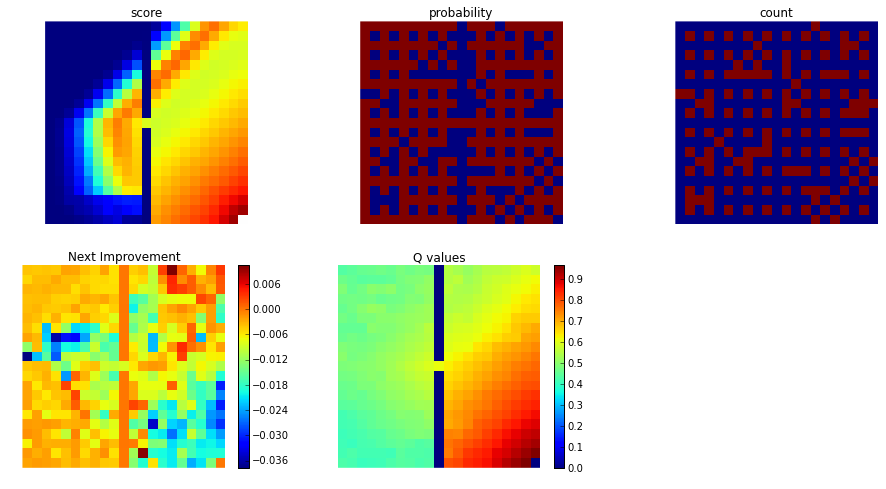

new Q value [ 0.94836246]
it 141


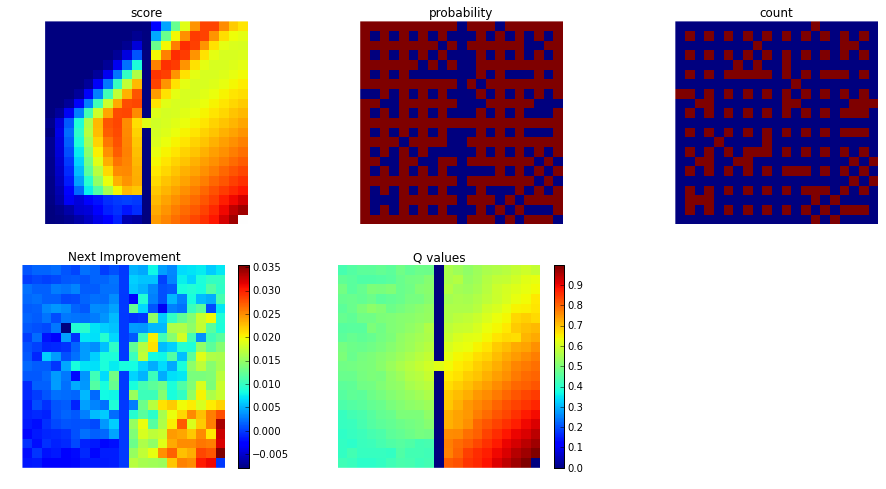

new Q value [ 0.45705891]
it 142


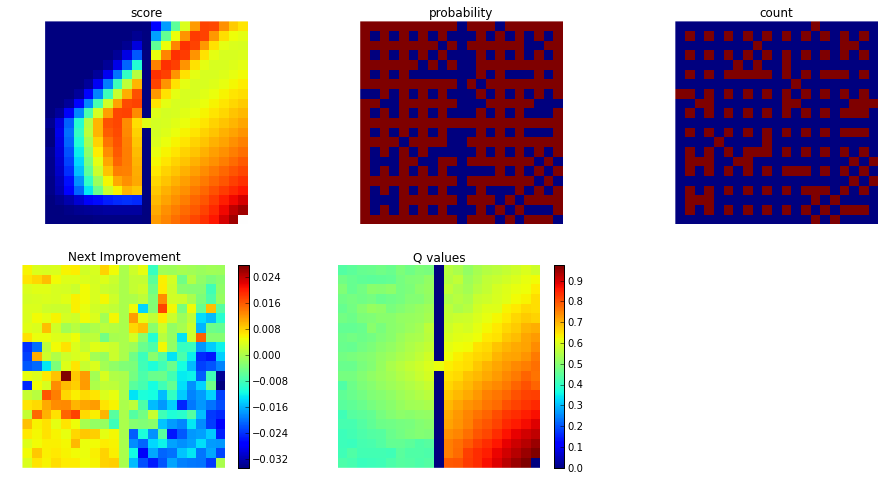

new Q value [ 0.52961587]
it 143


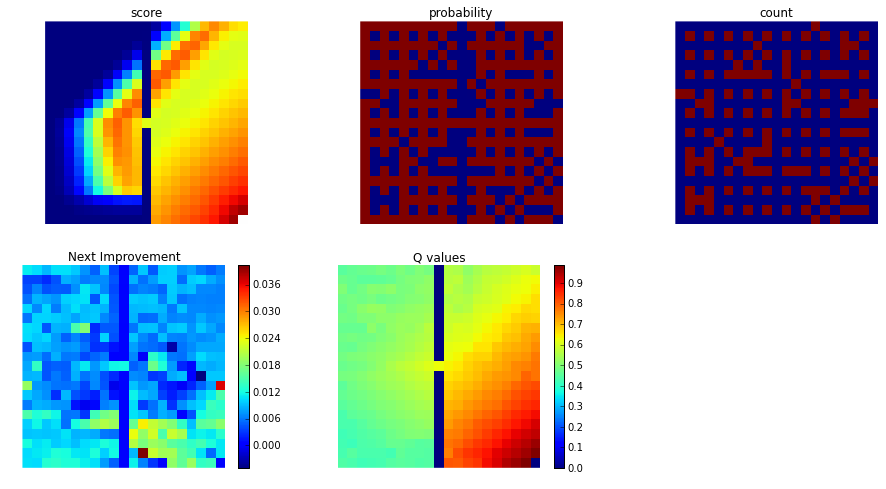

new Q value [ 0.44092379]
it 144


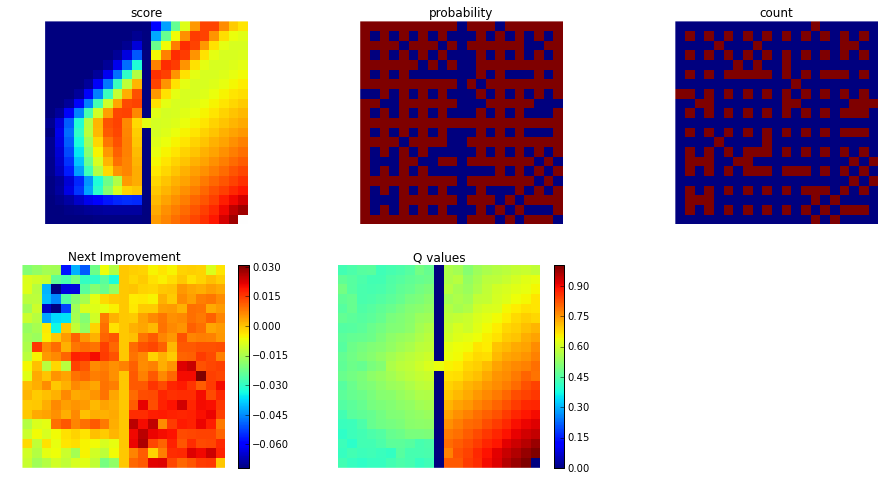

new Q value [ 0.58093113]
it 145


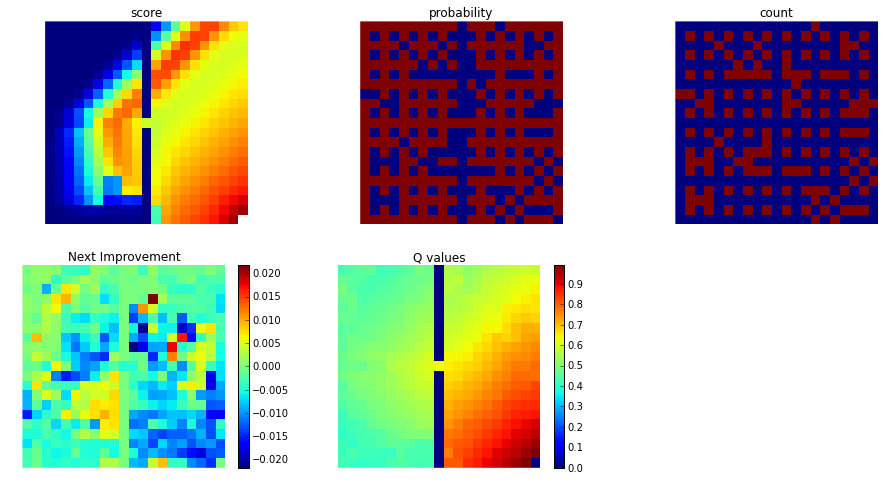

new Q value [ 0.44606484]
it 146


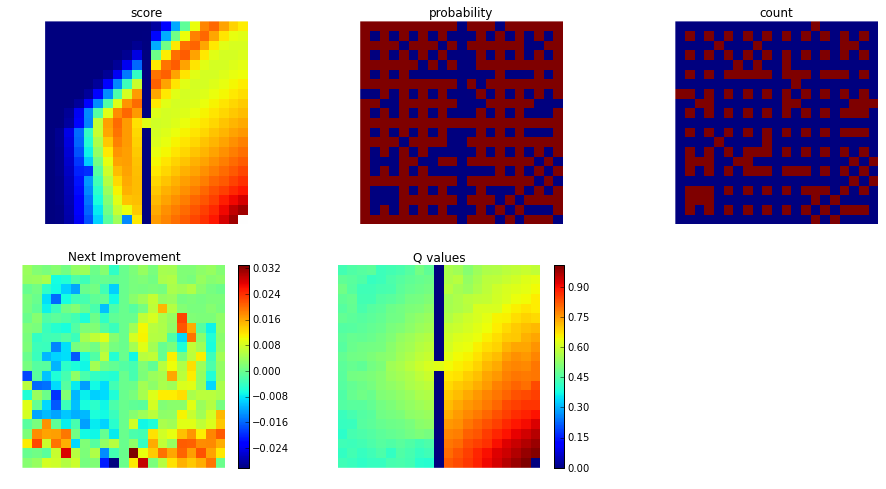

new Q value [ 0.56793192]
it 147


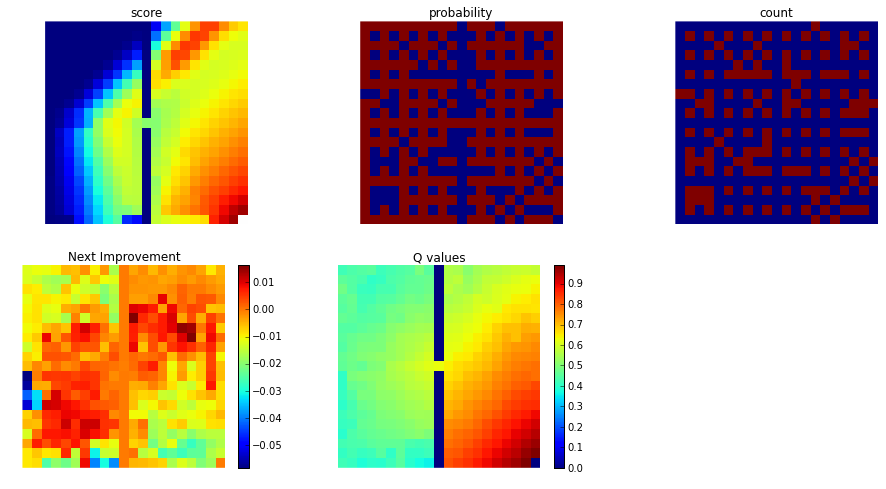

new Q value [ 0.9401556]
it 148


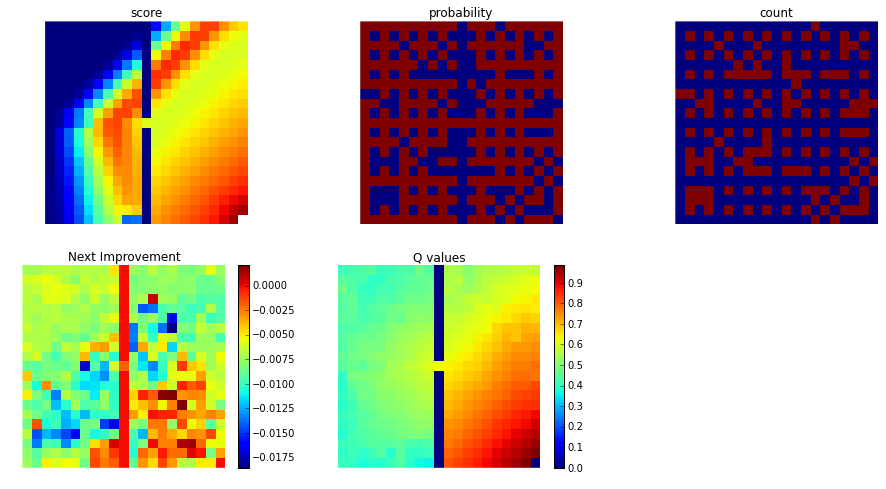

new Q value [ 0.56743789]
it 149


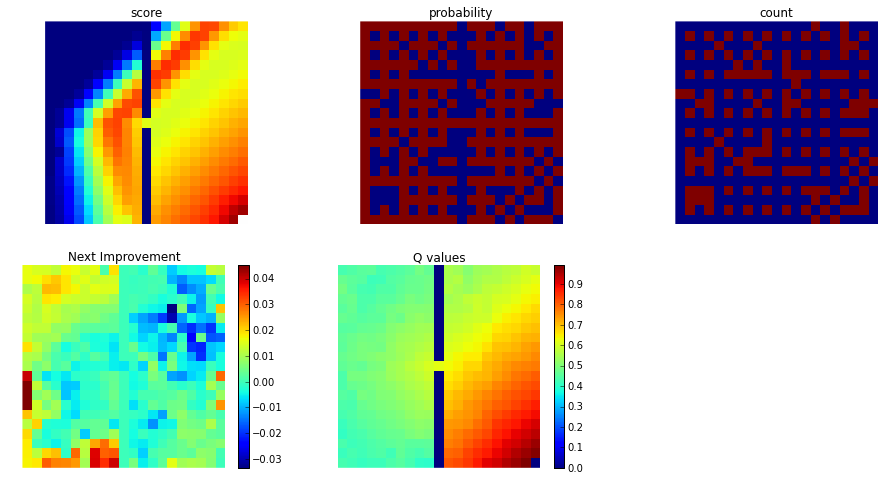

new Q value [ 0.70263833]
it 150


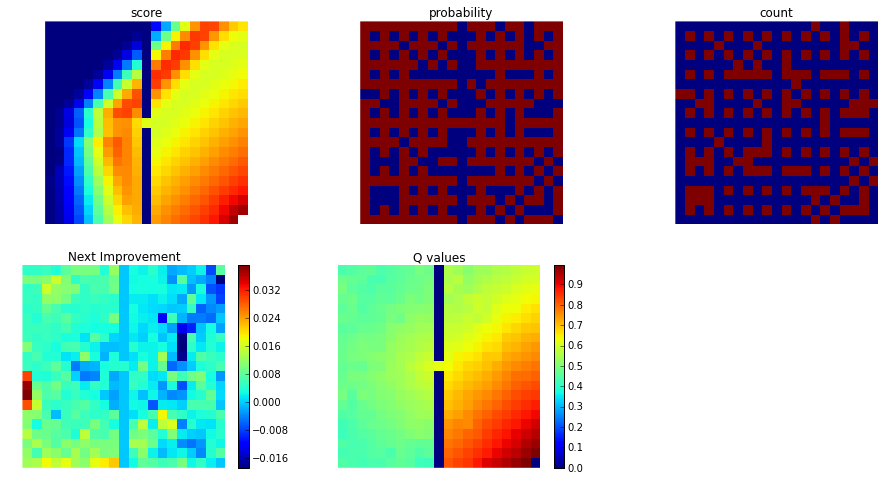

new Q value [ 0.42304903]
it 151


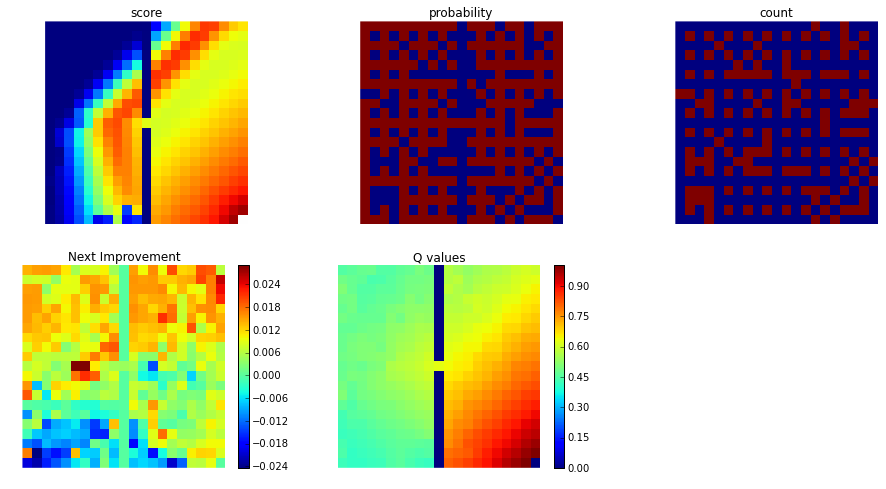

new Q value [ 0.85152493]
it 152


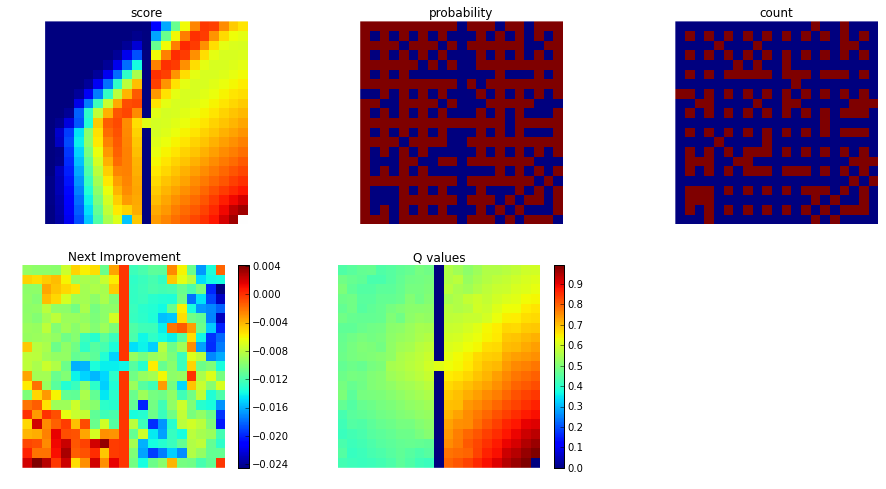

new Q value [ 0.8060517]
it 153


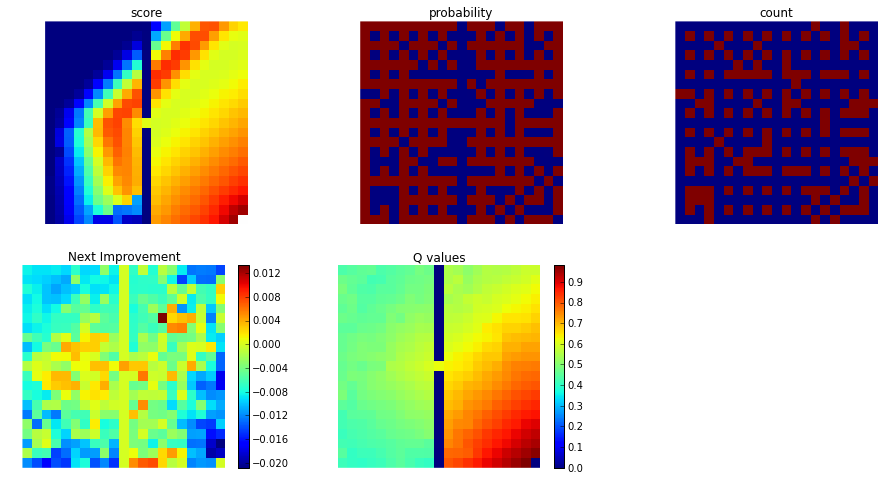

new Q value [ 0.58323995]
it 154


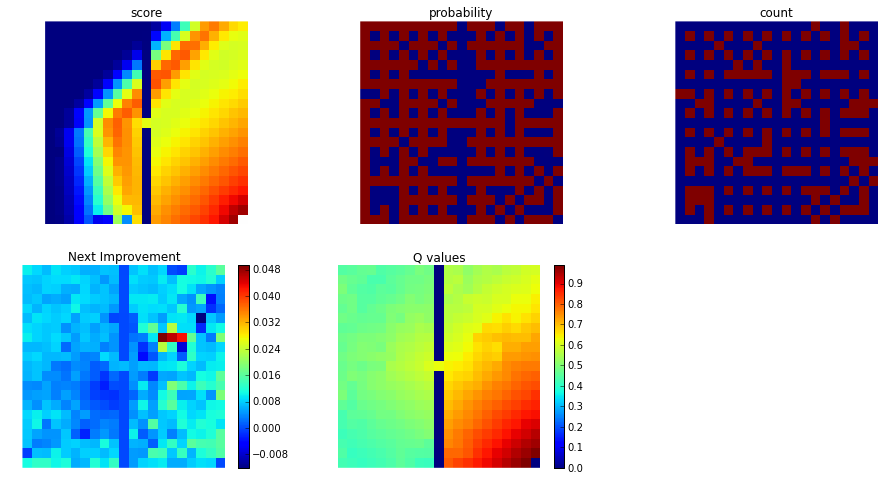

new Q value [ 0.710249]
it 155


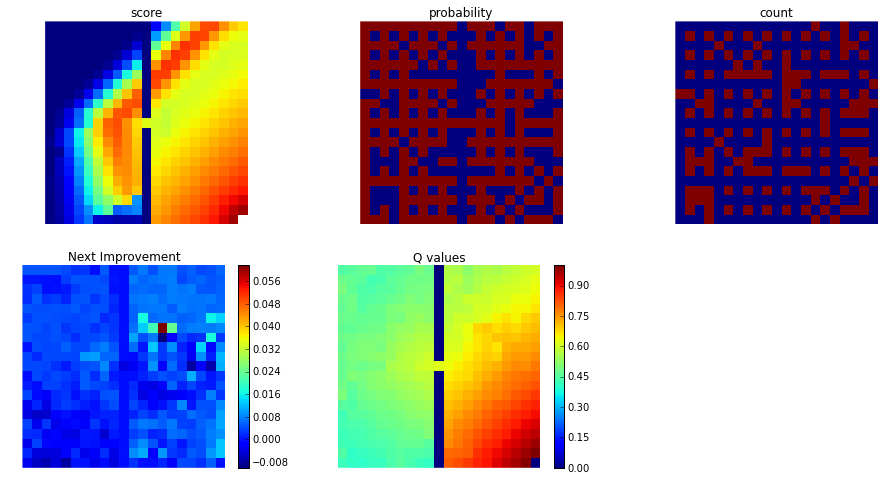

new Q value [ 0.68054296]
it 156


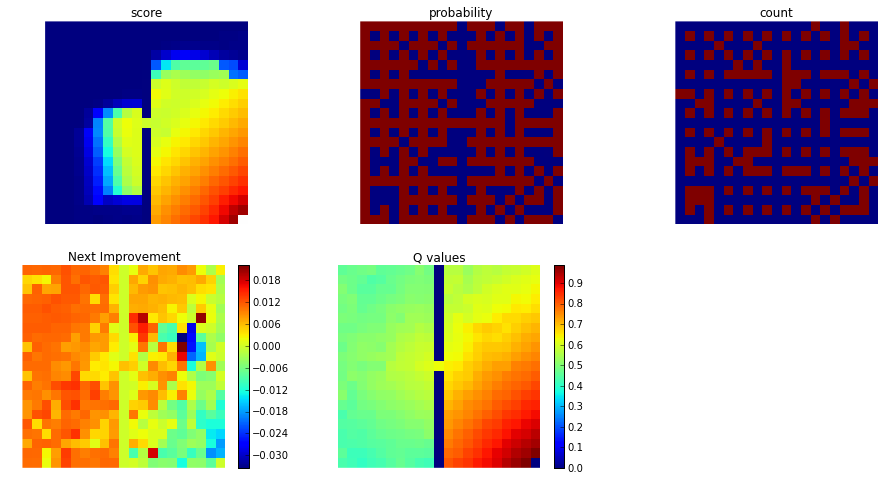

new Q value [ 0.56102114]
it 157


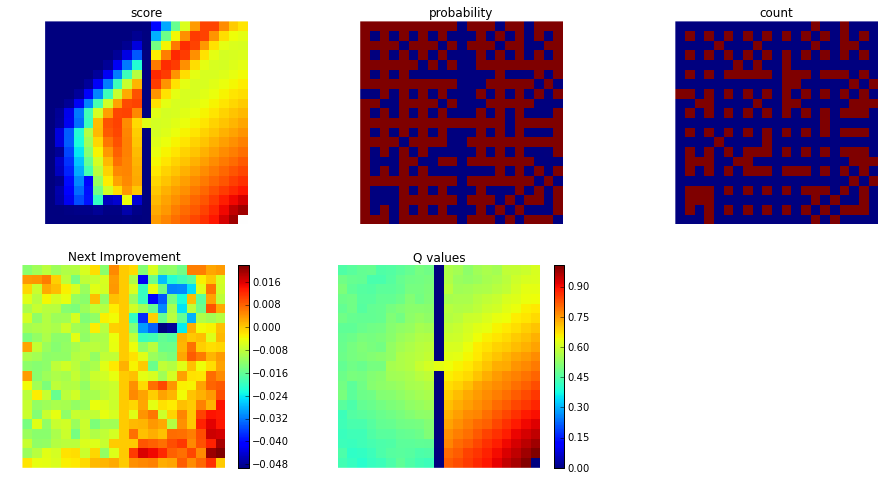

new Q value [ 0.6283186]
it 158


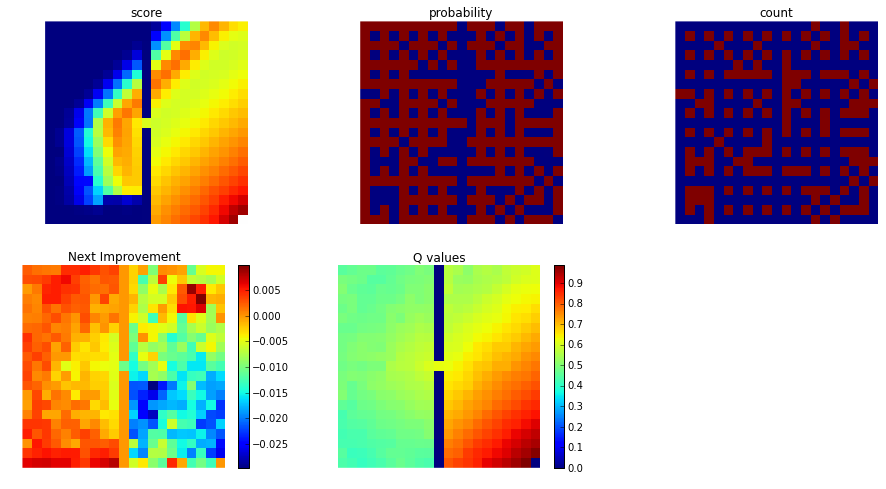

new Q value [ 0.49953408]
it 159


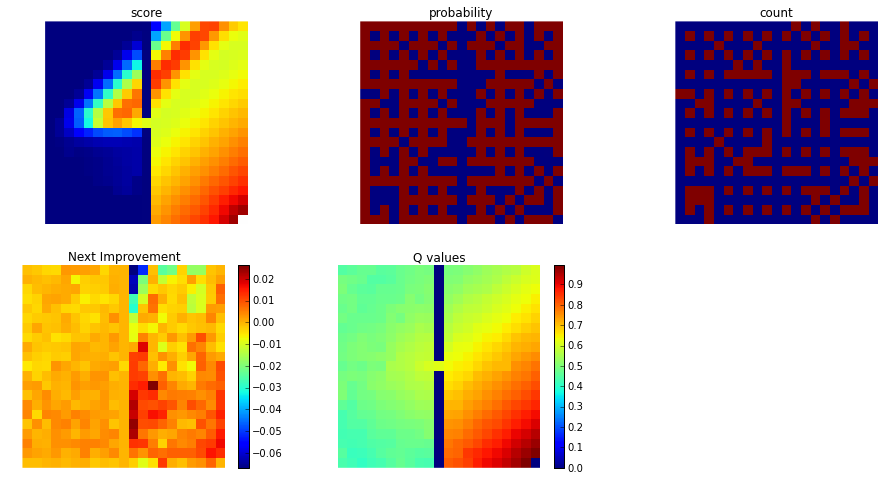

new Q value [ 0.8208489]
it 160


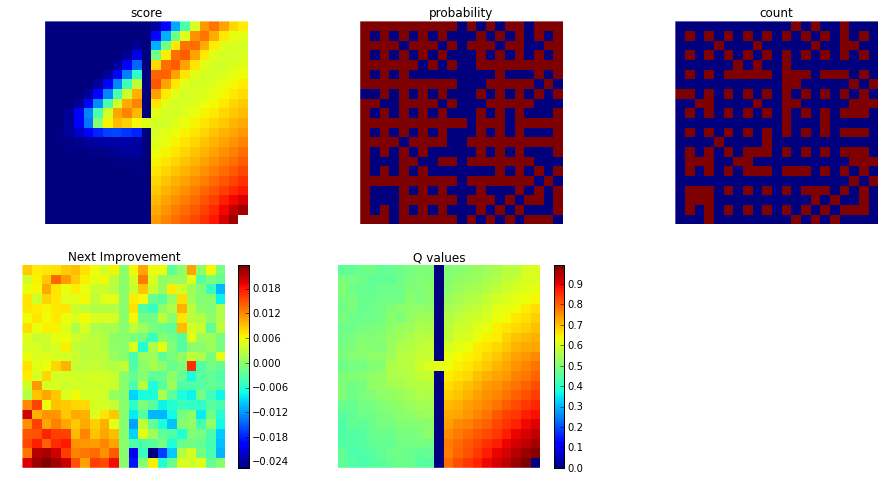

new Q value [ 0.94100833]
it 161


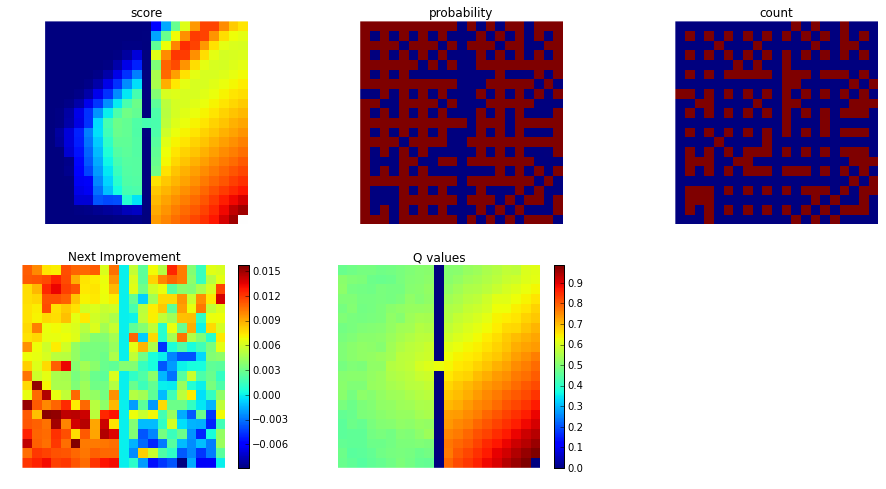

new Q value [ 0.39351036]
it 162


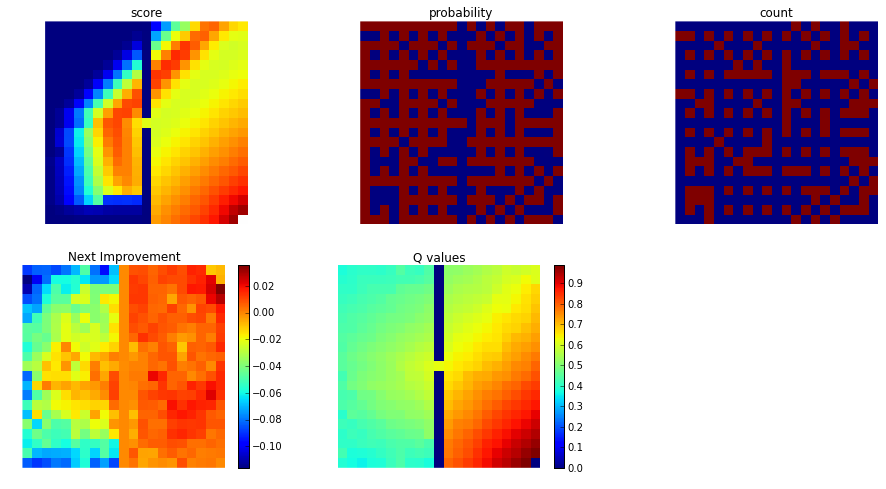

new Q value [ 0.46728566]
it 163


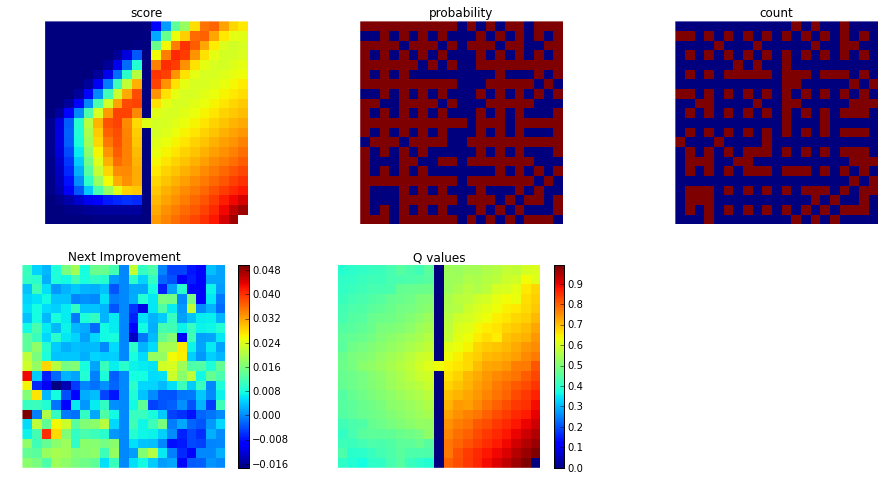

new Q value [ 0.48583069]
it 164


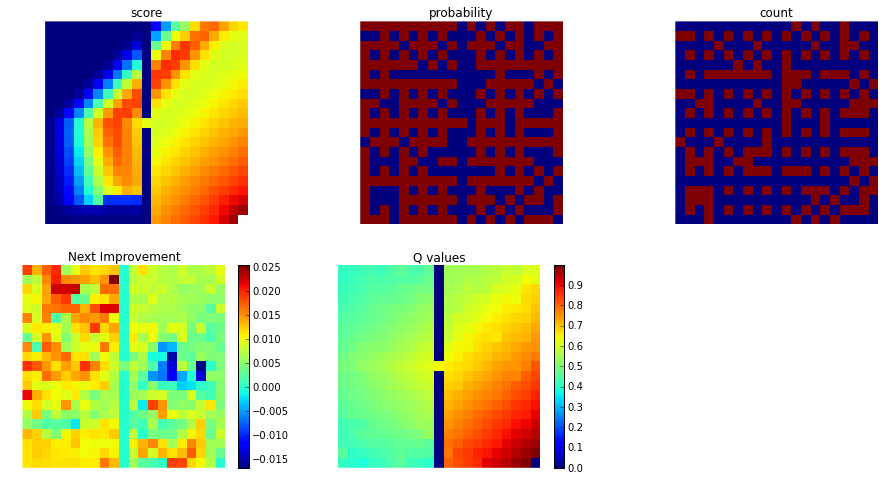

new Q value [ 0.71295334]
it 165


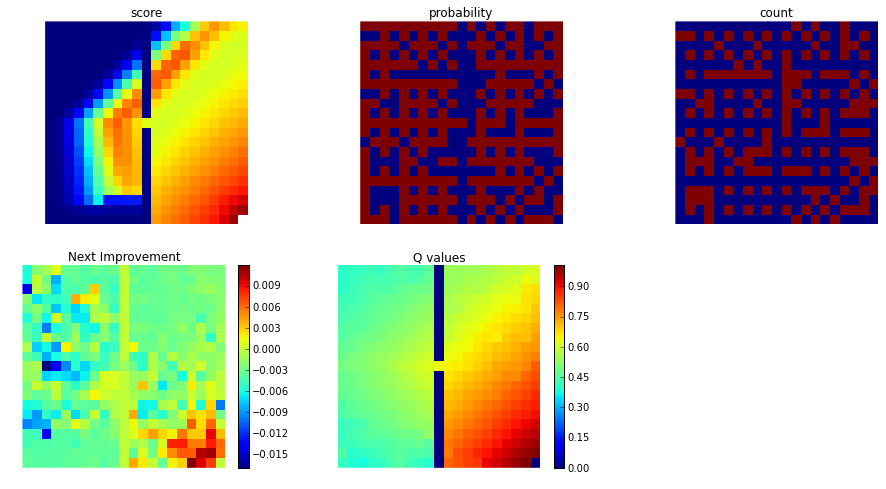

new Q value [ 0.50214779]
it 166


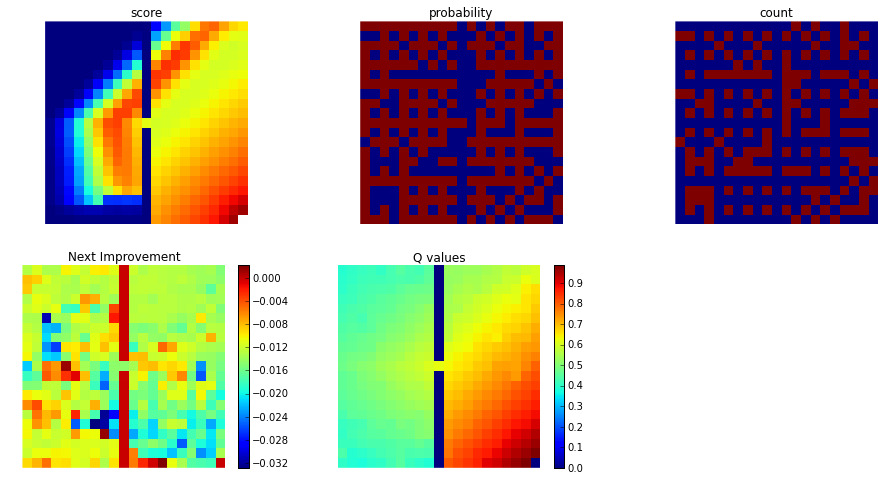

new Q value [ 0.50091434]
it 167


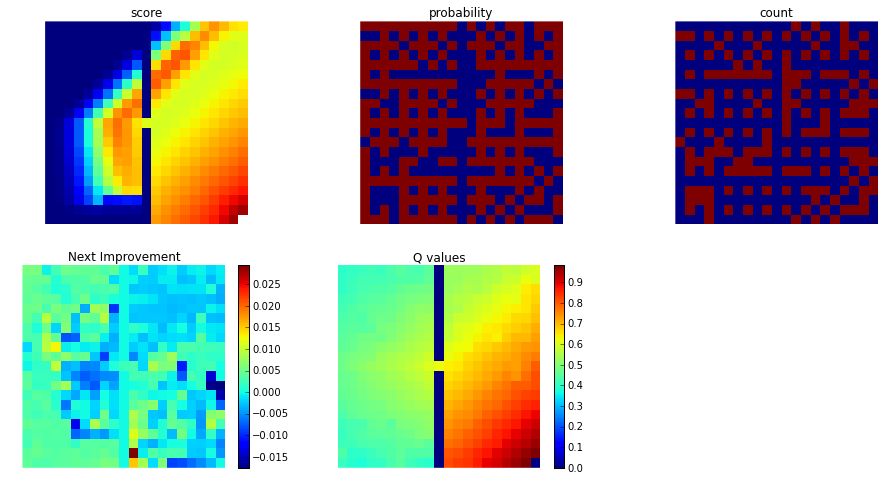

new Q value [ 0.4532603]
it 168


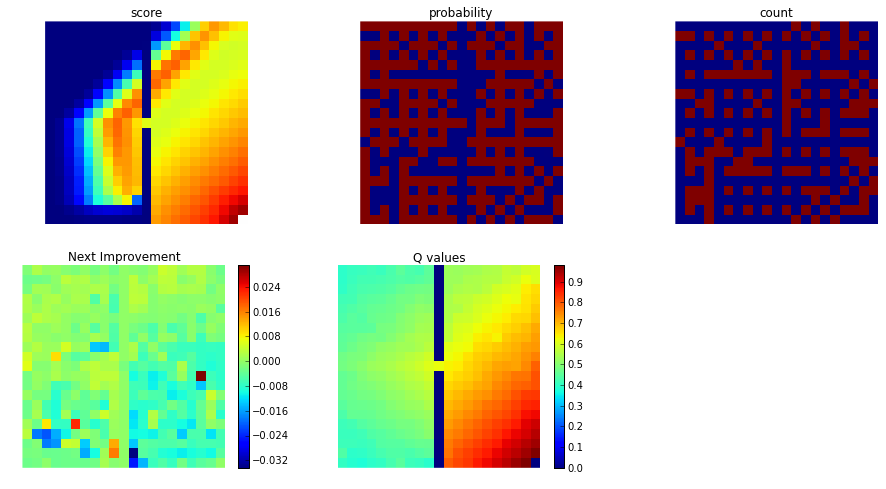

new Q value [ 0.82437913]
it 169


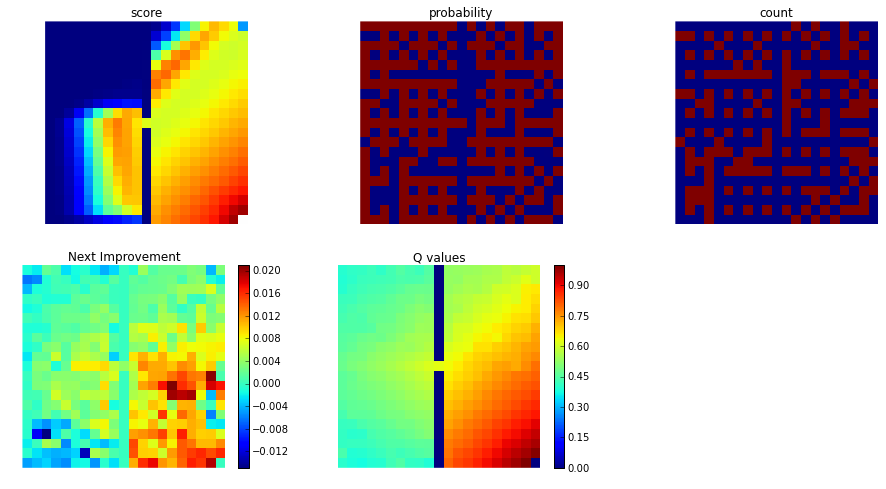

new Q value [ 0.46669226]
it 170


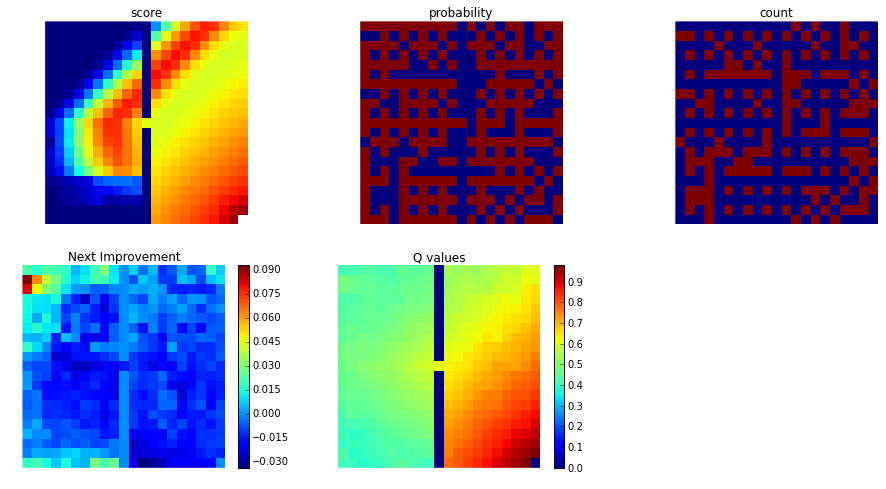

new Q value [ 0.50858887]
it 171


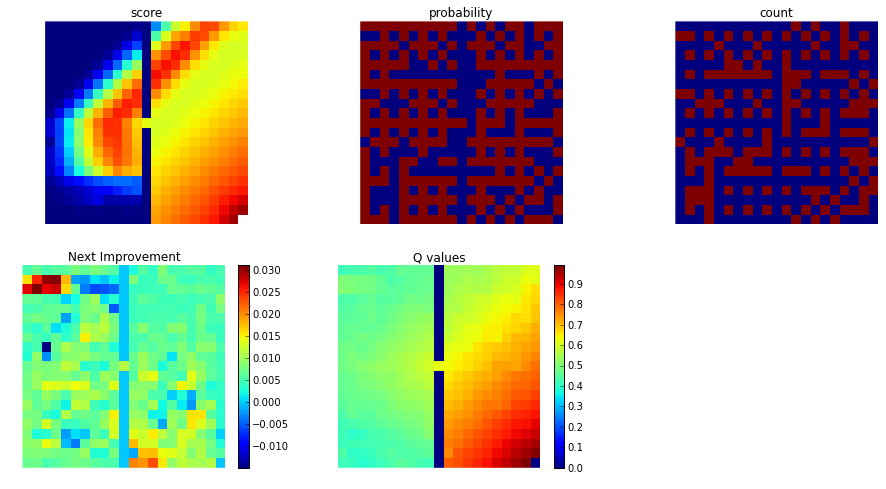

new Q value [ 0.51777968]
it 172


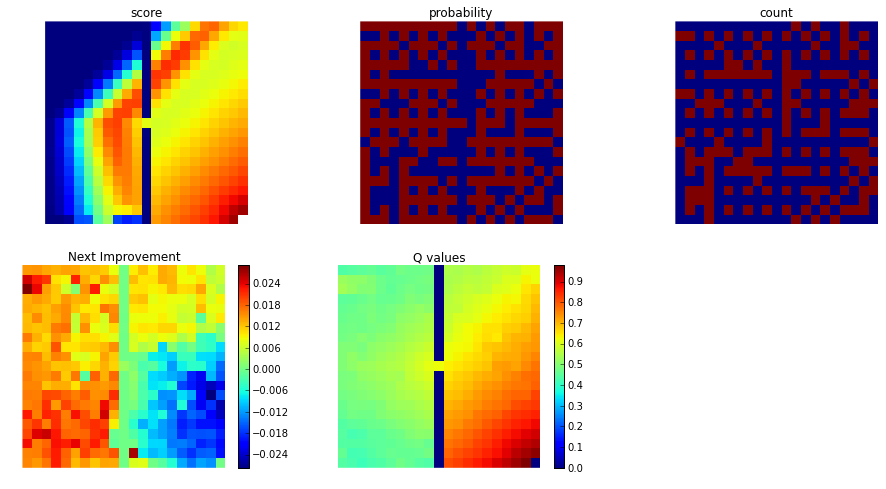

new Q value [ 0.42863605]
it 173


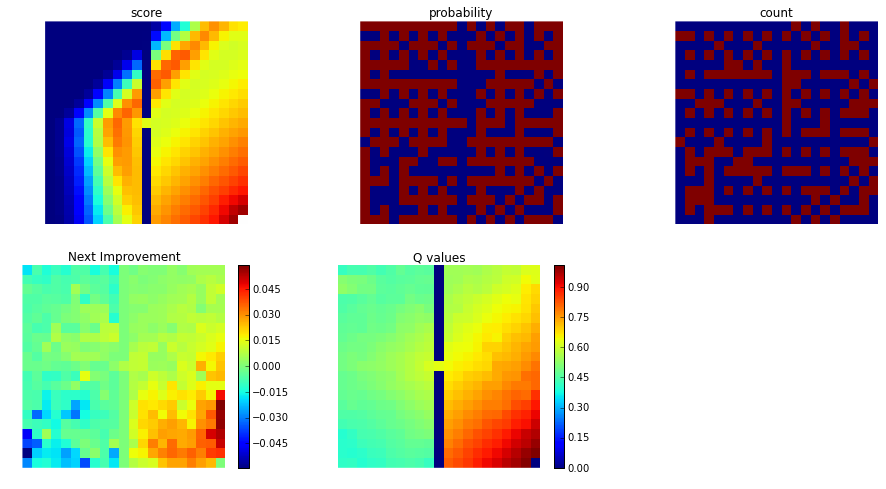

new Q value [ 0.61938806]
it 174


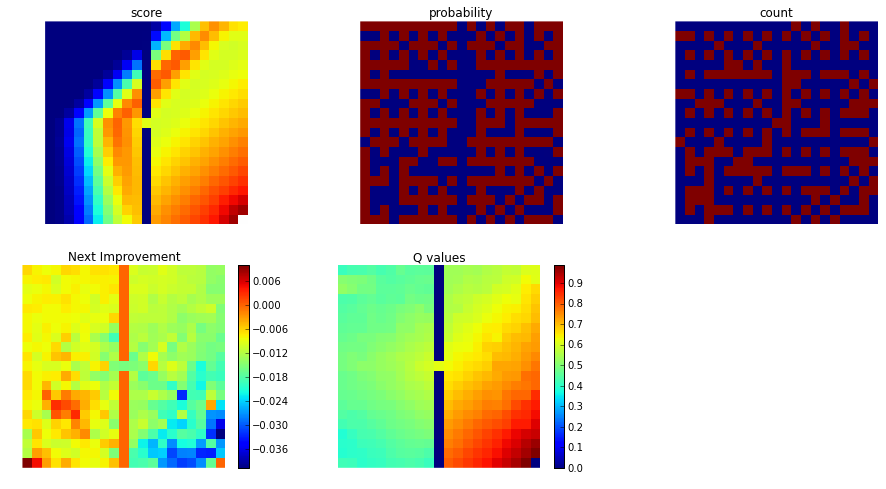

new Q value [ 0.63384256]
it 175


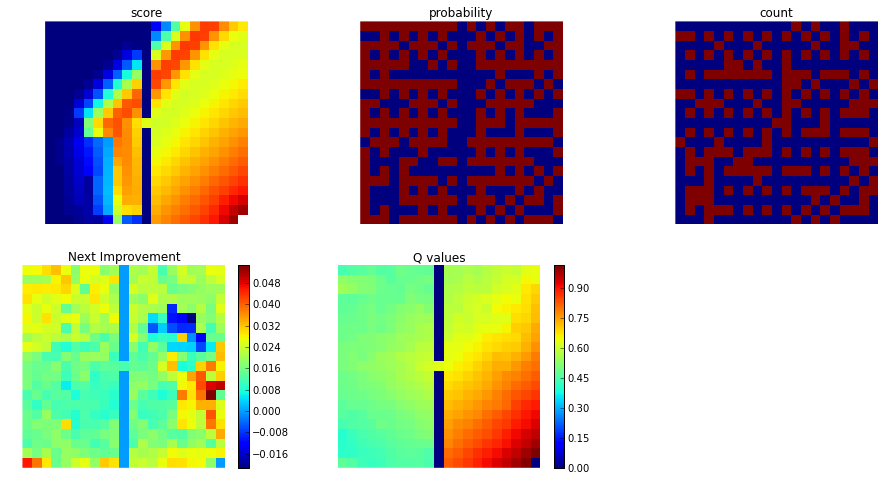

new Q value [ 0.6694372]
it 176


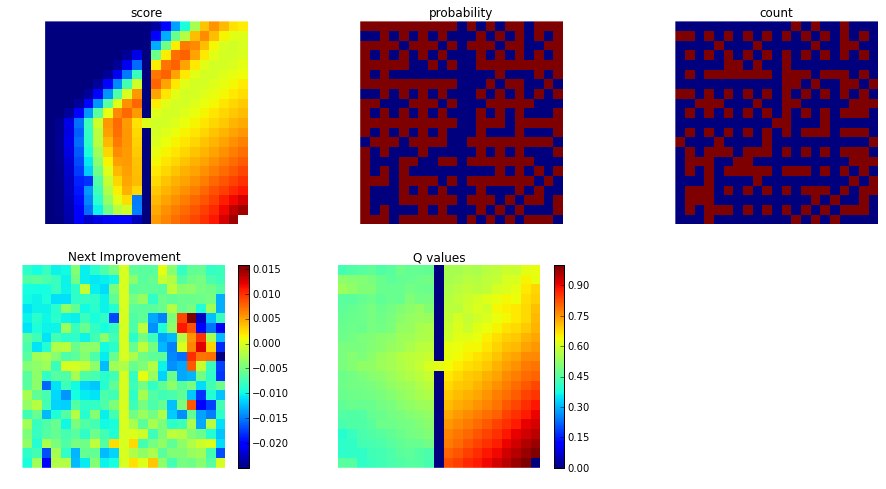

new Q value [ 0.86098729]
it 177


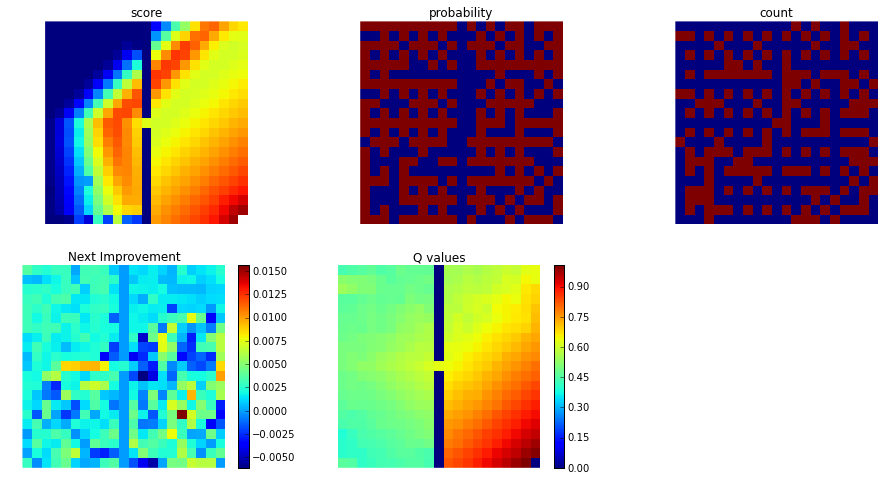

new Q value [ 0.50001385]
it 178


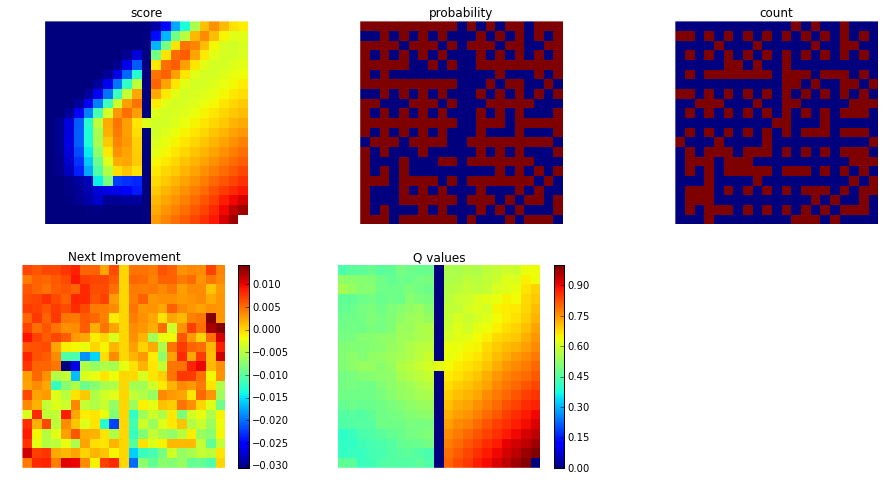

new Q value [ 0.59430996]
it 179


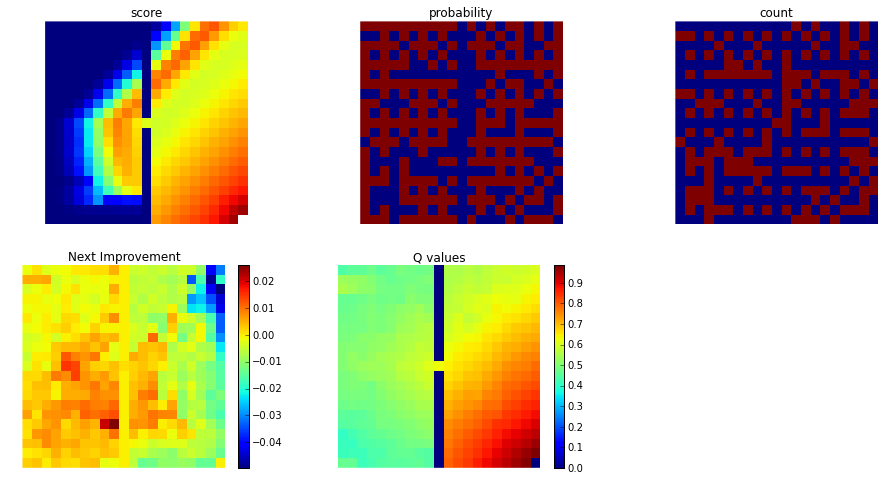

new Q value [ 0.70979466]
it 180


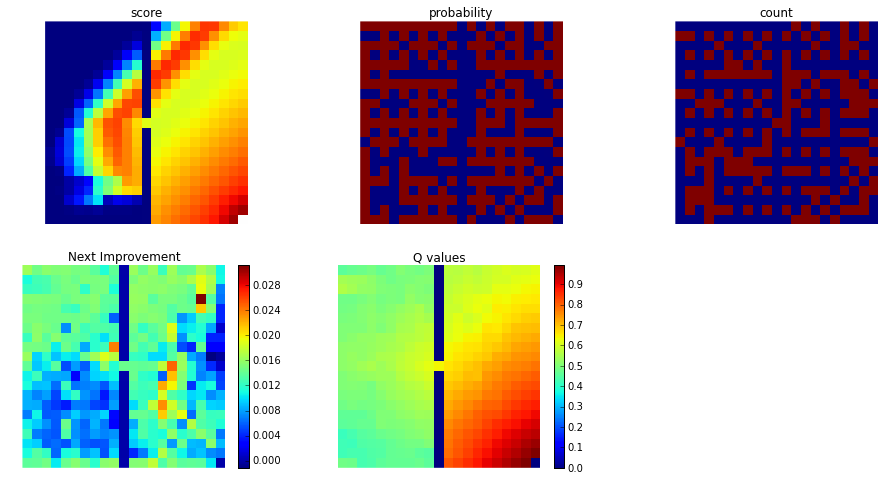

new Q value [ 0.4975769]
it 181


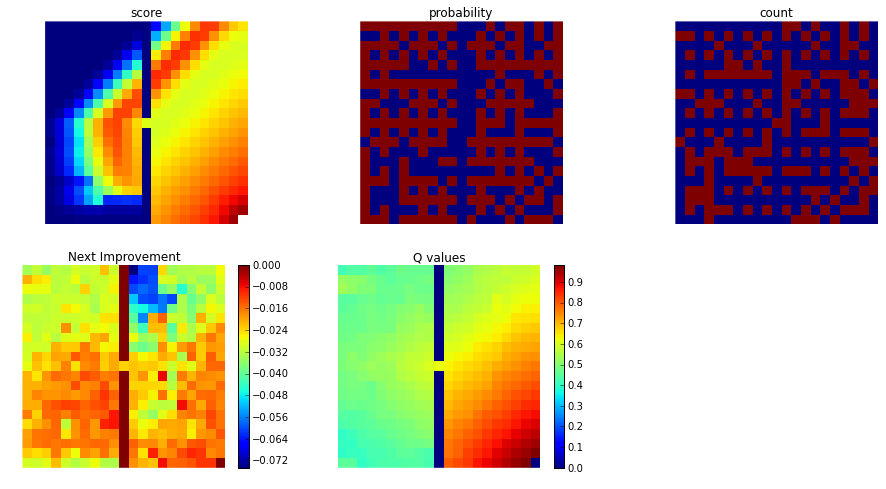

new Q value [ 0.77607863]
it 182


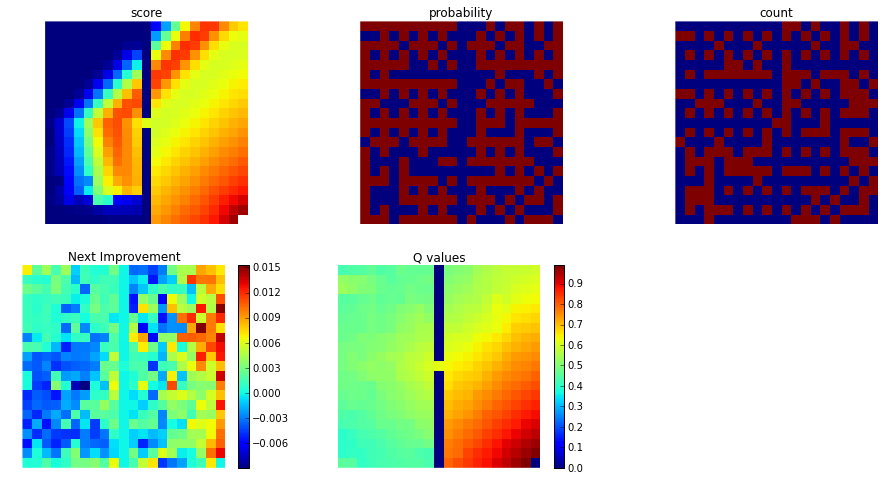

new Q value [ 0.62528873]
it 183


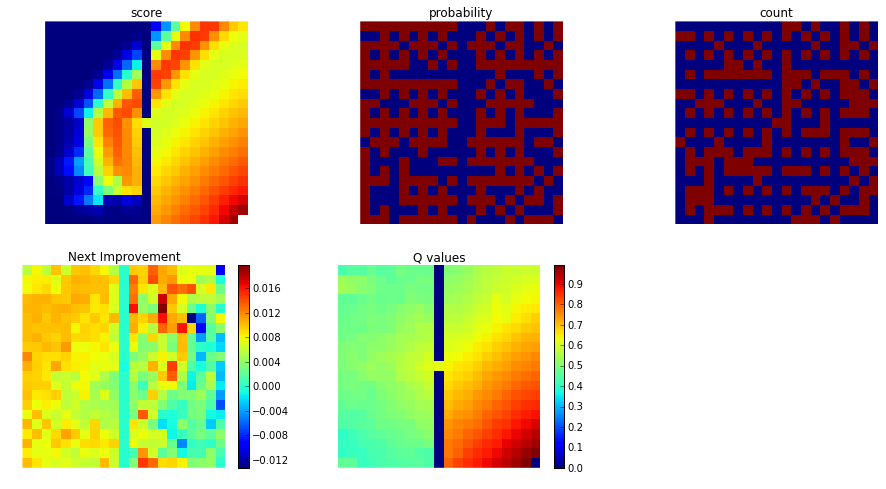

new Q value [ 0.62153793]
it 184


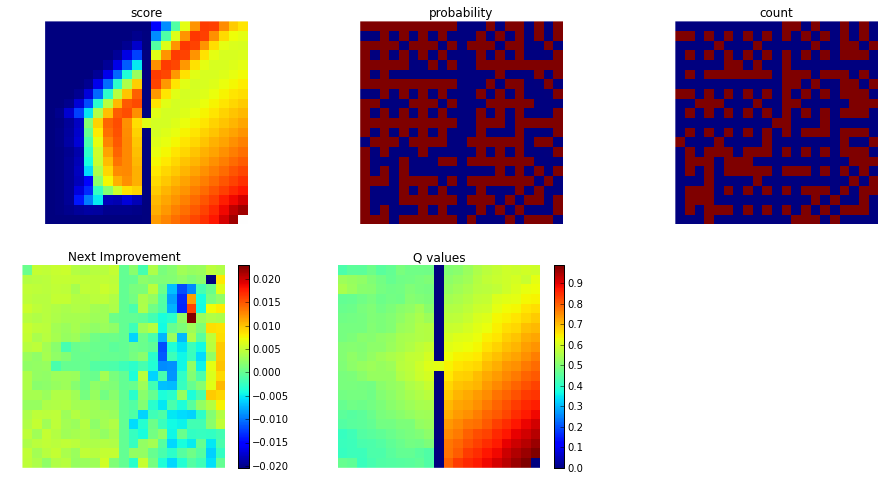

new Q value [ 0.56757961]
it 185


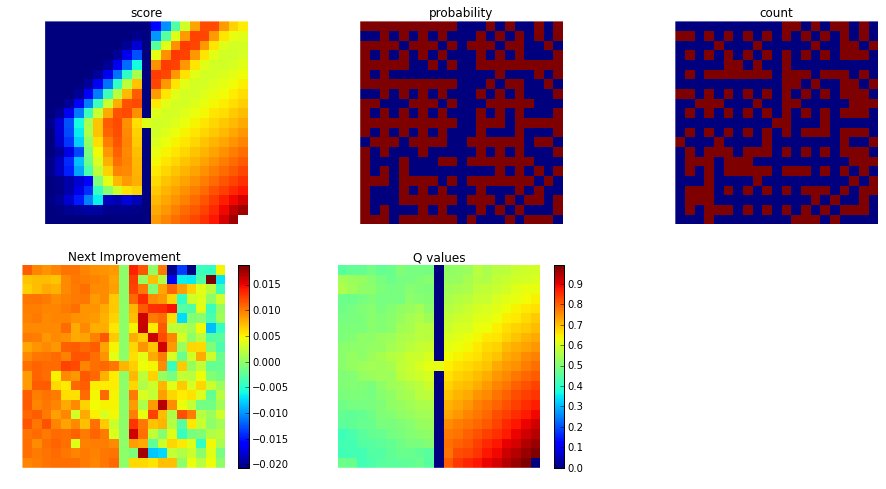

new Q value [ 0.45716058]
it 186


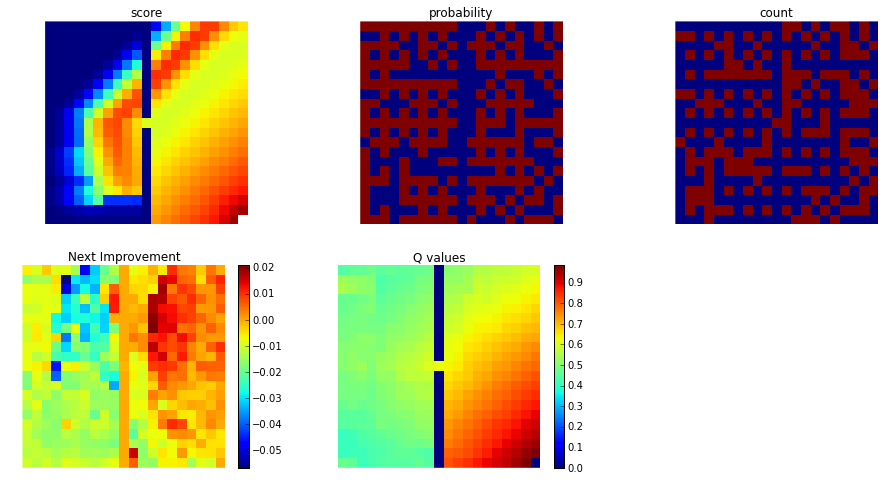

new Q value [ 0.64838475]
it 187


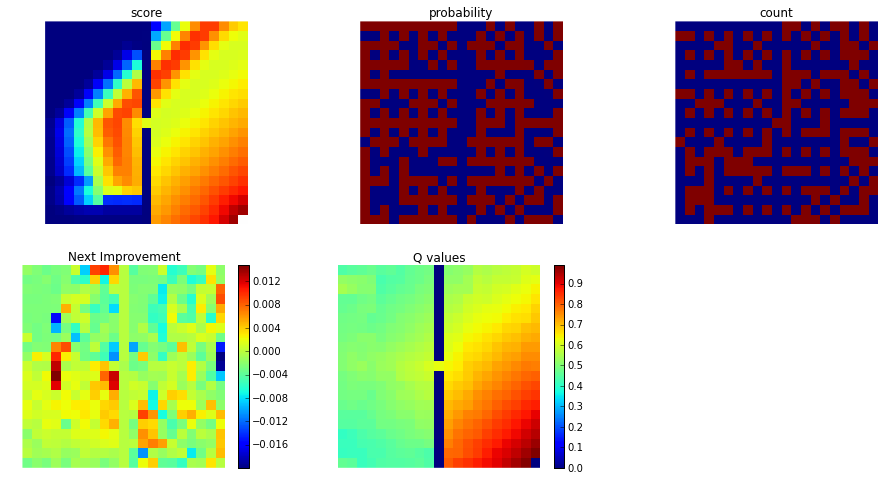

new Q value [ 0.54911468]
it 188


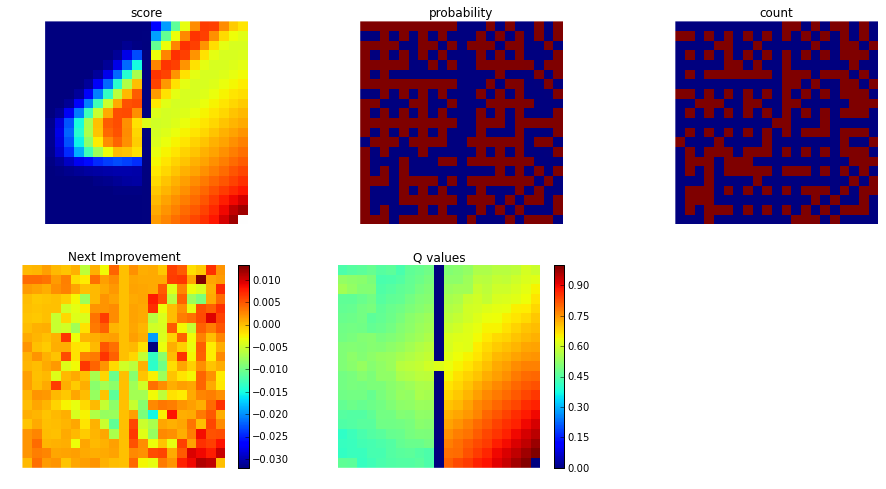

new Q value [ 0.68621796]
it 189


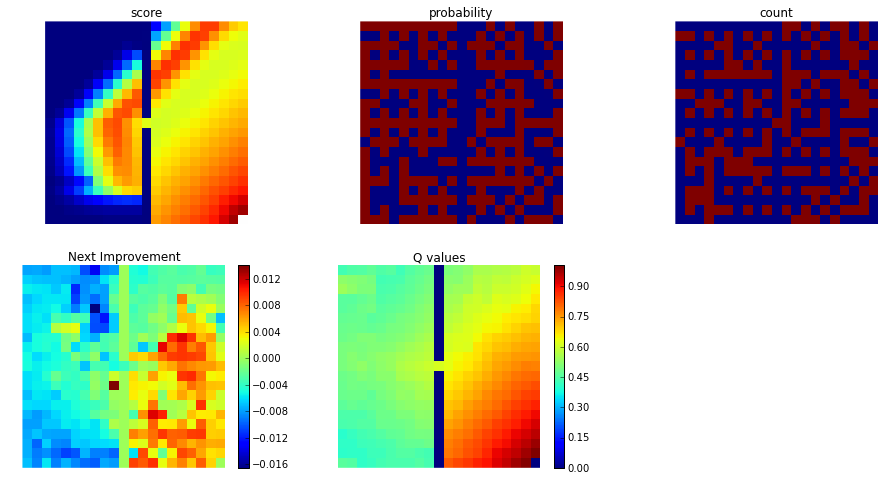

new Q value [ 0.53074543]
it 190


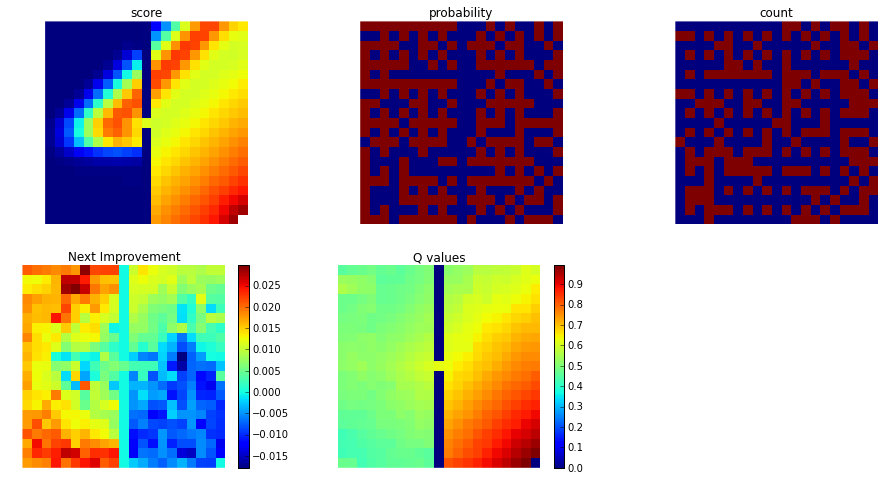

new Q value [ 0.45607943]
it 191


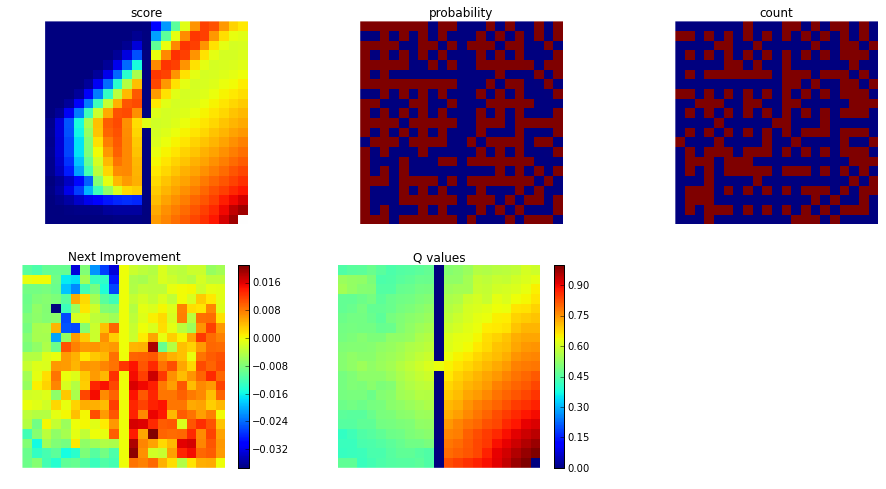

new Q value [ 0.49723611]
it 192


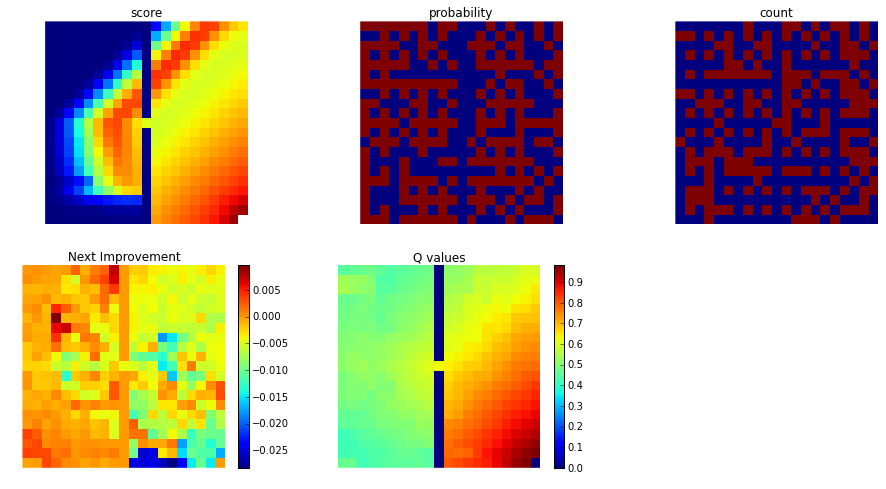

new Q value [ 0.50212266]
it 193


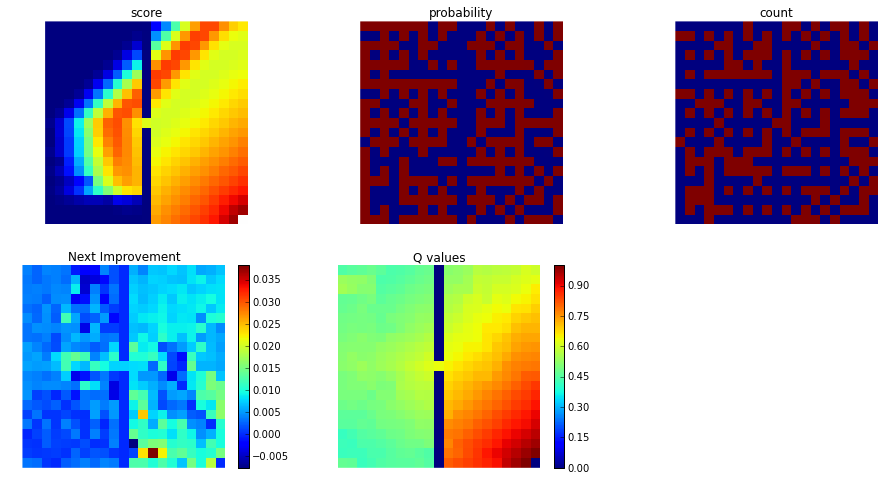

new Q value [ 0.39793377]
it 194


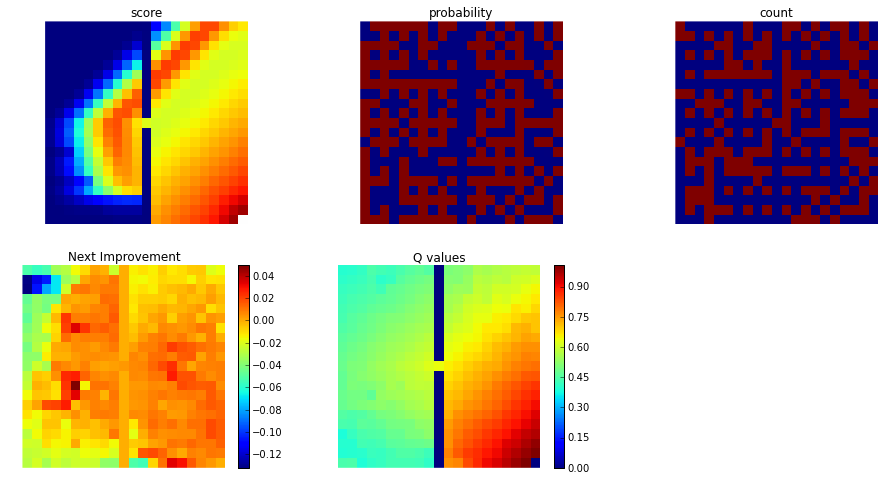

new Q value [ 0.58795574]
it 195


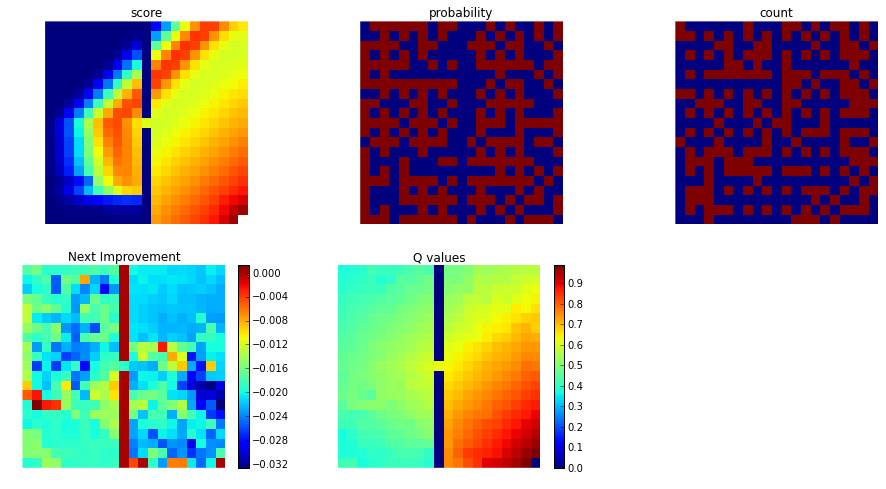

new Q value [ 0.70220387]
it 196


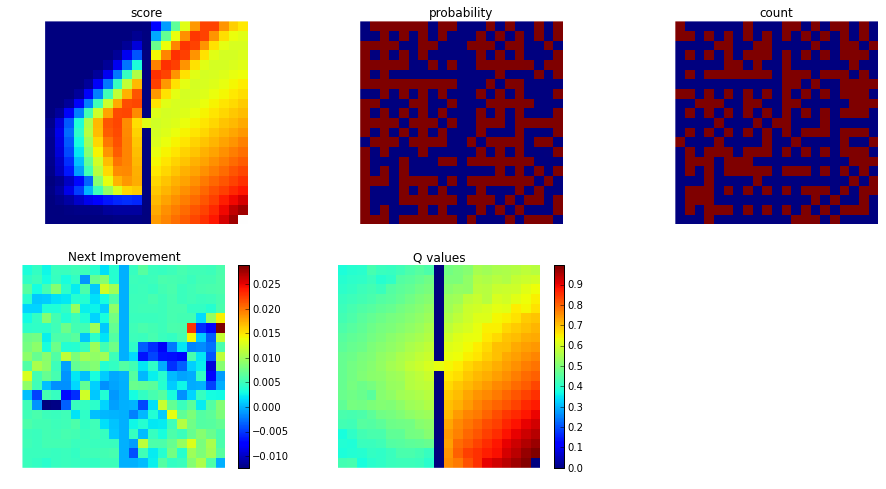

new Q value [ 0.47747373]
it 197


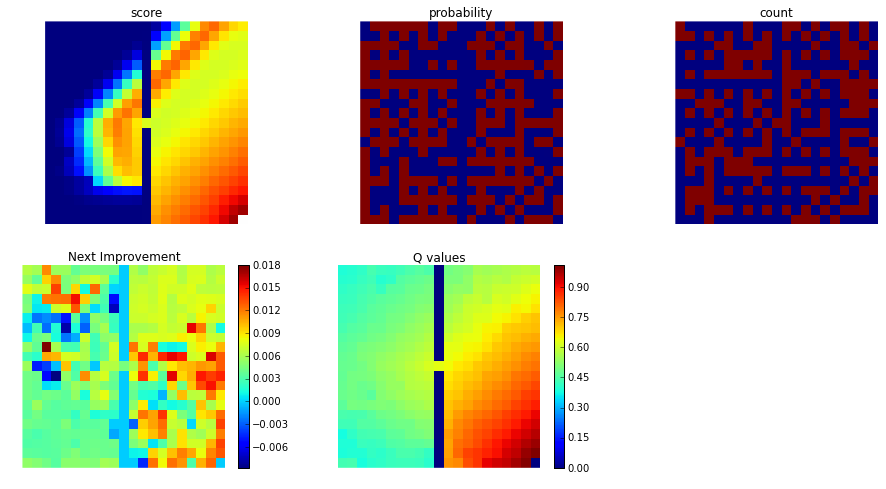

new Q value [ 0.56776708]
it 198


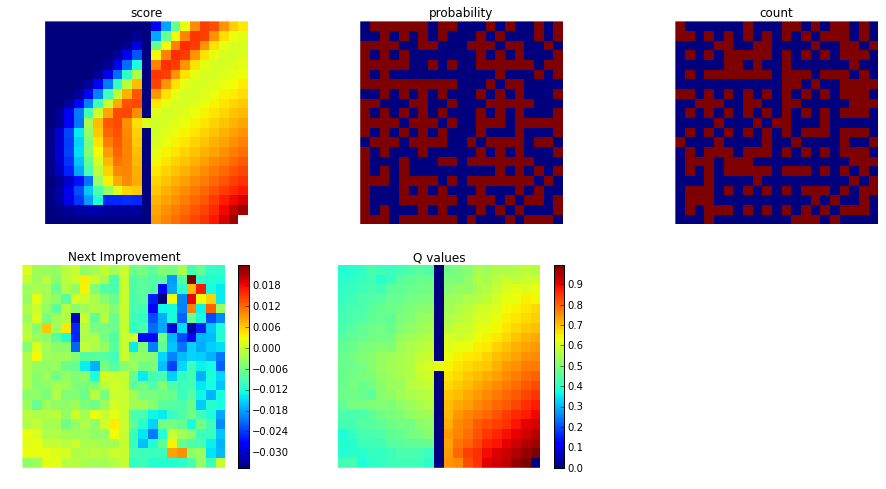

new Q value [ 0.61740549]
it 199


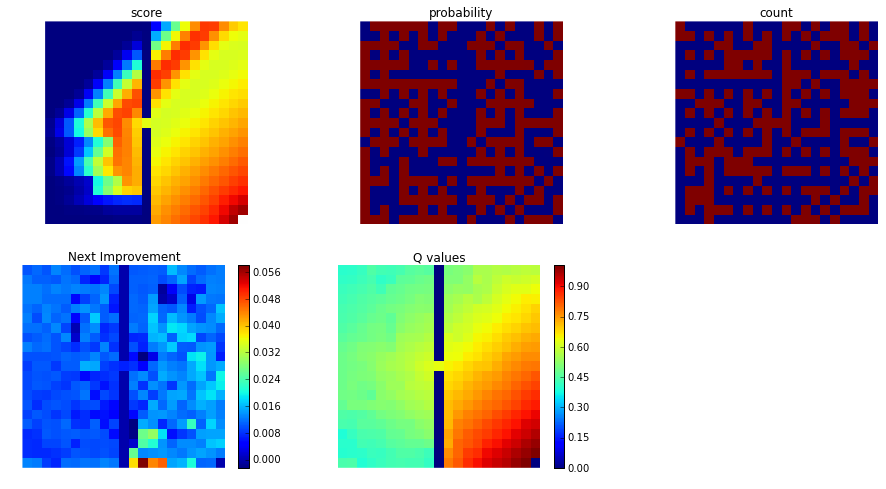

new Q value [ 0.58130275]
it 200


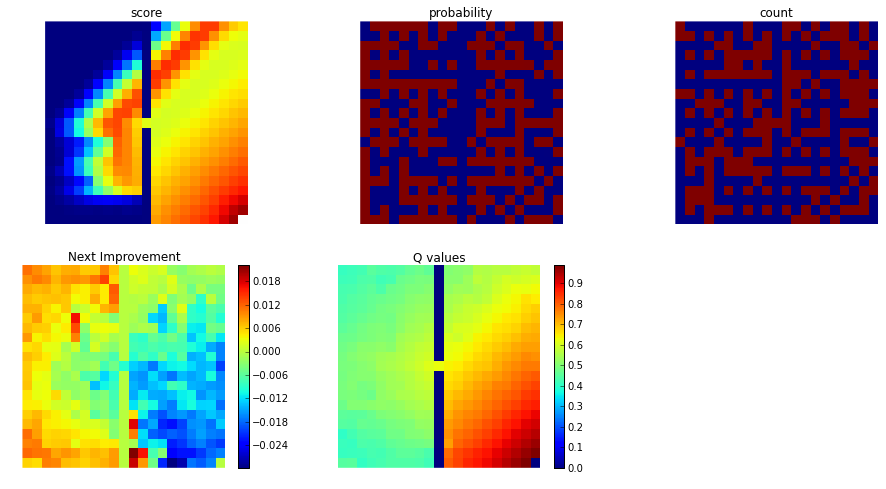

new Q value [ 0.99600891]
it 201


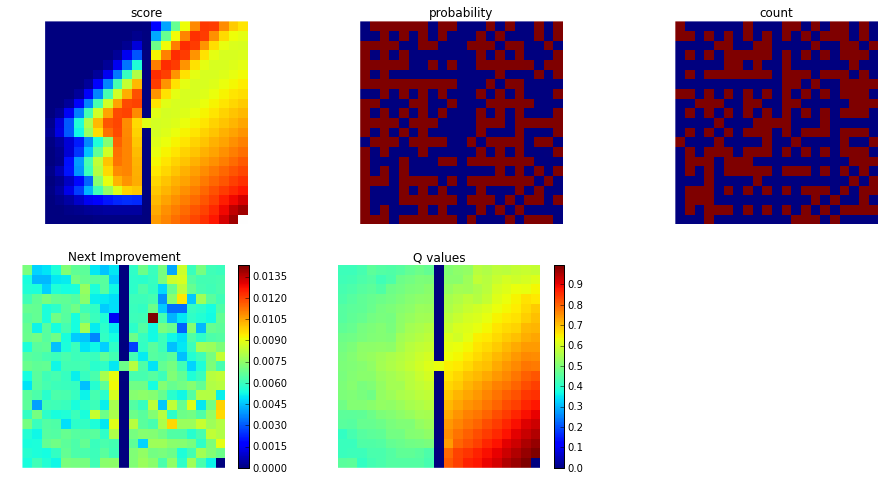

new Q value [ 0.45146593]
it 202


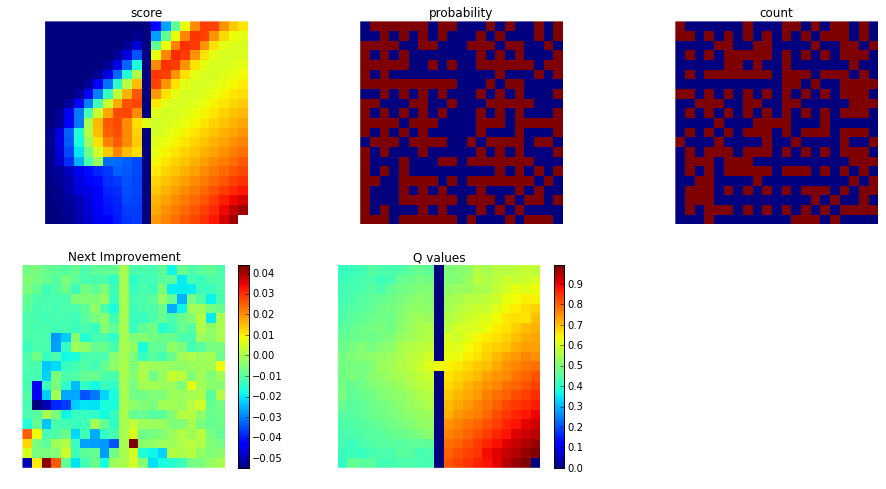

new Q value [ 0.4491975]
it 203


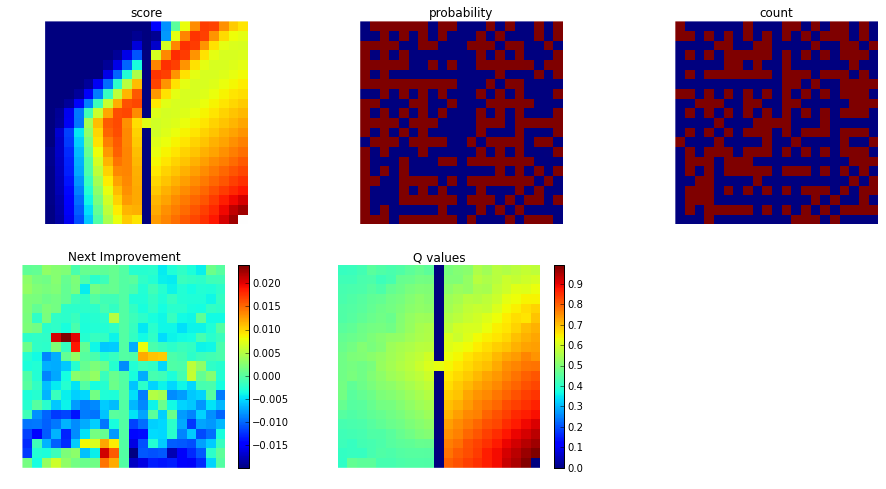

new Q value [ 0.59783881]
it 204


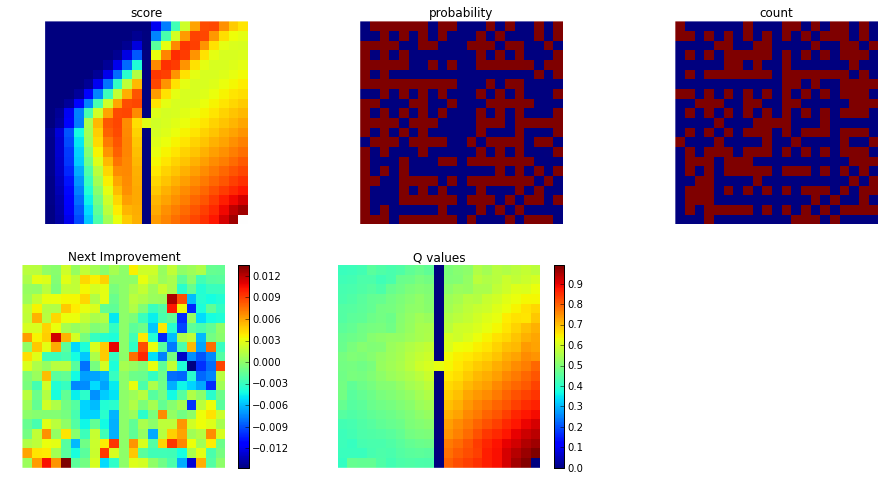

new Q value [ 0.42385248]
it 205


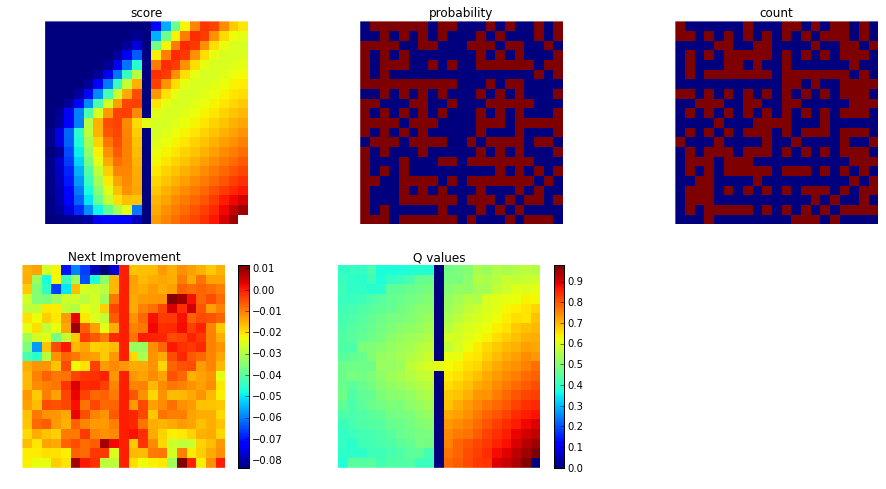

new Q value [ 0.44993003]
it 206


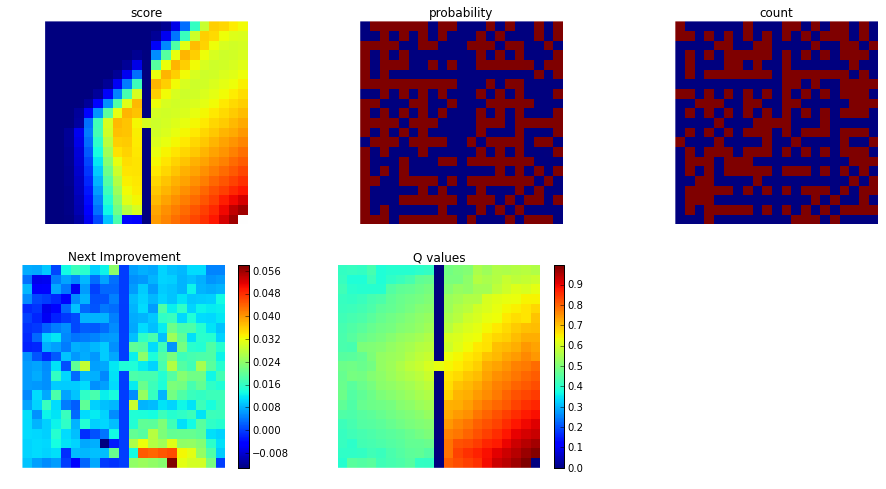

new Q value [ 0.52015427]
it 207


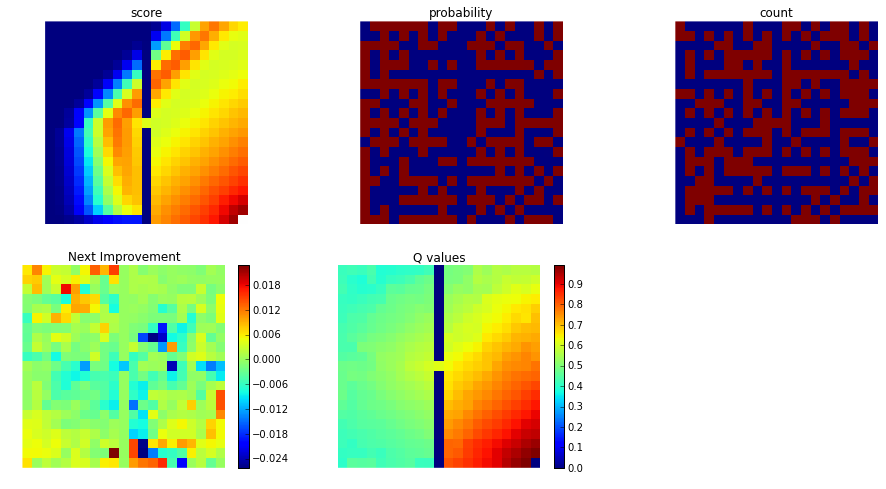

new Q value [ 0.55872407]
it 208


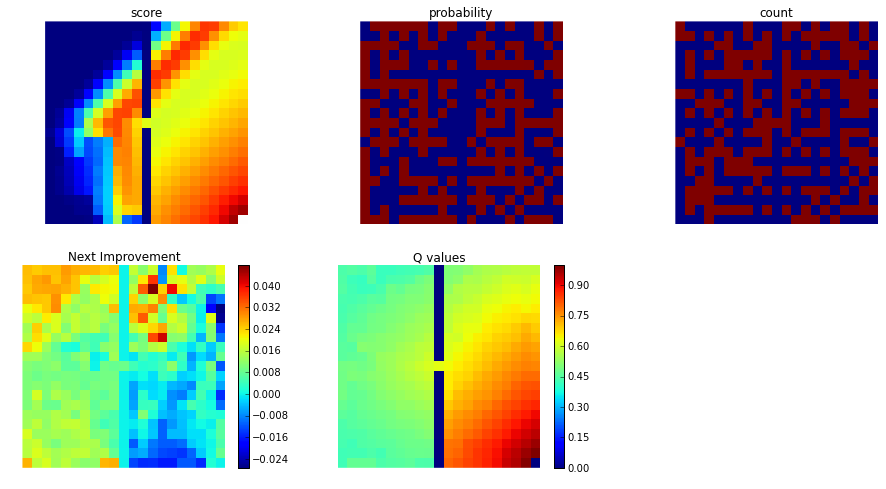

new Q value [ 0.89790923]
it 209


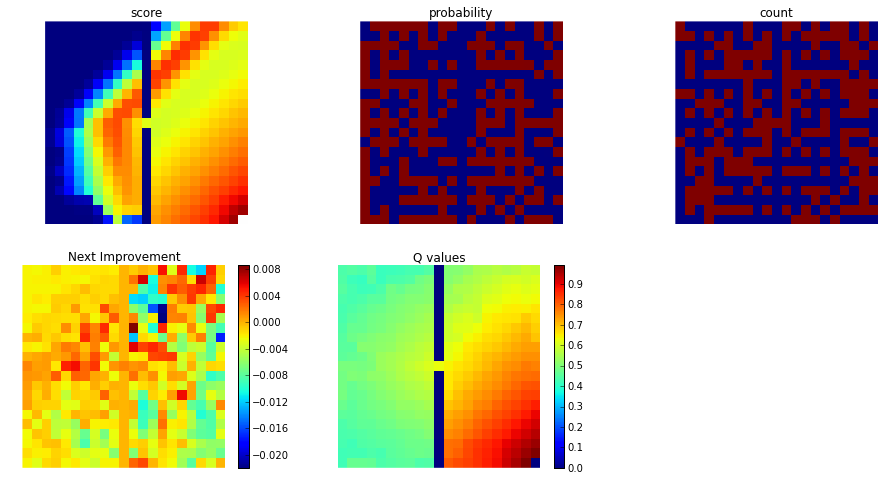

new Q value [ 0.5483031]
it 210


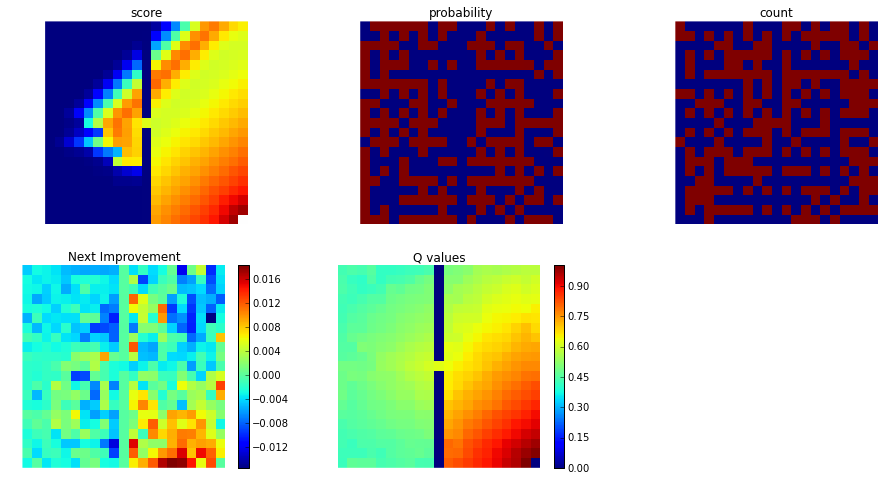

new Q value [ 0.53351809]
it 211


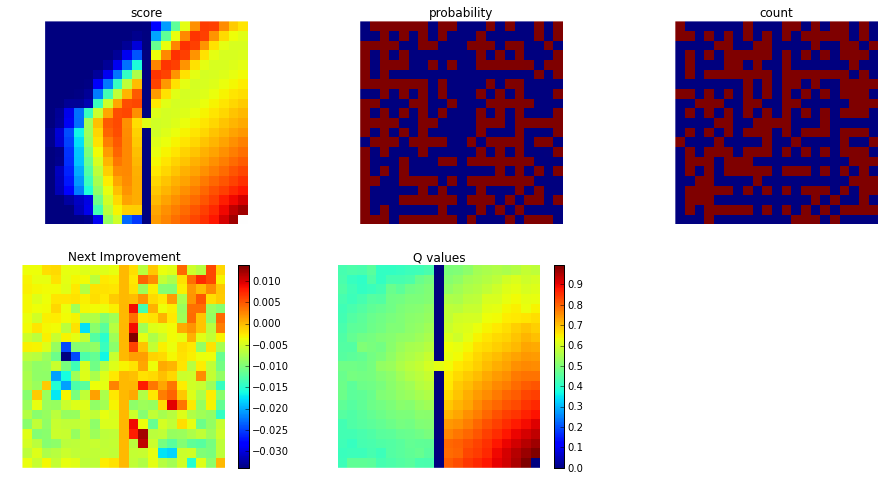

new Q value [ 0.46104266]
it 212


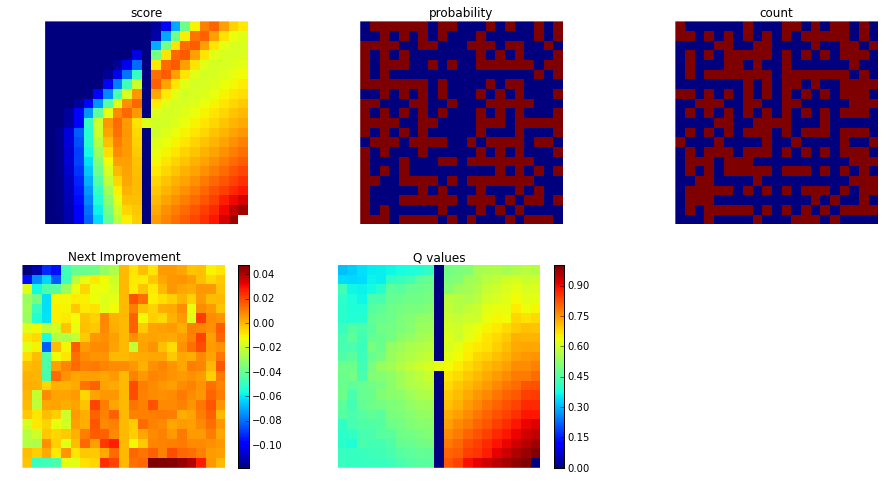

new Q value [ 0.73874122]
it 213


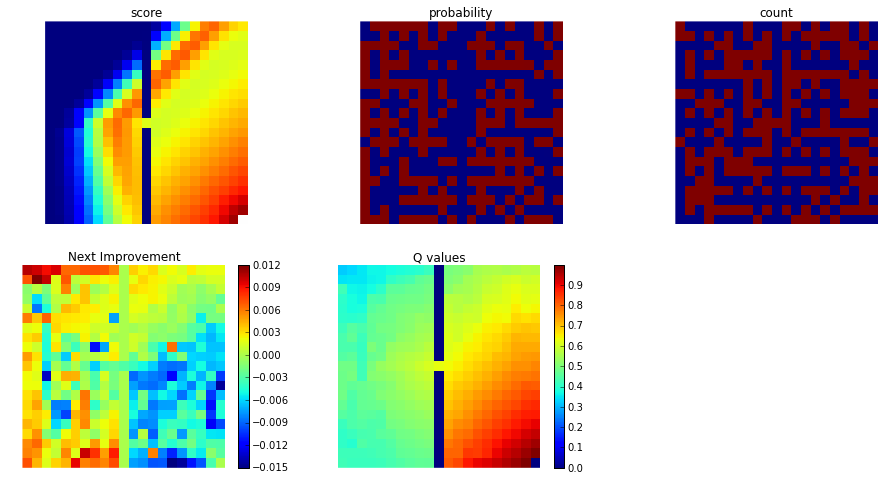

new Q value [ 0.5833167]
it 214


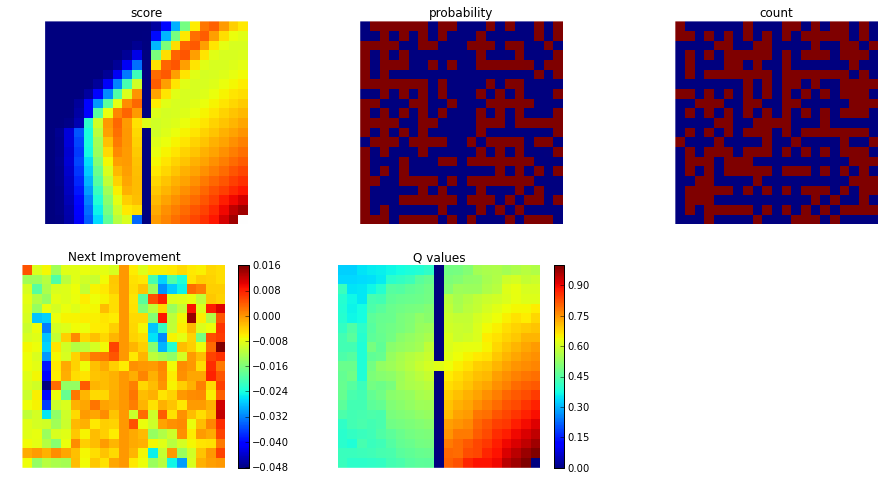

new Q value [ 0.4614661]
it 215


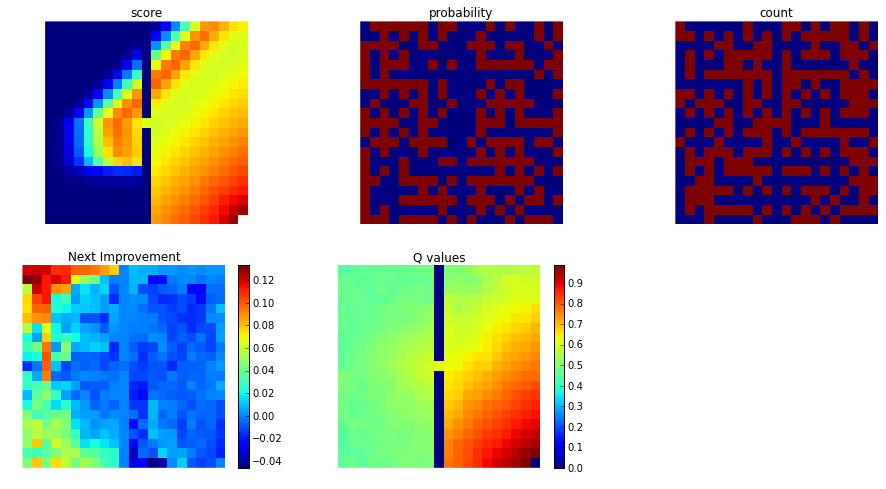

new Q value [ 0.45641626]
it 216


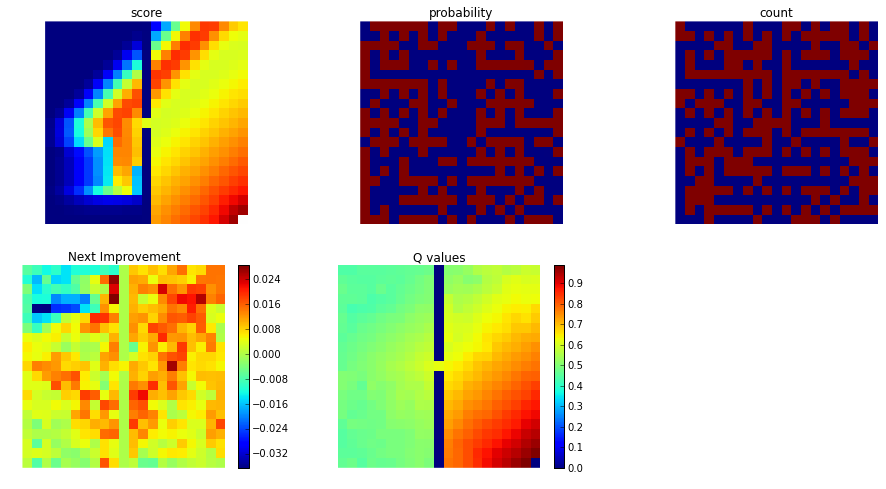

new Q value [ 0.53922039]
it 217


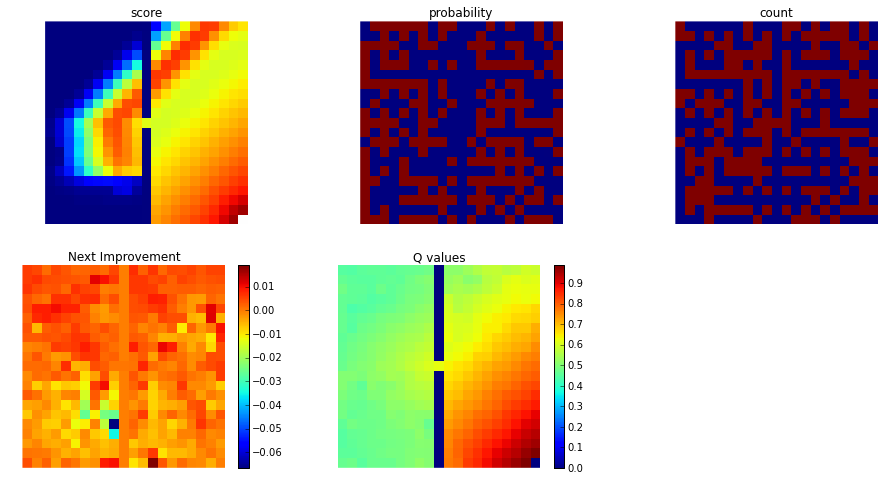

new Q value [ 0.46523995]
it 218


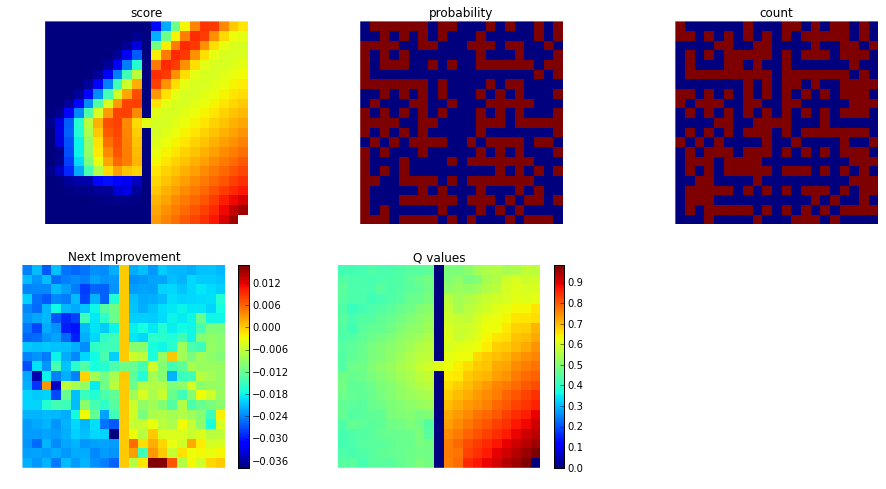

new Q value [ 0.48590602]
it 219


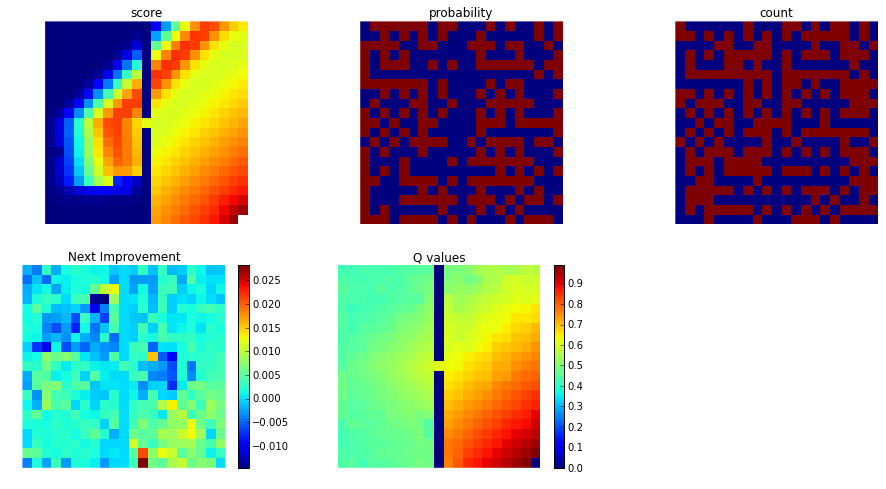

new Q value [ 0.48333984]
it 220


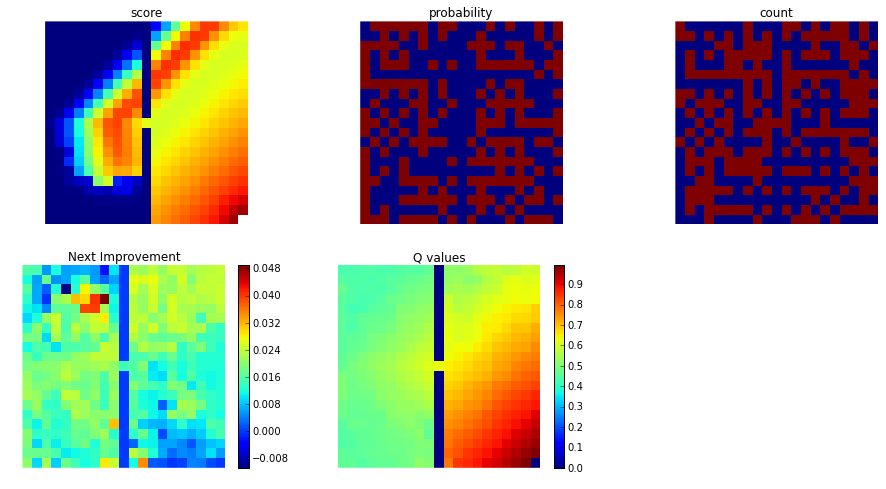

new Q value [ 0.73662183]
it 221


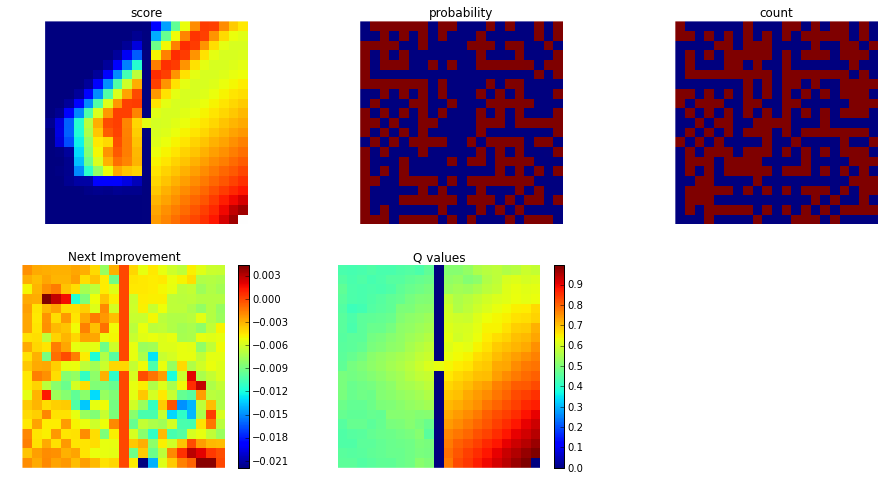

new Q value [ 0.52055051]
it 222


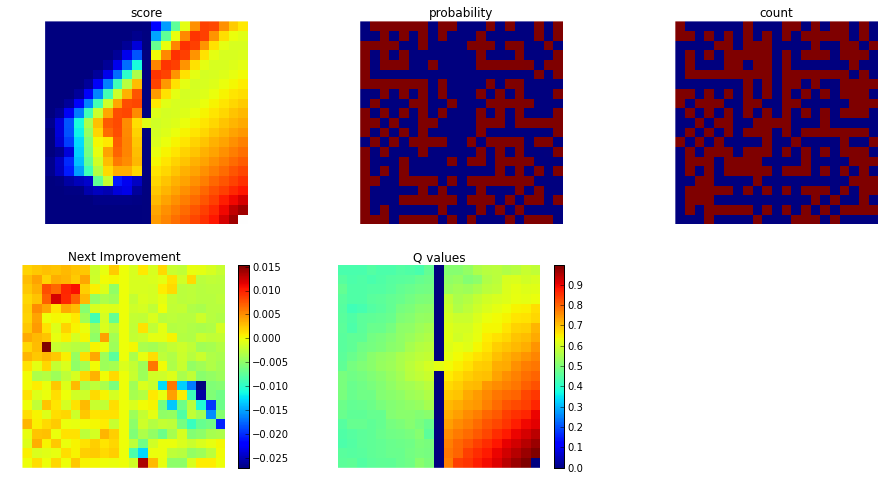

new Q value [ 0.79759598]
it 223


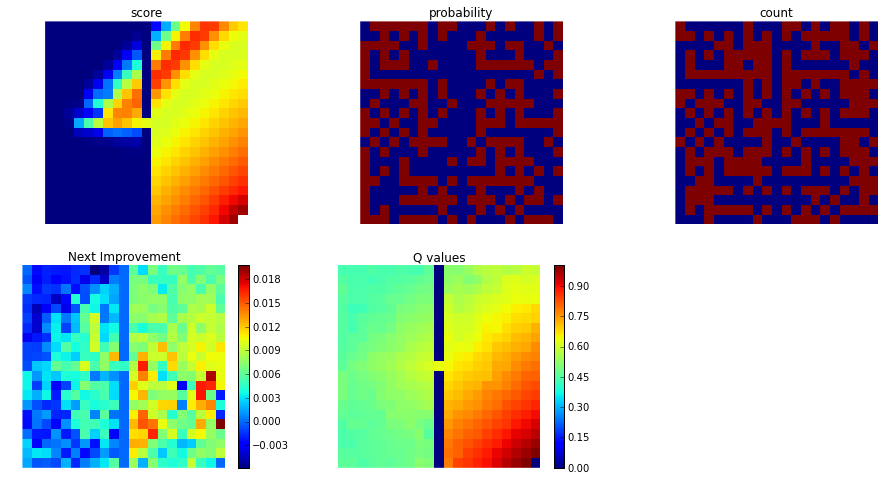

new Q value [ 0.73890301]
it 224


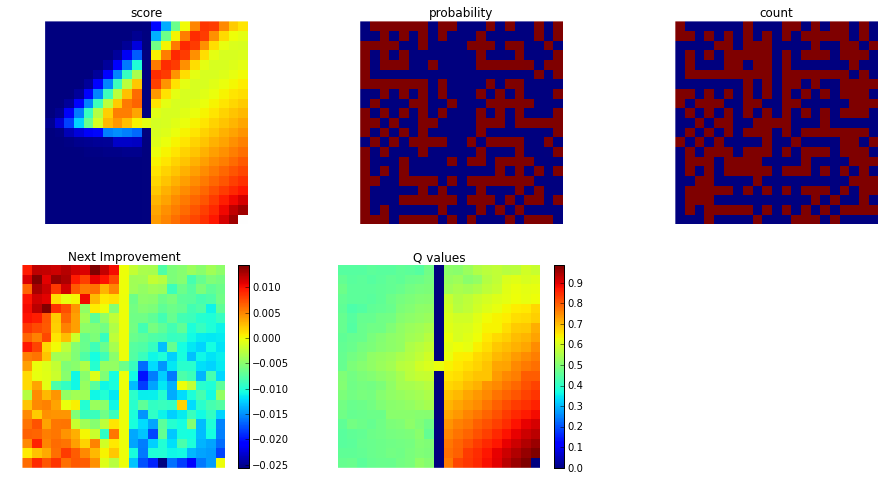

new Q value [ 0.58147077]
it 225


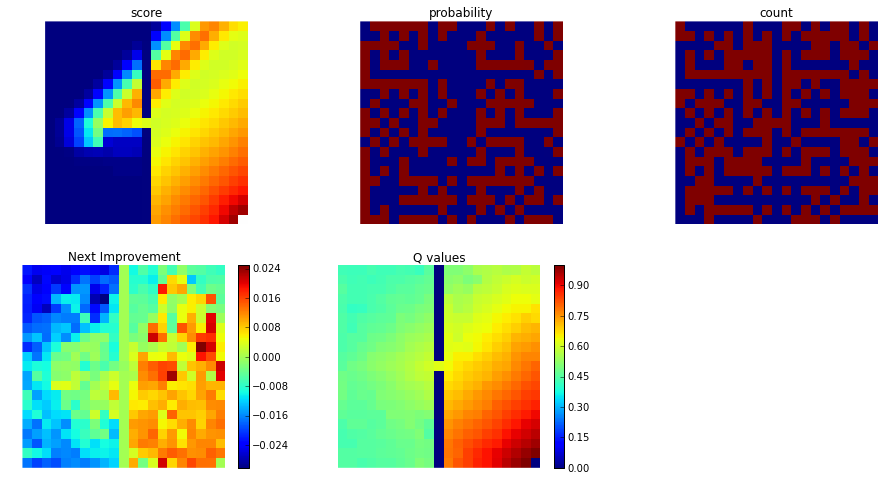

new Q value [ 0.50939847]
it 226


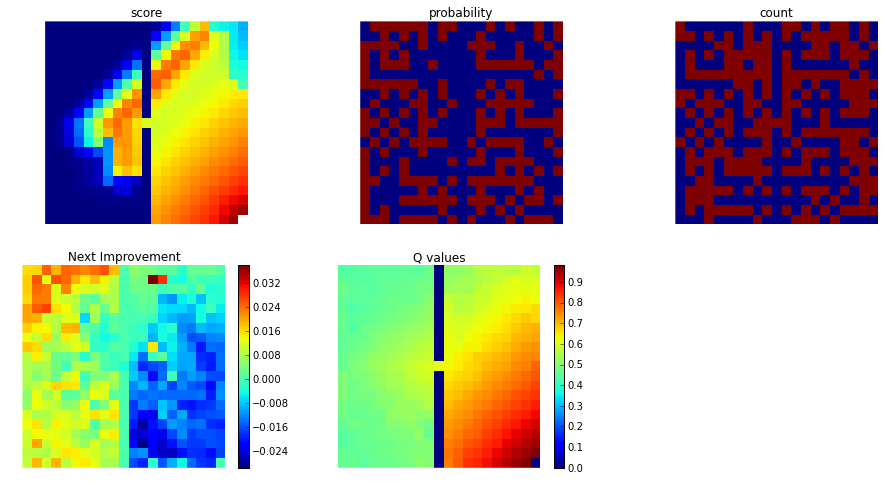

new Q value [ 0.48858472]
it 227


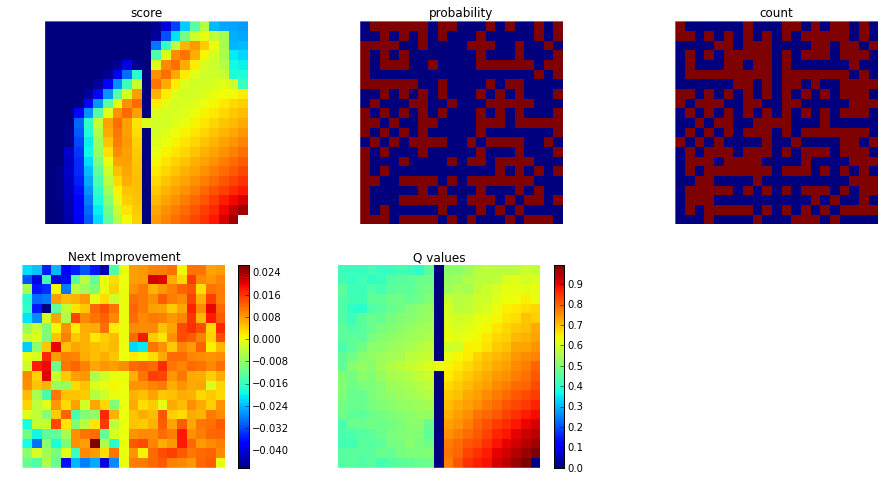

new Q value [ 0.42816285]
it 228


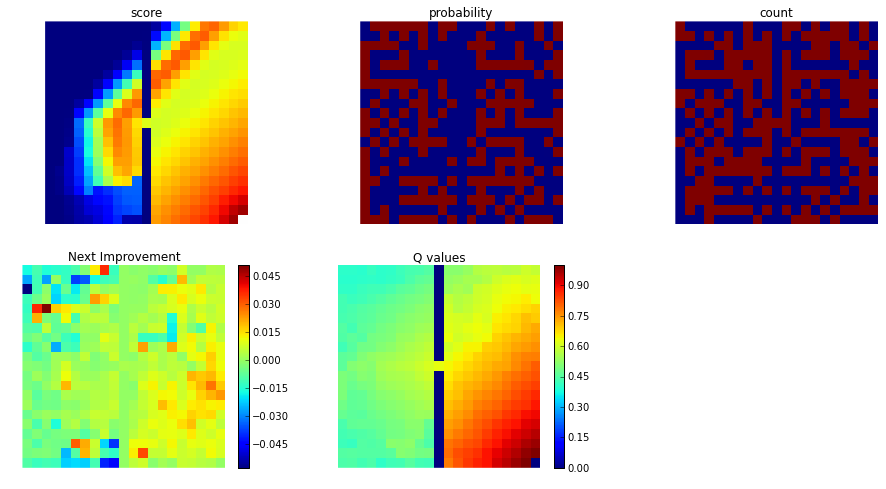

new Q value [ 0.45678705]
it 229


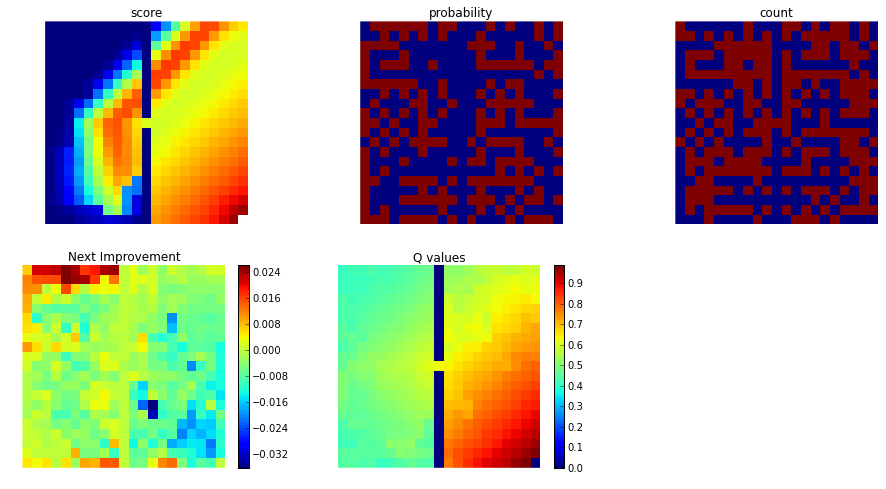

new Q value [ 0.41767852]
it 230


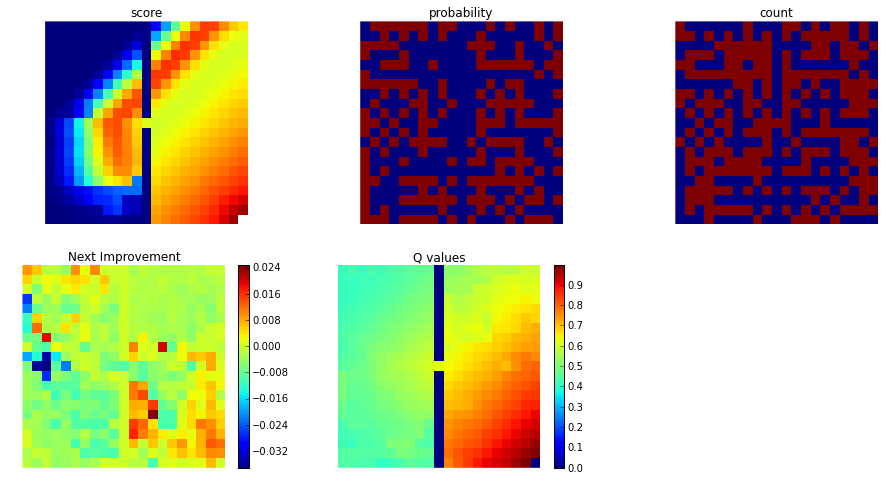

new Q value [ 0.57871025]
it 231


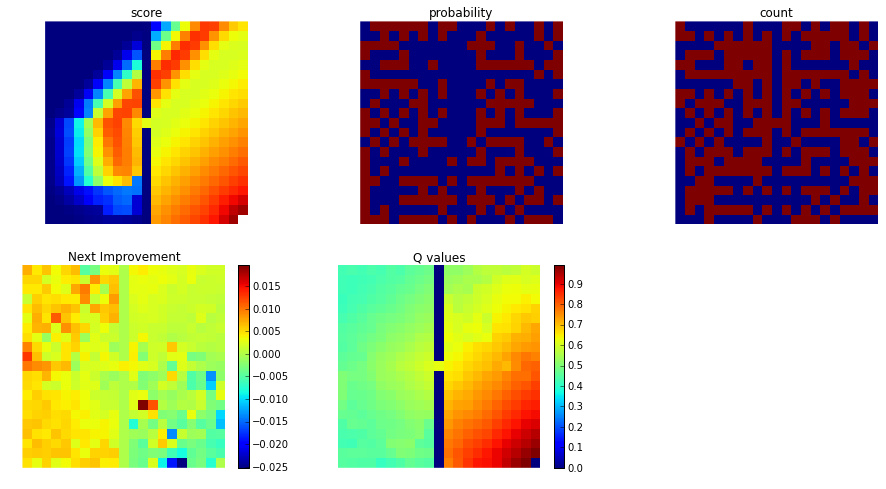

new Q value [ 0.86021239]
it 232


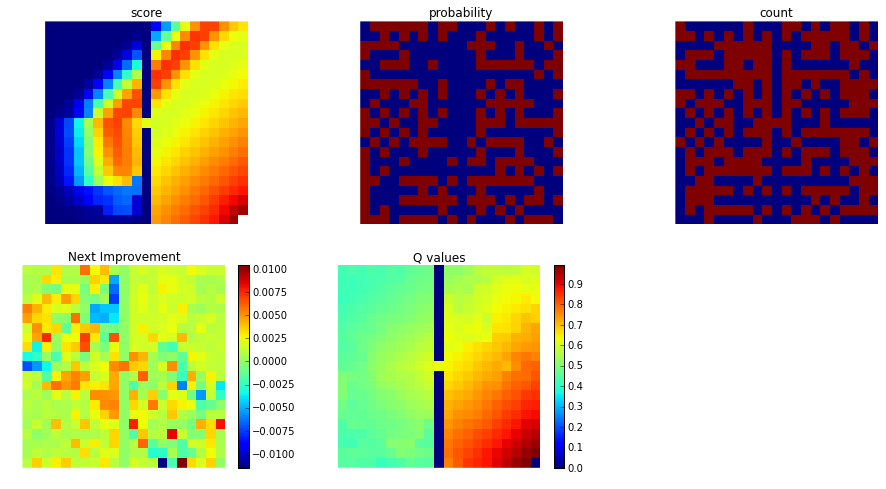

new Q value [ 0.55099032]
it 233


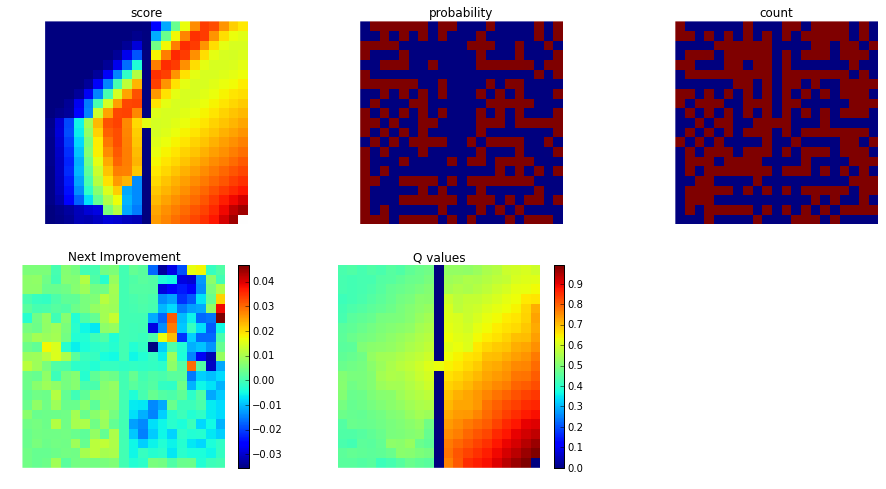

new Q value [ 0.76985537]
it 234


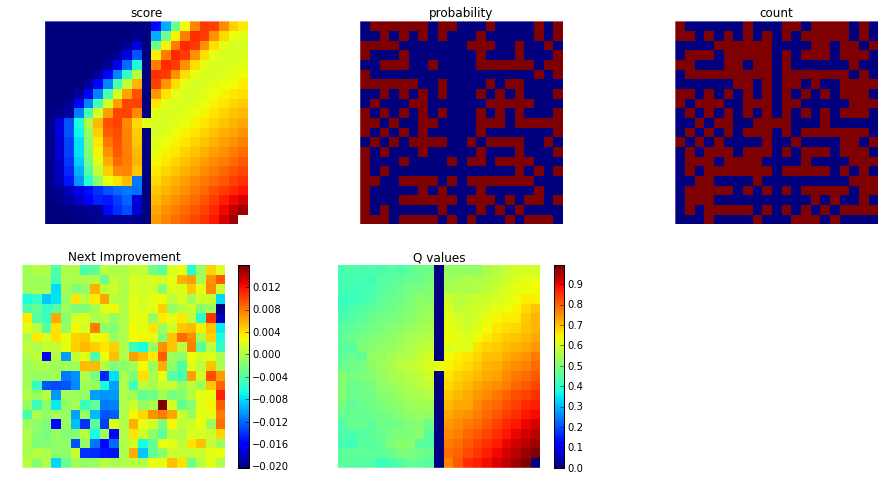

new Q value [ 0.40382602]
it 235


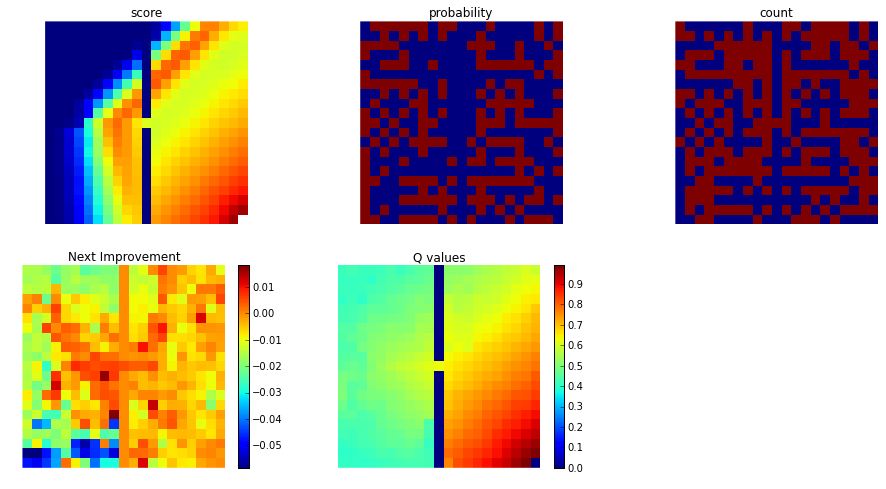

new Q value [ 0.95930181]
it 236


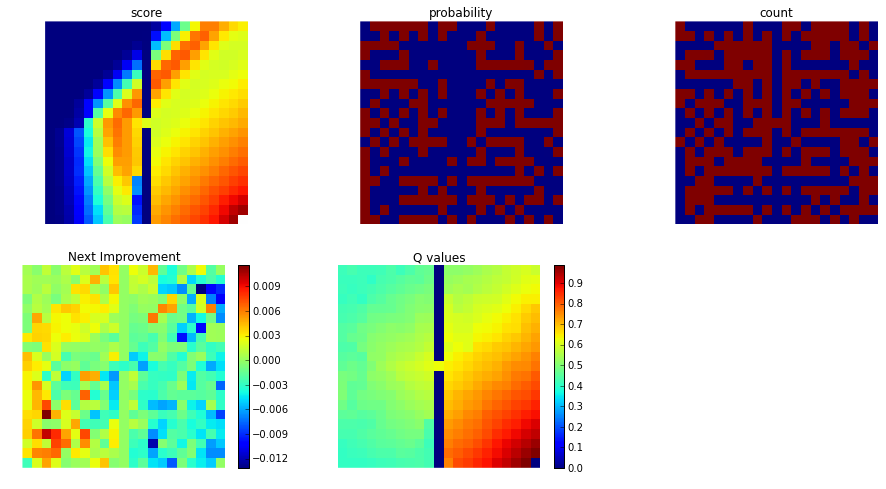

KeyboardInterrupt: 

In [312]:
scores = []

def diagnostic_function(it):
    if it % 1 == 0:
        print 'it', it
        figure(figsize=(16, 8))
        plt.subplot(2,3,1)
        plt.imshow(reward_tabular_normalized(dqn, task, tol=1e-1).reshape((21, 21)), interpolation='none', vmin=0., vmax=1.)
        axis('off')
        scores.append(expected_reward_tabular_normalized(dqn, task, tol=1e-1))
        plt.title('score')
        plt.subplot(2,3,4)
        showVdict(learner.I, task)
        plt.colorbar()
        plt.title('Next Improvement')
        plt.subplot(2,3,3)
        showVdict(learner.teleport_count, task)
        plt.title('count')
        plt.subplot(2,3,2)
        showVdict(learner.teleport_prob, task)
        plt.title('probability')
        plt.subplot(2,3,5)
        showVdict(learner.Q, task)
        plt.title('Q values')
        plt.colorbar()
        plt.show()
    
learner.run(num_epochs=500, budget=100000, batchsize=1, diagnostic_function=diagnostic_function)
    
        

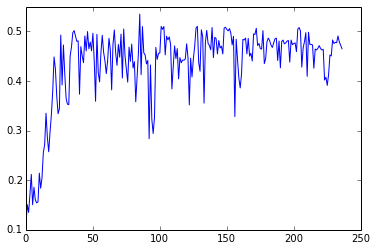

In [313]:
plot(scores)